# O quão bom é Max Verstappen? Uma análise de dados

Neste notebook, apresento uma análise de dados construída a partir da fonte de dados da F1 Jolpica, previamente extraído e refinado dentro da própria codebase em que este notebook está hospedado.

O objetivo é responder, de forma analítica, à pergunta: **“O quão bom é Max Verstappen?”**
Para isso, sigo uma narrativa dedutiva, partindo de indicadores mais gerais — como número de vitórias, pódios e títulos — a fim de estabelecer um panorama inicial e nivelar o contexto para qualquer leitor: estamos, sem dúvida, diante de um dos maiores pilotos da Fórmula 1 moderna.

Em seguida, à medida que a análise se aprofunda, passo a examinar métricas mais específicas e comparativas — como consistência de desempenho, diferença em relação aos companheiros de equipe e outros fatores que ajudam a isolar variáveis externas, como o desempenho do carro ou da equipe.
O objetivo é ir além da “obviedade” dos números brutos, buscando entender até que ponto o domínio de Verstappen é reflexo do carro ou resultado do próprio piloto.

Uma nota **importante** sobre a metodologia: esta análise foi construída sobre diversas óticas para medir a 'qualidade' de um piloto. Nenhuma métrica individual é perfeita, pois cada uma possui seus próprios vieses e limitações que podem ser discutidos. O insight principal não deve vir de um gráfico isolado, mas da consistência dos resultados em todas as frentes. Portanto, a conclusão é mais justa quando baseada no 'conjunto da obra'.


## Setup da análise:

Imports, configs etc...

In [1]:
import pandas as pd
import os
from pathlib import Path

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from dateutil.relativedelta import relativedelta

In [4]:
# Caminho absoluto da raiz do projeto
project_root = Path.cwd().parent  # se o notebook está em /notebooks
os.chdir(project_root)
print("Diretório atual:", Path.cwd())

from src.modules.data_processing.db_reader import DbReader
from src.analysis.data.utils import *
from src.analysis.data_viz.plotter import *
from src.analysis.verstappen_analysis.utils import *

f1_db = DbReader()

Diretório atual: b:\projetos\f1_analytics


### Importando os datasets:

In [5]:
# Corridas:

df_races = f1_db.run_query_file("data/db_queries/race_results_report.sql").drop_duplicates()
df_races['race_date'] = pd.to_datetime(df_races['race_date'])
df_races['race_count_for_driver'] = df_races.groupby(['driver_id'])['race_name'].transform('count')


df_races

race_name  round_id  year  race_date  \
0      Australian Grand Prix      1126  2025 2025-03-16   
1      Australian Grand Prix      1126  2025 2025-03-16   
2      Australian Grand Prix      1126  2025 2025-03-16   
3      Australian Grand Prix      1126  2025 2025-03-16   
4      Australian Grand Prix      1126  2025 2025-03-16   
...                      ...       ...   ...        ...   
25748     Italian Grand Prix         7  1950 1950-09-03   
25749     Italian Grand Prix         7  1950 1950-09-03   
25750     Italian Grand Prix         7  1950 1950-09-03   
25751     Italian Grand Prix         7  1950 1950-09-03   
25752     Italian Grand Prix         7  1950 1950-09-03   

                         circuit_name circuit_country  driver_id driver_code  \
0      Albert Park Grand Prix Circuit       Australia        845         NOR   
1      Albert Park Grand Prix Circuit       Australia        831         VER   
2      Albert Park Grand Prix Circuit       Australia        847         RUS   
3      Albert Park Grand Prix Circuit       Australia        863         ANT   
4      Albert Park Grand Prix Circuit       Australia        846         ALB   
...                               ...             ...        ...         ...   
25748    Autodromo Nazionale di Monza           Italy         80        None   
25749    Autodromo Nazionale di Monza           Italy         28        None   
25750    Autodromo Nazionale di Monza           Italy         15        None   
25751    Autodromo Nazionale di Monza           Italy         81        None   
25752    Autodromo Nazionale di Monza           Italy         68        None   

           driver_ref driver_forename  ... finishing_position points_scored  \
0              norris           Lando  ...                  1          25.0   
1      max_verstappen             Max  ...                  2          18.0   
2             russell          George  ...                  3          15.0   
3           antonelli     Andrea Kimi  ...                  4          12.0   
4               albon       Alexander  ...                  5          10.0   
...               ...             ...  ...                ...           ...   
25748          sanesi        Consalvo  ...                 23           0.0   
25749          manzon          Robert  ...                 24           0.0   
25750            bira          Prince  ...                 25           0.0   
25751         pietsch            Paul  ...                 26           0.0   
25752         bonetto          Felice  ...                 27           0.0   

      laps_completed time_in_race_ms fastest_lap_number  fastest_lap_rank  \
0               57.0    01:42:06.304               43.0               1.0   
1               57.0    01:42:07.199               43.0               3.0   
2               57.0    01:42:14.785               43.0              11.0   
3               57.0    01:42:16.439               43.0               9.0   
4               57.0    01:42:19.077               43.0               8.0   
...              ...             ...                ...               ...   
25748           11.0            None                NaN               NaN   
25749            7.0            None                NaN               NaN   
25750            1.0            None                NaN               NaN   
25751            0.0            None                NaN               NaN   
25752            0.0            None                NaN               NaN   

       fastest_lap_time  fastest_lap_speed  race_status race_count_for_driver  
0          00:01:22.167                NaN          0.0                   146  
1          00:01:23.081                NaN          0.0                   227  
2          00:01:25.065                NaN          0.0                   146  
3          00:01:24.901                NaN          0.0                    18  
4          00:01:24.597                NaN          0.0                   1

In [6]:
# Infos sobre pilotos:

df_drivers = f1_db.run_query_file("data/db_queries/drivers.sql").drop_duplicates()
df_drivers['dob'] = pd.to_datetime(df_drivers['dob'])
df_drivers


driver_id driver_code driver_forename driver_surname  \
0            1        None            Nino         Farina   
1            2        None           Luigi        Fagioli   
2            3        None             Reg        Parnell   
3            4        None            Yves      Cabantous   
4            5        None           Louis         Rosier   
..         ...         ...             ...            ...   
859        860         COL          Franco      Colapinto   
860        861         DOO            Jack         Doohan   
861        862         BOR         Gabriel      Bortoleto   
862        863         ANT     Andrea Kimi      Antonelli   
863        864         HAD           Isack         Hadjar   

          driver_full_name        dob  
0              Nino Farina 1906-10-30  
1            Luigi Fagioli 1898-06-09  
2              Reg Parnell 1911-07-02  
3           Yves Cabantous 1904-10-08  
4             Louis Rosier 1905-11-05  
..                     ...        ...  
859       Franco Colapinto 2003-05-27  
860            Jack Doohan 2003-01-20  
861      Gabriel Bortoleto 2004-10-14  
862  Andrea Kimi Antonelli 2006-08-25  
863           Isack Hadjar 2004-09-28  

[864 rows x 6 columns]

In [7]:
df_lap_times = f1_db.run_query_file("data/db_queries/lap_times_report.sql").drop_duplicates()
df_lap_times['race_date'] = pd.to_datetime(df_lap_times['race_date'])
df_lap_times = add_lap_time_ms_column(df_lap_times)
df_lap_times

race_name  year  race_date  \
0        Singapore Grand Prix  2025 2025-10-05   
1        Singapore Grand Prix  2025 2025-10-05   
2        Singapore Grand Prix  2025 2025-10-05   
3        Singapore Grand Prix  2025 2025-10-05   
4        Singapore Grand Prix  2025 2025-10-05   
...                       ...   ...        ...   
609537  Australian Grand Prix  1996 1996-03-10   
609538  Australian Grand Prix  1996 1996-03-10   
609539  Australian Grand Prix  1996 1996-03-10   
609540  Australian Grand Prix  1996 1996-03-10   
609541  Australian Grand Prix  1996 1996-03-10   

                          circuit_name circuit_country driver_code  \
0            Marina Bay Street Circuit       Singapore         RUS   
1            Marina Bay Street Circuit       Singapore         VER   
2            Marina Bay Street Circuit       Singapore         NOR   
3            Marina Bay Street Circuit       Singapore         PIA   
4            Marina Bay Street Circuit       Singapore         LEC   
...                                ...             ...         ...   
609537  Albert Park Grand Prix Circuit       Australia        None   
609538  Albert Park Grand Prix Circuit       Australia         VIL   
609539  Albert Park Grand Prix Circuit       Australia        None   
609540  Albert Park Grand Prix Circuit       Australia        None   
609541  Albert Park Grand Prix Circuit       Australia        None   

       driver_forename driver_surname    driver_full_name driver_nationality  \
0               George        Russell      George Russell            British   
1                  Max     Verstappen      Max Verstappen              Dutch   
2                Lando         Norris        Lando Norris            British   
3                Oscar        Piastri       Oscar Piastri         Australian   
4              Charles        Leclerc     Charles Leclerc         Monegasque   
...                ...            ...                 ...                ...   
609537           Damon           Hill          Damon Hill            British   
609538         Jacques     Villeneuve  Jacques Villeneuve           Canadian   
609539           Eddie         Irvine        Eddie Irvine            British   
609540         Gerhard         Berger      Gerhard Berger           Austrian   
609541            Mika       Häkkinen       Mika Häkkinen            Finnish   

        lap_number  position_on_lap      lap_time  race_status  is_pit_lap  \
0              1.0              1.0  00:01:43.905          0.0           0   
1              1.0              2.0  00:01:44.887          0.0           0   
2              1.0              3.0  00:01:45.566          0.0           0   
3              1.0              4.0  00:01:46.982          0.0           0   
4              1.0              5.0  00:01:47.564          0.0           0   
...            ...              ...           ...          ...         ...   
609537        58.0              1.0  00:01:37.529          0.0           0   
609538        58.0              2.0  00:01:45.524          0.0           0   
609539        58.0              3.0  00:01:39.312          0.0           0   
609540        58.0              4.0  00:01:38.055          0.0           0   
609541        58.0              5.0  00:01:39.572          0.0           0   

        lap_time_ms  
0          103905.0  
1          104887.0  
2          105566.0  
3          106982.0  
4          107564.0  
...             ...  
609537      97529.0  
609538     105524.0  
609539      99312.0  
609540      98055.0  
609541      99572.0  

[609070 rows x 16 columns]

In [8]:
# Vou adicionar a idade no dataset de corridas, já que vou acabar usando isso agora e em outros momentos:

df_races = pd.merge(
    df_races,
    df_drivers[['driver_id', 'dob']],
    on='driver_id',
    how='left'
)

df_races['driver_age_at_race'] = df_races.apply(lambda row: calcula_idade(row['dob'], row['race_date']), axis=1)
df_races

race_name  round_id  year  race_date  \
0      Australian Grand Prix      1126  2025 2025-03-16   
1      Australian Grand Prix      1126  2025 2025-03-16   
2      Australian Grand Prix      1126  2025 2025-03-16   
3      Australian Grand Prix      1126  2025 2025-03-16   
4      Australian Grand Prix      1126  2025 2025-03-16   
...                      ...       ...   ...        ...   
25748     Italian Grand Prix         7  1950 1950-09-03   
25749     Italian Grand Prix         7  1950 1950-09-03   
25750     Italian Grand Prix         7  1950 1950-09-03   
25751     Italian Grand Prix         7  1950 1950-09-03   
25752     Italian Grand Prix         7  1950 1950-09-03   

                         circuit_name circuit_country  driver_id driver_code  \
0      Albert Park Grand Prix Circuit       Australia        845         NOR   
1      Albert Park Grand Prix Circuit       Australia        831         VER   
2      Albert Park Grand Prix Circuit       Australia        847         RUS   
3      Albert Park Grand Prix Circuit       Australia        863         ANT   
4      Albert Park Grand Prix Circuit       Australia        846         ALB   
...                               ...             ...        ...         ...   
25748    Autodromo Nazionale di Monza           Italy         80        None   
25749    Autodromo Nazionale di Monza           Italy         28        None   
25750    Autodromo Nazionale di Monza           Italy         15        None   
25751    Autodromo Nazionale di Monza           Italy         81        None   
25752    Autodromo Nazionale di Monza           Italy         68        None   

           driver_ref driver_forename  ... laps_completed time_in_race_ms  \
0              norris           Lando  ...           57.0    01:42:06.304   
1      max_verstappen             Max  ...           57.0    01:42:07.199   
2             russell          George  ...           57.0    01:42:14.785   
3           antonelli     Andrea Kimi  ...           57.0    01:42:16.439   
4               albon       Alexander  ...           57.0    01:42:19.077   
...               ...             ...  ...            ...             ...   
25748          sanesi        Consalvo  ...           11.0            None   
25749          manzon          Robert  ...            7.0            None   
25750            bira          Prince  ...            1.0            None   
25751         pietsch            Paul  ...            0.0            None   
25752         bonetto          Felice  ...            0.0            None   

      fastest_lap_number fastest_lap_rank fastest_lap_time  fastest_lap_speed  \
0                   43.0              1.0     00:01:22.167                NaN   
1                   43.0              3.0     00:01:23.081                NaN   
2                   43.0             11.0     00:01:25.065                NaN   
3                   43.0              9.0     00:01:24.901                NaN   
4                   43.0              8.0     00:01:24.597                NaN   
...                  ...              ...              ...                ...   
25748                NaN              NaN             None                NaN   
25749                NaN              NaN             None                NaN   
25750                NaN              NaN             None                NaN   
25751                NaN              NaN             None                NaN   
25752                NaN              NaN             None                NaN   

       race_status  race_count_for_driver        dob driver_age_at_race  
0              0.0                    146 1999-11-13          25.338809  
1              0.0                    227 1997-09-30          27.457906  
2              0.0                    146 1998-02-15          27.080082  
3              0.0                     18 2006-08-25          18.557153  
4              0.0                    123 1996-03-23          28.980151  
...    

## Começando do começo...

Max Verstappen chegou fazendo barulho na F1, sendo o piloto mais jovem da história da F1 ao largar em uma corrida:

In [9]:
df_first_race = gerar_dataset_primeiro_evento(df_races, df_drivers)

In [10]:
df_top_10_jovens_largada = df_first_race[df_first_race['race_count_for_driver'] > 5] # Tem uns pilotos que fizeram só 1 GP há muito tempo, não quero levar em conta e não muda o Top 1
df_top_10_jovens_largada = df_top_10_jovens_largada.sort_values("idade_primeiro_evento").head(10)
df_top_10_jovens_largada

driver_id       driver_full_name                 race_name  race_date  \
538        831         Max Verstappen     Australian Grand Prix 2015-03-15   
478        840           Lance Stroll     Australian Grand Prix 2017-03-26   
36         863  Andrea Kimi Antonelli     Australian Grand Prix 2025-03-16   
589        859         Oliver Bearman  Saudi Arabian Grand Prix 2024-03-09   
479        845           Lando Norris     Australian Grand Prix 2019-03-17   
364        804      Jaime Alguersuari      Hungarian Grand Prix 2009-07-26   
674        370      Ricardo Rodríguez        Italian Grand Prix 1961-09-10   
234        763        Fernando Alonso     Australian Grand Prix 2001-03-04   
126        404             Chris Amon         Monaco Grand Prix 1963-05-26   
225        752          Esteban Tuero     Australian Grand Prix 1998-03-08   

     year                    circuit_name circuit_country  race_status  \
538  2015  Albert Park Grand Prix Circuit       Australia         11.0   
478  2017  Albert Park Grand Prix Circuit       Australia         11.0   
36   2025  Albert Park Grand Prix Circuit       Australia          0.0   
589  2024         Jeddah Corniche Circuit    Saudi Arabia          0.0   
479  2019  Albert Park Grand Prix Circuit       Australia          1.0   
364  2009                     Hungaroring         Hungary          1.0   
674  1961    Autodromo Nazionale di Monza           Italy         11.0   
234  2001  Albert Park Grand Prix Circuit       Australia          1.0   
126  1963               Circuit de Monaco          Monaco         30.0   
225  1998  Albert Park Grand Prix Circuit       Australia         11.0   

     finishing_position  starting_position  race_count_for_driver        dob  \
538                  13               11.0                    227 1997-09-30   
478                  16               20.0                    185 1998-10-29   
36                    4               16.0                     18 2006-08-25   
589                   7               11.0                     21 2005-05-08   
479                  12                8.0                    146 1999-11-13   
364                  15               19.0                     46 1990-03-23   
674                  17                2.0                      6 1942-02-14   
234                  12               19.0                    422 1981-07-29   
126                  16                0.0                    102 1943-07-20   
225                  15               17.0                     16 1978-04-22   

     idade_primeiro_evento  
538              17.453799  
478              18.406571  
36               18.557153  
589              18.836413  
479              19.340178  
364              19.342916  
674              19.570157  
234              19.597536  
126              19.849418  
225              19.876797

Gráfico salvo em: b:\projetos\f1_analytics\grafs\10_youngest_to_start_in_formula_1_safe.png


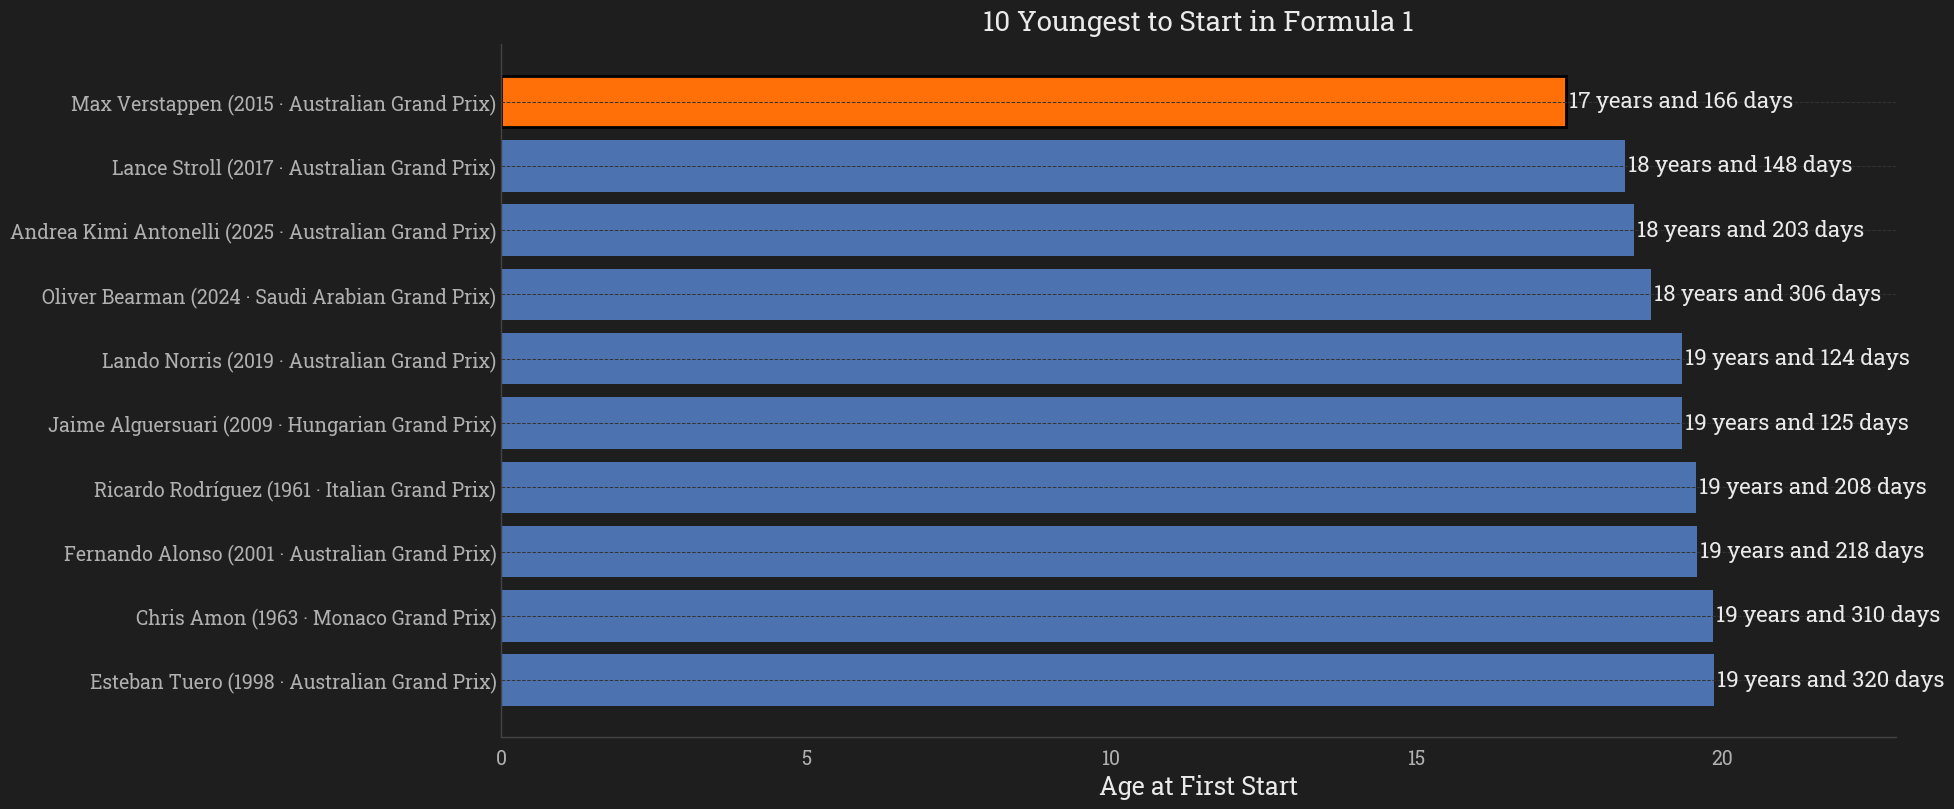

In [11]:
gera_graf_top_10_mais_jovens(
    df_top_10_jovens_largada, 
    "10 Youngest to Start in Formula 1", 
    "Age at First Start", "Verstappen",
    save_fig=True
    )

E vai além, ele não apenas possui essa marca considerando estréia, mas pra vitória na F1 também.

In [12]:
# Vamos gerar um dataset com a primeira vitória de cada piloto por idade no momento em que conquistou a sua vitória:

df_race_wins = df_races[df_races['finishing_position'] == 1].copy()

df_first_win = gerar_dataset_primeiro_evento(df_race_wins, df_drivers)

In [13]:
# Agora pego os 10 mais jovens:

df_top_10_jovens_vencedores = df_first_win.sort_values("idade_primeiro_evento").head(10)

Gráfico salvo em: b:\projetos\f1_analytics\grafs\10_youngest_to_win_in_formula_1_safe.png


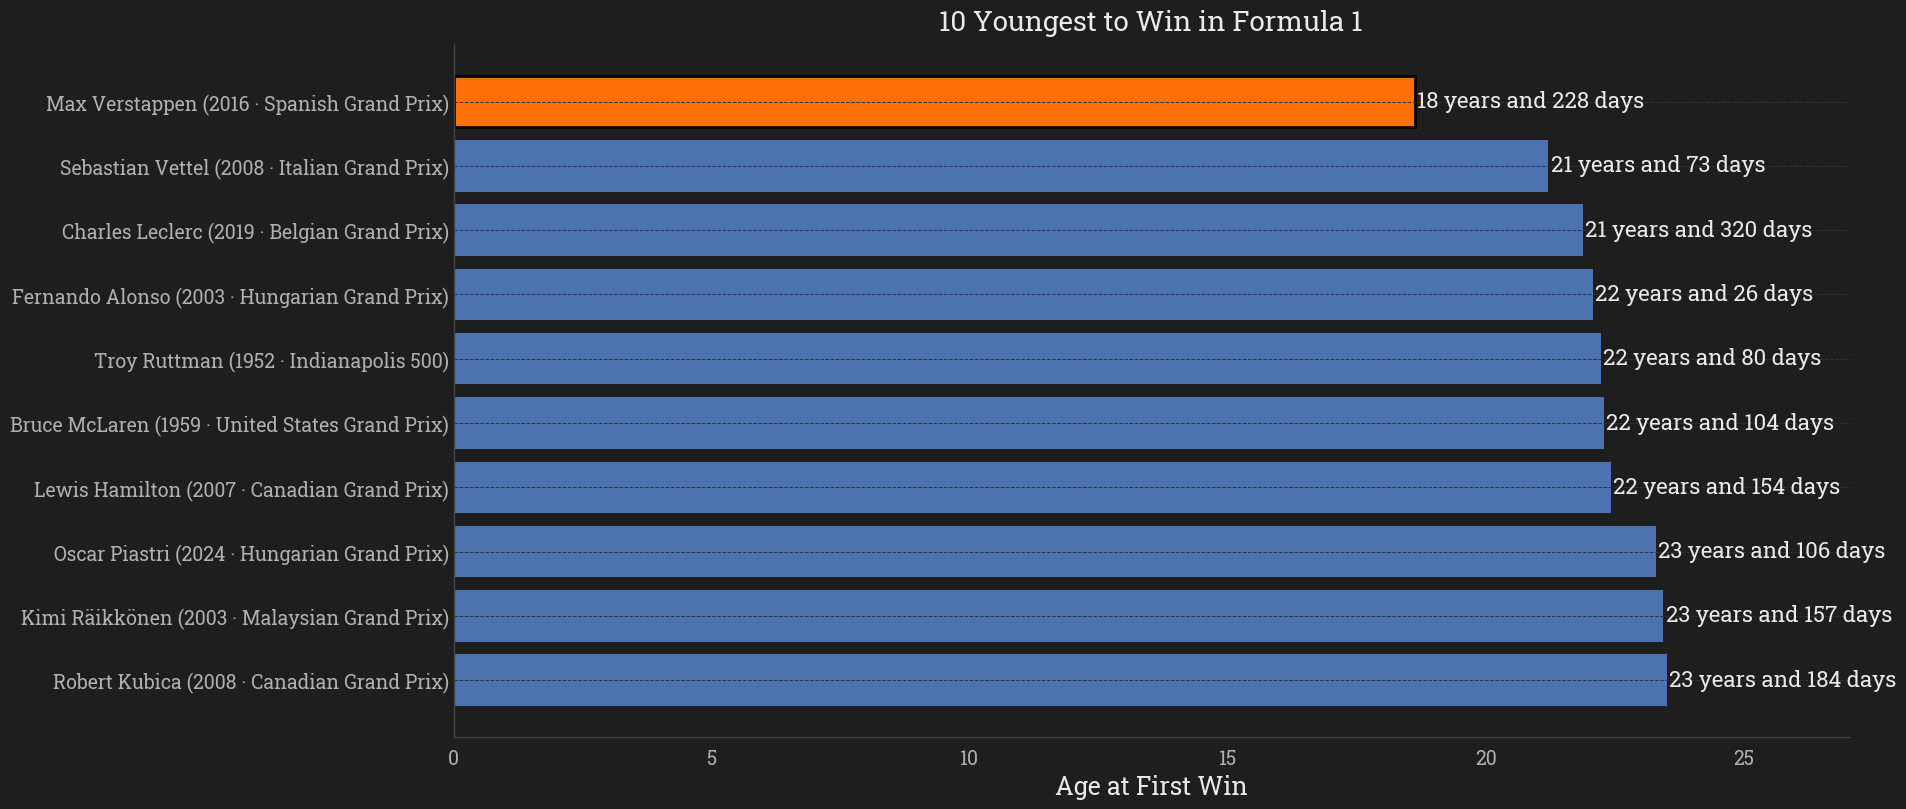

In [14]:
gera_graf_top_10_mais_jovens(
    df_top_10_jovens_vencedores, 
    "10 Youngest to Win in Formula 1", 
    "Age at First Win", 
    "Verstappen",
    save_fig=True
    )

## Mas... e desde então?

Beleza, acima conseguimos ver que o Verstappen não só foi o mais jovem estreante da F1 mas também foi o mais jovem a ganhar uma corrida, um ano após a sua estreia.

Mas, desde então, se fizermos uma visão geral dos números de vitórias, poles etc, Verstappen continua tendo marcas interessantes? Vamos dar uma olhada em alguns números gerais e a partir disso podemos ir aprofundando as nossas análises.

### Pole Positions:

In [15]:
df_pole_positions = df_races[df_races['starting_position'] == 1].copy()

df_pole_positions_agrup = df_pole_positions.groupby('driver_full_name').agg(
    {
        'race_name': 'count',
        'driver_age_at_race': 'max'
    }
).rename(columns={'race_name': 'pole_positions', 'driver_age_at_race': 'oldest_pole_position_age'}).reset_index().sort_values(by='pole_positions', ascending=False)

df_pole_positions_agrup

driver_full_name  pole_positions  oldest_pole_position_age
64       Lewis Hamilton             104                 38.537988
72   Michael Schumacher              68                 37.530459
4          Ayrton Senna              65                 34.110883
99     Sebastian Vettel              57                 32.279261
71       Max Verstappen              46                 27.975359
..                  ...             ...                       ...
104     Thierry Boutsen               1                 33.081451
105           Tom Pryce               1                 26.102669
108  Vittorio Brambilla               1                 37.571526
109       Walt Faulkner               1                 30.283368
110  Wolfgang von Trips               1                 33.352498

[111 rows x 3 columns]

Gráfico salvo em: b:\projetos\f1_analytics\grafs\top_10_drivers_in__of_pole_positions_safe.png


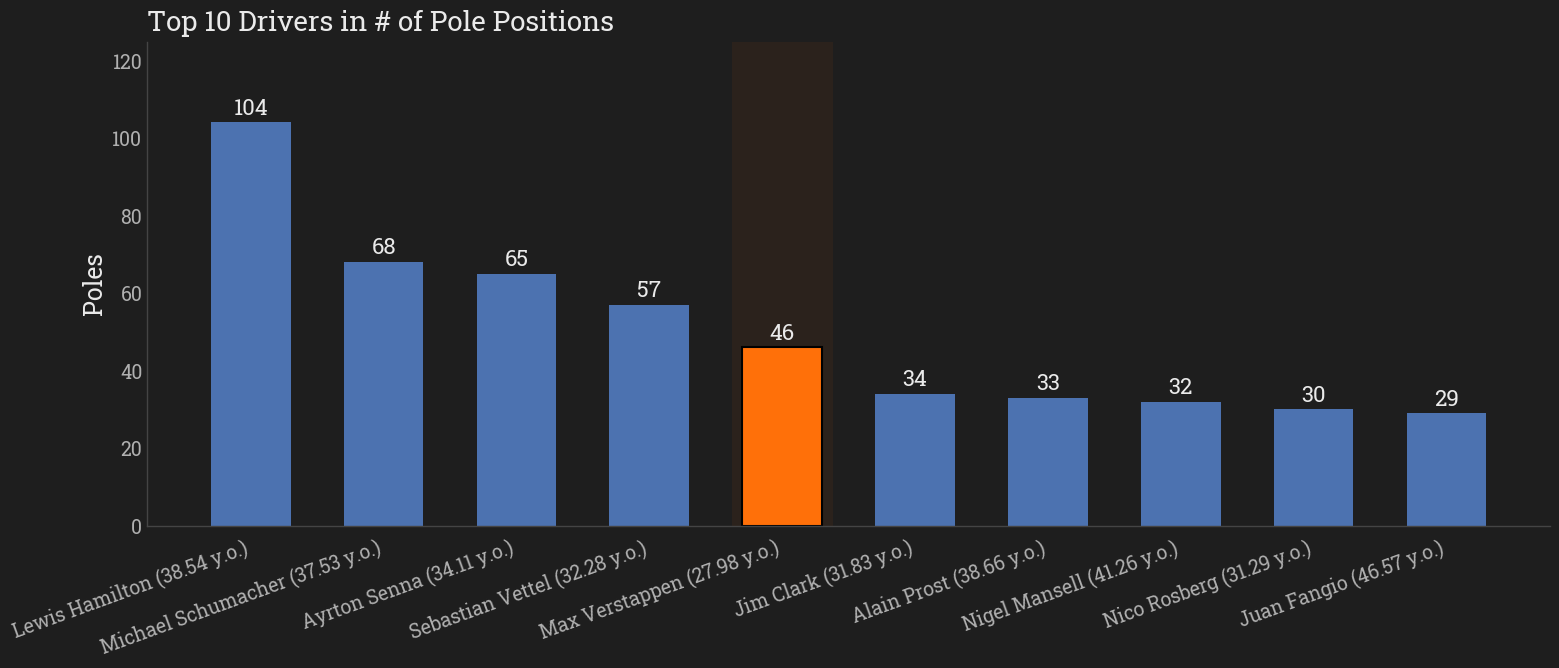

In [16]:
# Vamos tornar isso visual pra ficar mais fácil de expor a informação:

df_poles_top10 = df_pole_positions_agrup.head(10).copy()

df_poles_top10['nome_e_idade'] = df_poles_top10.apply(lambda row: f"{row['driver_full_name']} ({round(row['oldest_pole_position_age'], 2)} y.o.)", axis=1)

graf_top_pilotos(
    df_poles_top10,
    col_nome="nome_e_idade",
    col_valor="pole_positions",
    titulo="Top 10 Drivers in # of Pole Positions",
    xlabel="Poles",
    nome_a_destacar="Verstappen",
    orientation='vertical',
    save_fig=True
)


Acima não só podemos ver que o Verstappen é o número 5 em maior quantidade de pole positions na história da F1, como também ele é o mais jovem entre todos os pilotos que estão presentes na lista dos Top 10, sendo aproximadamente 5 anos mais jovem do que o 2o piloto mais jovem que seria o Nico Rosberg.

**Obs**.: a idade apresentada é a idade do piloto ao conseguir sua última pole presente na base de dados, faço assim pra tentar nivelar a comparação, ou seja, considero apenas a idade do piloto enquanto ele estava aumentando sua estatística de pole position.

O piloto que chega mais perto de Verstappen em termos de idade e que possui um volume bem considerável de pole positions seria o Leclerc, que cairia bem no Top 11. Porém, possui 26 pole positions, que equivale a 65% da quantidade de pole positions de Max Verstappen:

Gráfico salvo em: b:\projetos\f1_analytics\grafs\pole_positions_verstappen_vs_leclerc_safe.png


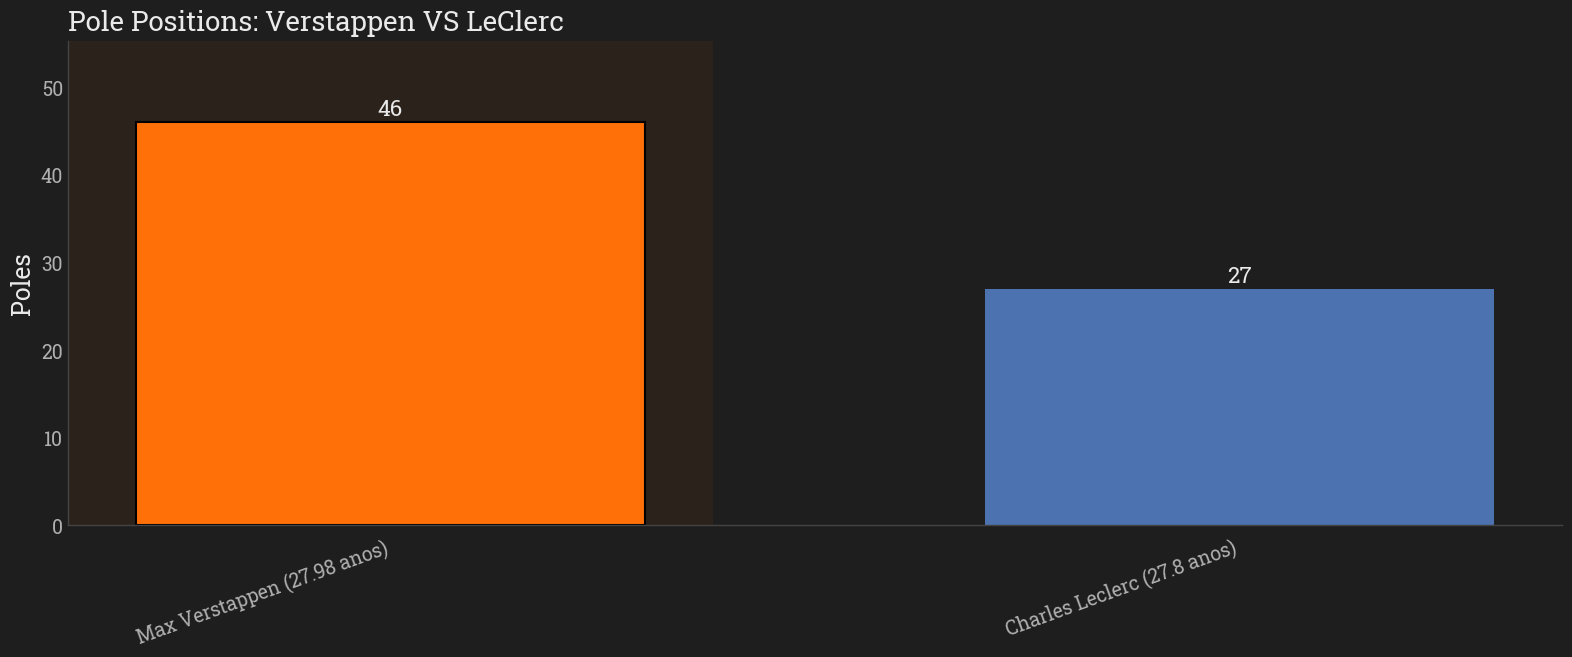

In [17]:
df_poles_ver_lec = df_pole_positions_agrup[df_pole_positions_agrup['driver_full_name'].str.contains('Verstappen|Leclerc', case=False, na=False)].copy()

df_poles_ver_lec['nome_e_idade'] = df_poles_ver_lec.apply(lambda row: f"{row['driver_full_name']} ({round(row['oldest_pole_position_age'], 2)} anos)", axis=1)

graf_top_pilotos(
    df_poles_ver_lec,
    col_nome="nome_e_idade",
    col_valor="pole_positions",
    titulo="Pole Positions: Verstappen VS LeClerc",
    xlabel="Poles",
    nome_a_destacar="Verstappen",
    orientation='vertical',
    save_fig=True
)


### Vitórias:

In [18]:
# Filtro a vitória a partir da posição de chegada:
df_race_wins = df_races[df_races['finishing_position'] == 1].copy()

# Agrupo pra calcular as métricas:
df_race_wins_agrup = df_race_wins.groupby('driver_full_name').agg(
    {
        'race_name': 'count',
        'driver_age_at_race': 'max'
    }
).rename(columns={'race_name': 'race_wins', 'driver_age_at_race': 'oldest_race_win_age'}).reset_index().sort_values(by='race_wins', ascending=False)

Gráfico salvo em: b:\projetos\f1_analytics\grafs\top_10_drivers_in__of_wins_safe.png


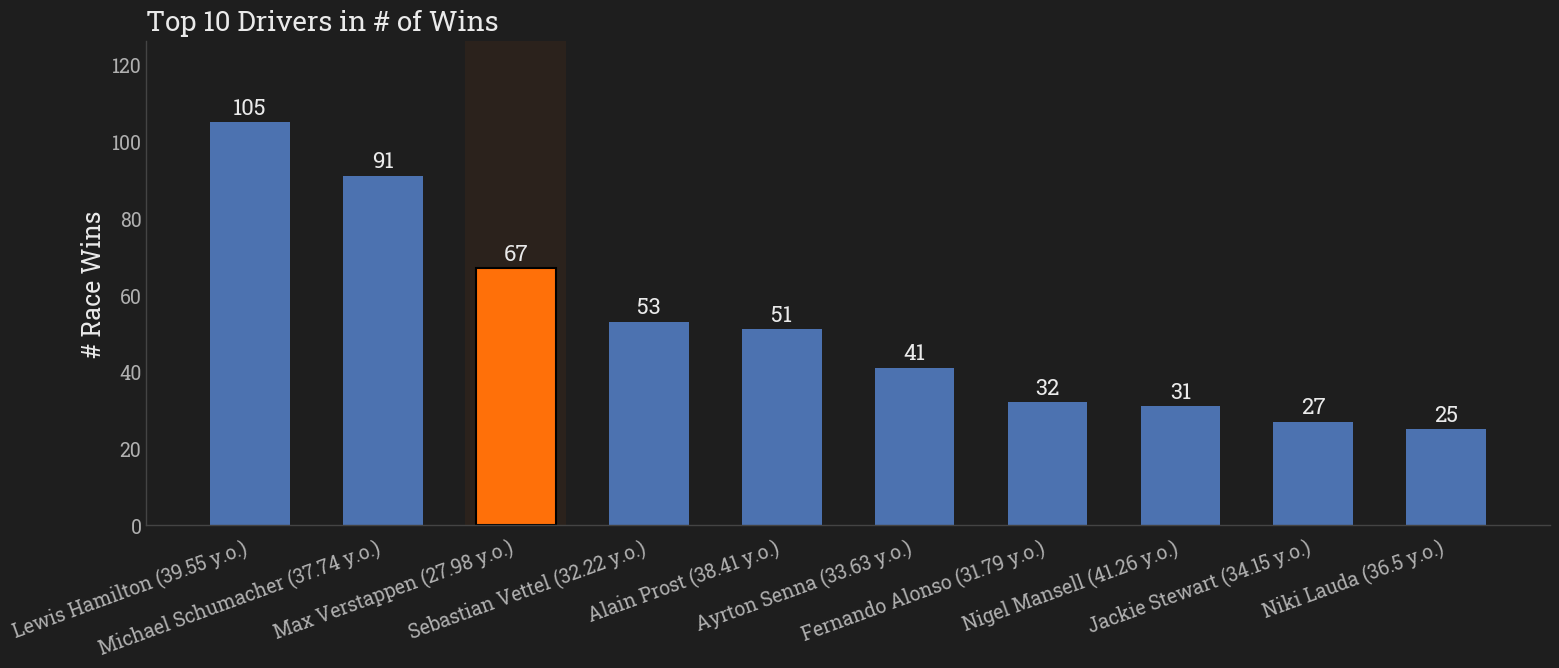

In [19]:
# Vamos tornar isso visual pra ficar mais fácil de expor a informação:

df_race_wins_top_10 = df_race_wins_agrup.head(10).copy()

df_race_wins_top_10['nome_e_idade'] = df_race_wins_top_10.apply(lambda row: f"{row['driver_full_name']} ({round(row['oldest_race_win_age'], 2)} y.o.)", axis=1)

graf_top_pilotos(
    df_race_wins_top_10,
    col_nome="nome_e_idade",
    col_valor="race_wins",
    titulo="Top 10 Drivers in # of Wins",
    xlabel="# Race Wins",
    nome_a_destacar="Verstappen",
    orientation='vertical',
    save_fig=True
)


Bom, eu acho que o gráfico acima nem precisa de muita explicação. Podemos ver que o Verstappen é o 3o piloto com maior número de vitórias da história e é o mais jovem por uma margem de 5 anos na lista, sendo que Vettel é o segundo mais jovem na lista de top 10, com 10 vitórias a menos ao final de 2024, ano no qual Vettel está aposentado e Verstappen continua correndo em 2025.

### E se olharmos em termos percentuais?

In [20]:
# Posso trazer a quantidade total de corridas de cada piloto pro dataset que usei pra ver as vitórias e calcular um percentual

df_driver_total_races = df_races.groupby('driver_full_name').agg({'race_name':'count'}).rename(columns={'race_name':'total_races'})


df_race_wins_agrup = pd.merge(
    left=df_race_wins_agrup,
    right=df_driver_total_races,
    on='driver_full_name',
    how='left'
)

df_race_wins_agrup['win_percentage'] = df_race_wins_agrup['race_wins'] / df_race_wins_agrup['total_races']

Gráfico salvo em: b:\projetos\f1_analytics\grafs\top_10_win_percentages_safe.png


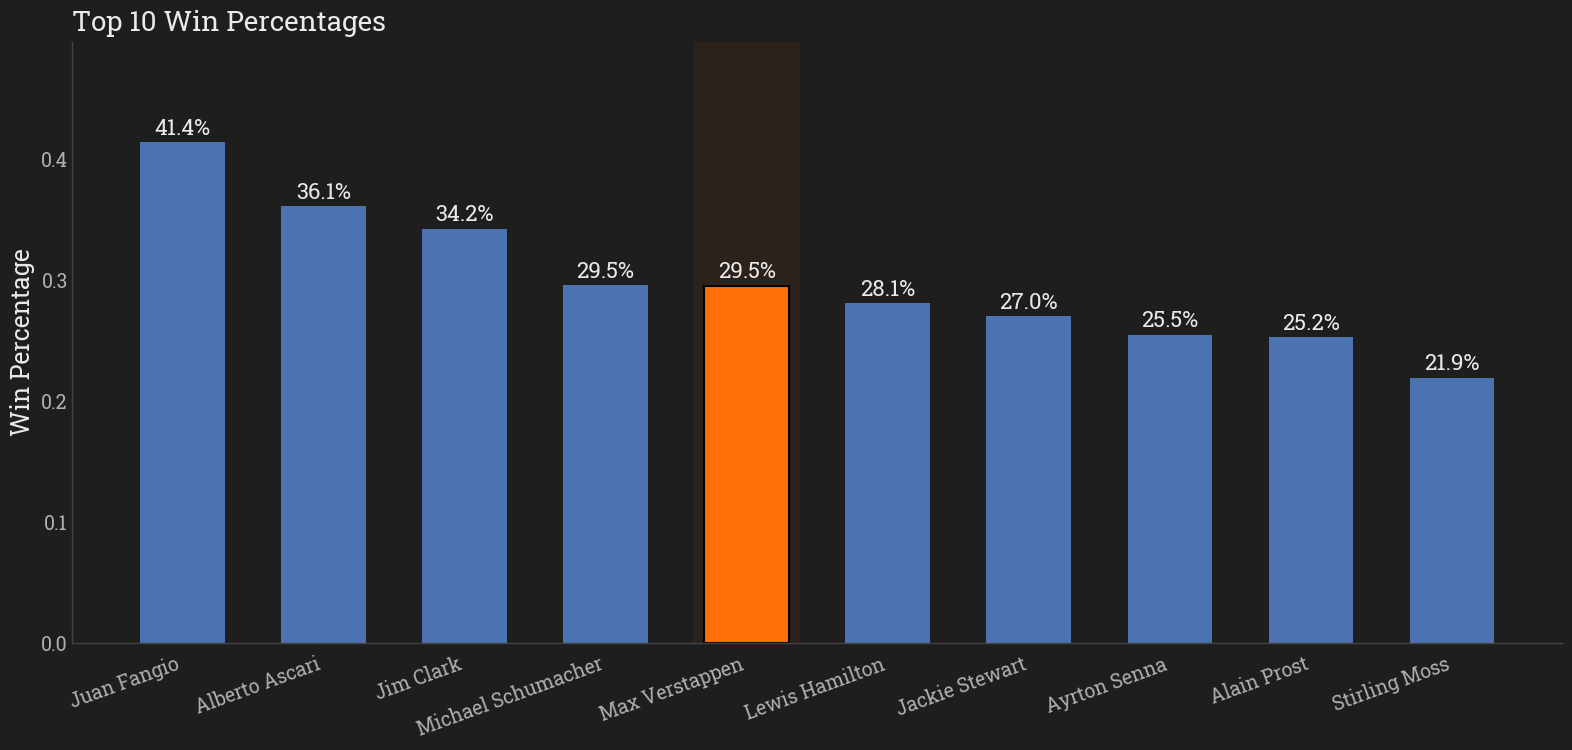

In [21]:
# Vamos dar uma olhada nos top 10 maiores percentuais de vitórias:

df_top_10_win_percentages = df_race_wins_agrup[
    df_race_wins_agrup['total_races'] > 30
].sort_values(by='win_percentage', ascending=False).head(10)

graf_top_pilotos(
    df_top_10_win_percentages,
    col_nome="driver_full_name",
    col_valor="win_percentage",
    titulo="Top 10 Win Percentages",
    xlabel="Win Percentage",
    nome_a_destacar="Verstappen",
    orientation='vertical',
    valor_format_str="{:.1%}",
    save_fig=True
)


Acima podemos ver os maiores percentuais de vitória da história da F1, mas no caso acima, os 3 primeiros pilotos não chegam nem perto das quantidades de corrida que Hamilton, VBerstappen e Schumacher tiveram ao longo das carreiras (tamo falando de gerações muito diferentes).

In [22]:
# Vamos dar uma olhada nos top 10 maiores percentuais de vitórias:

df_top_10_win_percentages = df_race_wins_agrup[
    df_race_wins_agrup['total_races'] > 100 # Aqui, tentando complicar um pouco a análise, vou trazer apenas pilotos que tem um grande número de corridas feitas
].sort_values(by='win_percentage', ascending=False).head(10)

Gráfico salvo em: b:\projetos\f1_analytics\grafs\top_10_win_percentages_100_races_safe.png


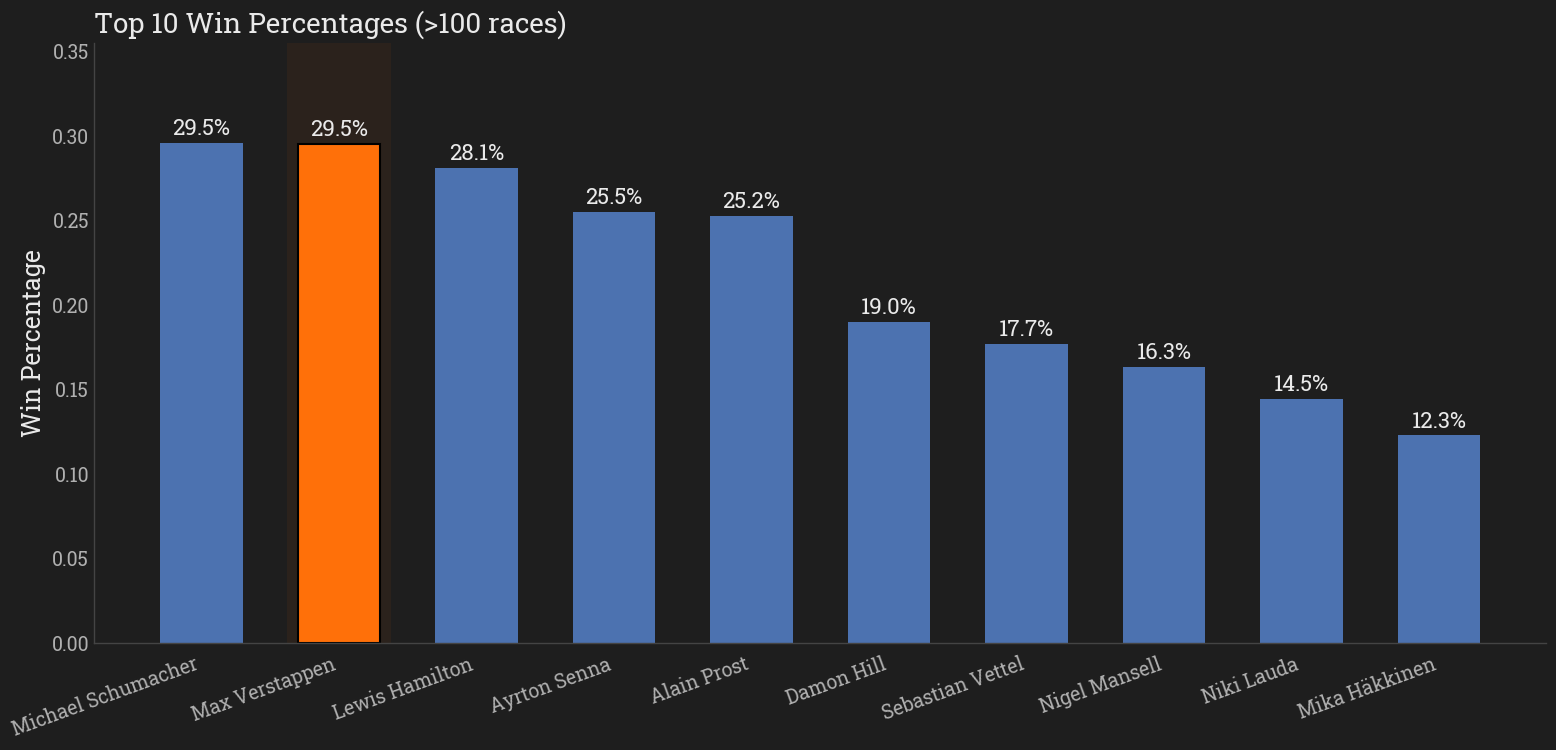

In [23]:
df_top_10_win_percentages['nome_e_idade'] = df_top_10_win_percentages.apply(lambda row: f"{row['driver_full_name']} ({round(row['oldest_race_win_age'], 2)} anos)", axis=1)

graf_top_pilotos(
    df_top_10_win_percentages,
    col_nome="driver_full_name",
    col_valor="win_percentage",
    titulo="Top 10 Win Percentages (>100 races)",
    xlabel="Win Percentage",
    nome_a_destacar="Verstappen",
    orientation='vertical',
    valor_format_str="{:.1%}",
    save_fig=True
)

Hoje, Verstappen está empatado em maior percentual de vitórias com ninguém mais ninguém menos do que Michael Schumacher

Gráfico salvo em: b:\projetos\f1_analytics\grafs\top_10_biggest_win_streaks_safe.png


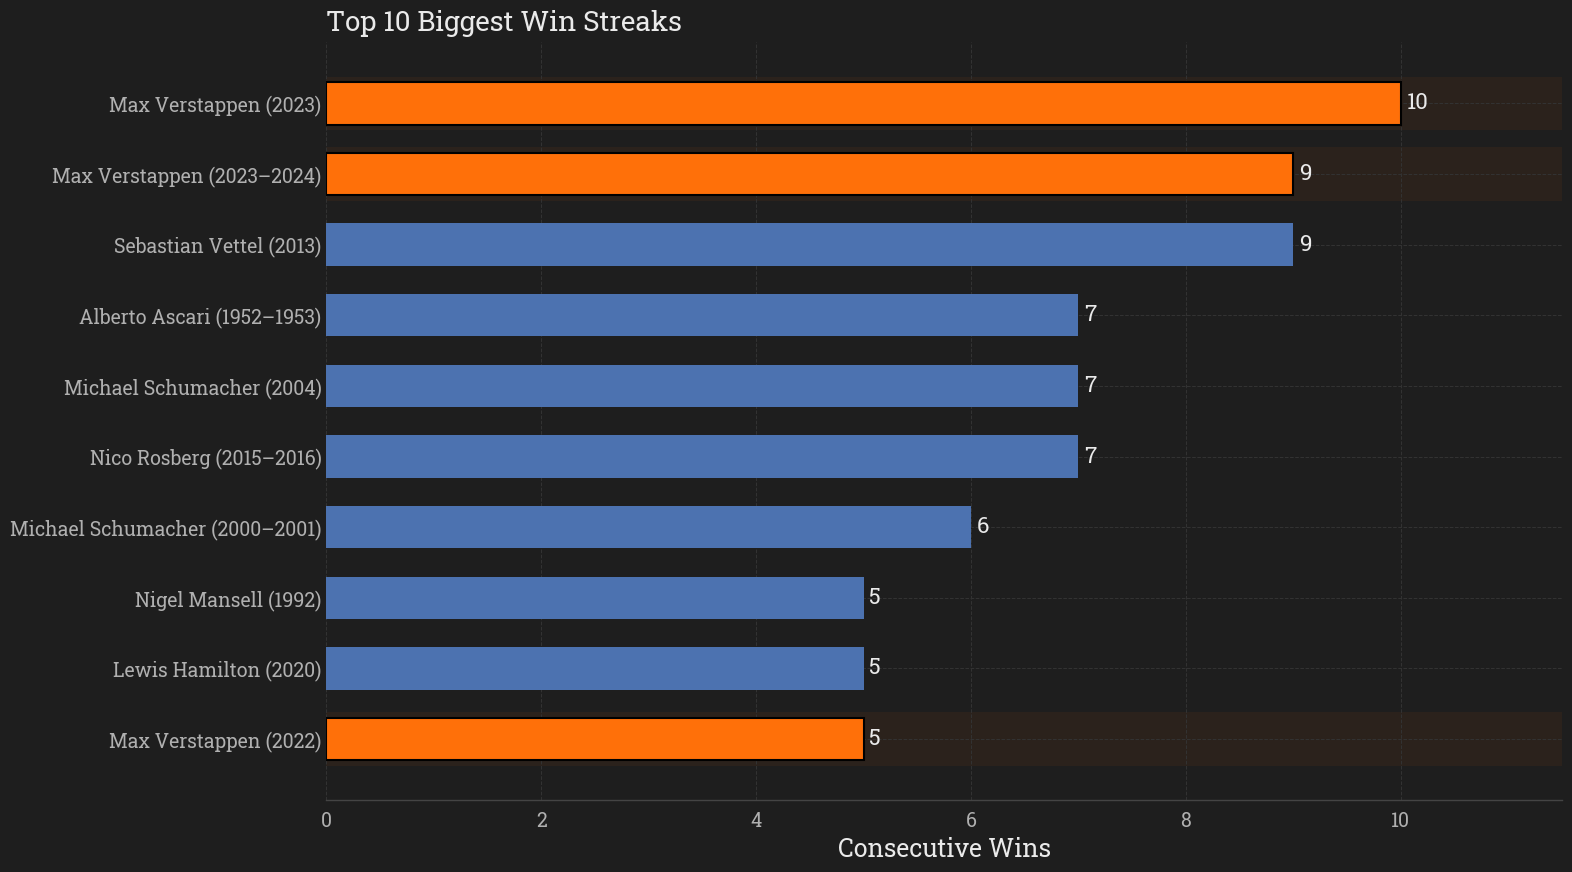

In [24]:
# --- Bloco de Análise: Top Maiores Sequências de Vitórias ---

# 1. Isolar todas as vitórias do dataset
df_wins = df_races[df_races['finishing_position'] == 1].copy()

# 2. Garantir a ordem cronológica e criar um ID de corrida global
# Usamos ngroup() para criar um ID numérico único para cada evento
df_wins = df_wins.sort_values(by=['year', 'race_date'])
df_wins['global_race_num'] = df_wins.groupby(['year', 'race_date']).ngroup()

# 3. Ordenar por piloto e depois pela corrida, para encontrar as sequências
df_wins_sorted = df_wins.sort_values(by=['driver_full_name', 'global_race_num'])

# 4. Identificar as "quebras" na sequência (Lógica de Gaps-and-Islands)
# Compara o ID da corrida atual com o ID da corrida anterior (por piloto)
df_wins_sorted['race_num_diff'] = df_wins_sorted.groupby('driver_full_name')['global_race_num'].diff()

# Uma nova sequência começa se a diferença for > 1 (não foi consecutiva) ou se for a primeira vitória (NaN)
df_wins_sorted['is_new_streak'] = (df_wins_sorted['race_num_diff'] > 1) | (df_wins_sorted['race_num_diff'].isna())

# Cria um ID de grupo para cada sequência (cada "ilha")
df_wins_sorted['streak_group'] = df_wins_sorted.groupby('driver_full_name')['is_new_streak'].cumsum()

# 5. Contar o tamanho de cada sequência
df_streaks = df_wins_sorted.groupby(
    ['driver_full_name', 'streak_group']
).agg(
    streak_count=('race_name', 'size'),
    ano_inicio=('year', 'min'), # Pega o ano em que a sequência começou
    ano_fim=('year', 'max')
).reset_index()

# 6. Preparar os dados para o plot
# Criamos um label (ex: "Sebastian Vettel (2013)")
df_streaks['label_nome'] = df_streaks['driver_full_name'] + " (" + df_streaks['ano_inicio'].astype(str) + ")"
# Se a sequência durou mais de 1 ano, ajusta o label
df_streaks.loc[df_streaks['ano_inicio'] != df_streaks['ano_fim'], 'label_nome'] = \
    df_streaks['driver_full_name'] + " (" + df_streaks['ano_inicio'].astype(str) + "–" + df_streaks['ano_fim'].astype(str) + ")"

# Pega as 10 maiores sequências da história
df_top_10_streaks = df_streaks.sort_values('streak_count', ascending=False).head(10)


# --- Plotando com sua função graf_top_pilotos ---

# (Assumindo que `fxns` foi importado e `graf_top_pilotos` está no seu utils.py)
graf_top_pilotos(
    df=df_top_10_streaks,
    top_n=10,
    col_nome="label_nome", # Usa o novo label que criamos
    col_valor="streak_count",
    titulo="Top 10 Biggest Win Streaks",
    xlabel="Consecutive Wins",
    nome_a_destacar="Max Verstappen", # O nome para destacar
    orientation="horizontal",
    valor_format_str="{:,.0f}", # Formato de número inteiro
    save_fig=True
)

Gráfico salvo em: b:\projetos\f1_analytics\grafs\top_10_most_dominant_f1_seasons_win__safe.png


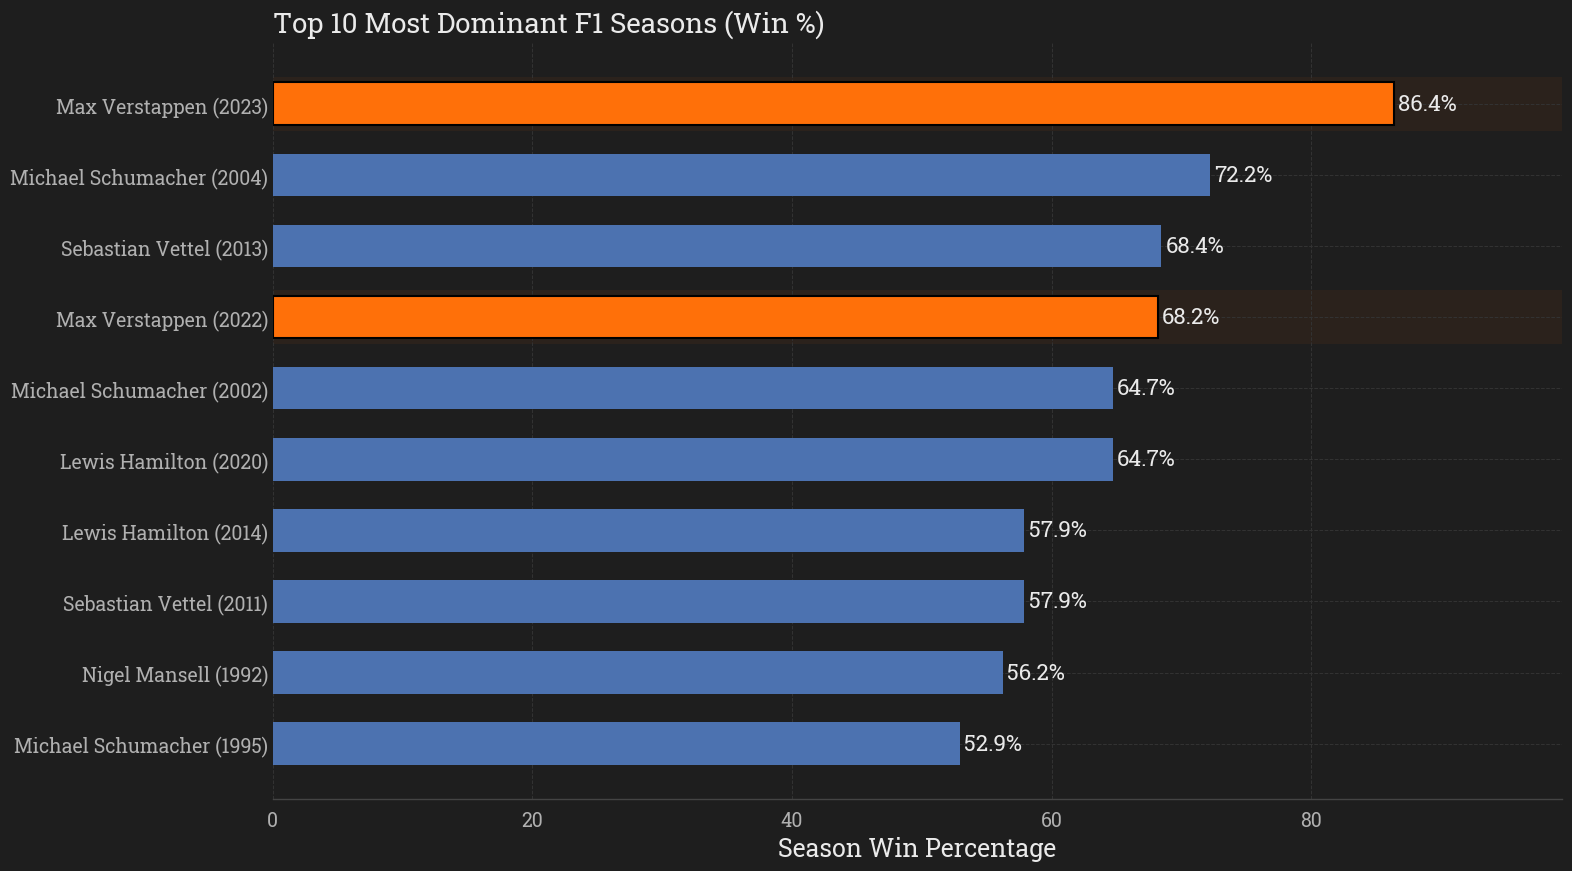

In [25]:
# --- Bloco de Análise: Top 10 Temporadas Mais Dominantes (% de Vitórias) ---

# 1. Calcula o total de corridas por temporada (o denominador)
# Usamos nunique() para contar eventos únicos
df_season_races = df_races.groupby('year')['race_name'].nunique().reset_index()
df_season_races = df_season_races.rename(columns={'race_name': 'total_season_races'})

# 2. Calcula as vitórias de cada piloto por temporada (o numerador)
df_driver_wins = df_races[df_races['finishing_position'] == 1].copy()
df_season_wins = df_driver_wins.groupby(['year', 'driver_full_name'])['race_name'].count().reset_index()
df_season_wins = df_season_wins.rename(columns={'race_name': 'driver_wins'})

# 3. Junta os dados
df_dominant_seasons = pd.merge(df_season_wins, df_season_races, on='year')

# 4. Calcula o percentual de vitórias
df_dominant_seasons['win_percentage'] = (df_dominant_seasons['driver_wins'] / df_dominant_seasons['total_season_races']) * 100

# 5. Filtra para manter temporadas com 16 ou mais corridas
# Isso remove as temporadas curtas (ex: 7 corridas em 1950) e torna a métrica comparável
df_dominant_seasons_filtered = df_dominant_seasons[df_dominant_seasons['total_season_races'] >= 16]

# 6. Pega o Top 10
df_top_10_dominant_seasons = df_dominant_seasons_filtered.sort_values('win_percentage', ascending=False).head(10)

# 7. Prepara o label para o gráfico (ex: "Max Verstappen (2023)")
df_top_10_dominant_seasons['label_nome'] = df_top_10_dominant_seasons['driver_full_name'] + \
                                          " (" + df_top_10_dominant_seasons['year'].astype(str) + ")"

# --- Plotando com sua função graf_top_pilotos ---

# (Assumindo que `fxns` foi importado e `graf_top_pilotos` está no seu utils.py)
graf_top_pilotos(
    df=df_top_10_dominant_seasons,
    top_n=10,
    col_nome="label_nome",
    col_valor="win_percentage",
    titulo="Top 10 Most Dominant F1 Seasons (Win %)",
    xlabel="Season Win Percentage",
    nome_a_destacar="Verstappen",
    orientation="horizontal",
    valor_format_str="{:,.1f}%", # Formato para percentual (ex: 86.4%)
    save_fig=True
)

# Mas e aí?

Todos esses números apresentados até agora são lindos e maravilhosos. Independente de qualquer contraponto, não há de se discutir que o Verstappen hoje em dia é um piloto mais do que consolidado e está entre os maiores nomes que a F1 já teve em sua história.

Porém... Tudo que trouxe até agora são só grandes números, estou comparando valores absolutos com outros pilotos sem isolar um grande fator: a equipe.

A F1, apesar de certas pessoas esquecerem às vezes, não é uma competição apenas entre pilotos, mas também uma competição de construtores (equipes), que acabam por influenciar muito o resultado individual de cada piloto, e aí a questão é a seguinte: como poderíamos tentar isolar esse fator em uma análise?

É muito difícil, mas acredito que com algumas premissas, consigo prosseguir a análise de forma a tentar fazer isso de duas formas: primeiro posso analisar a **consistência** de tempo de volta dos pilotos (um piloto bom tem que ser um piloto que consegue entregar resultado nos momentos mais importantes e que tem tempos de volta consistentes), e, além disso, podemos **comparar os pilotos diretamente com os companheiros de equipe que tiveram**, sendo que ambos possuem o mesmo equipamento (premissa importante).

Mas, antes de prosseguir, vale a ressalva: acredito que seja impossível, dado a forma que a F1 funciona, fazer uma análise que isole completamente o fator equipe do fator piloto, porque o piloto depende do carro pra correr e a equipe depende do piloto (obviamente), então eu faço o lembrete do aviso que dei no começo da análise: nenhum gráfico ou ponto individualmente tem um peso muito grande aqui, mas deve-se levar em conta a consistência e o padrão que vemos nos resultados conforme eu for apresentando novos dados.

Vamos pra análise de consistência e eu vou explicando conforme for evoluindo com as coisas:

## Análise de Consistência:

A ideia aqui vai ser tentar fazer uma análise da consistência do piloto ao longo das corridas que participou. E eu não quero fazer isso em torno de uma análise de resultados, mas sim de tempos de volta, porque resultados, novamente, podem ser muito influenciados por externalidades (questões mecânicas, performance da equipe etc), mas, em tese, quem tem mais influência na consistência do tempo de volta, seja ele bom ou ruim, é o piloto. Então vamos lá:

Passos para análise de consistência:

- Preciso remover voltas que não seriam interessantes eu considerar do dataset pra analisar apenas tempo de volta válida (não quero voltas lentas de SC, ou que o piloto tenha parado no Box poluindo a análise);
- Depois vou calcular o desvio padrão usando a window de prova e piloto (quero o desvio padrão que cada piloto teve em cada prova);
- Análise da distribuição desse desv. pad. -> A "largura" da distribuição vai nos dizer algo sobre a consistência;
- Análise da média do desvio padrão 0-> quanto maior a média, maior a inconsistência

Obs.: Não sei se vou conseguir fazer uma análise da base toda de uma vez, porque vai ter pilotos com poucas corridas etc que vão atrapalhar a análise. Nesse caso, possivelmente só vai fazer sentido eu comparar pilotos diretamente comparáveis da era atual e nomes maiores que sabemos que são considerados grandes pilotos da F1.

Se não ficou claro o que eu coloquei acima, vou explicar novamente conforme eu for tratando o dataset e construindo a análise abaixo.

### Fazendo o tratamento do dataset:

#### Primeiro quero tentar tirar as voltas de *Safety Car*: 

Vou tentar fazer isso por meio de uma abordagem "heurística" (porque não tenho nenhuma indicação disso no meu dataset): Eu vou calcular a mediana do tempo de volta de uma corrida e vou comparar com a volta do piloto usando um *threshold*, quando o tempo de volta ultrapassar esse valor (que acontece quando a volta, em tese, é BEM mais lenta que uma volta normal), e vou colocar a condição pra verificar que seja uma volta em que o piloto não perdeu posições (se ele rodou, o tempo de volta vai ser maior mas ele vai ter perdido posições, se for um SC por um motivo externo, ele não deveria perder posições).

Dessa forma (digo isso depois de ter feito essa análise algumas vezes e olhado repetidamente o dataset resultante), acredito que eu tenha conseguido, da melhor forma que pensei, retirar voltas que são lentas por motivos de corrida, mas ao mesmo tempo, manter voltas em que o piloto possa ter cometido algum erro ou então ter sido mais lento por falta de consistência mesmo. Ou seja, erros que o piloto cometeu serão "punidos" por meio da forma que estou fazendo esta análise.

In [26]:
df_lap_times = identificar_voltas_safety_car(
    df_laps=df_lap_times,
    threshold_percent=1.20 # Pra eu considerar como volta de SC, o ritmo tem que ter diminuído em pelo menos 20% (chute com critério, quero uma volta que é "bem" mais lenta que uma volta regular)    
    )

# Aqui existe o 107% que seria baseado na regra de pace da F1, mas a ideia aqui é tentar não filtrar voltas de erro individual e também de voltas mais lentas onde pode haver chovido e dpeois secado etc

b:\projetos\f1_analytics\src\analysis\verstappen_analysis\utils.py:84: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  is_lap_before_sc = df_out.assign(_is_sc_lap=is_sc_lap).groupby(group_cols)['_is_sc_lap'].shift(-1).fillna(False)


In [27]:
# Vamos fazer um "check de sanidade" nessa flag que eu acabei de criar:

df_check_sc = df_lap_times.groupby(
    by=[
        'race_name',
        'race_date',
        'is_safety_car_lap'
    ]
).agg({
    'lap_time_ms':'mean'
}).reset_index()

In [28]:
df_check_sc.sort_values('lap_time_ms', ascending=False)

race_name  race_date  is_safety_car_lap   lap_time_ms
313    British Grand Prix 2014-07-06               True  3.041607e+06
365   Canadian Grand Prix 2011-06-12               True  6.014643e+05
747  Malaysian Grand Prix 2012-03-25               True  5.616817e+05
707     Korean Grand Prix 2010-10-24               True  3.078142e+05
811     Monaco Grand Prix 2011-05-29               True  2.644613e+05
..                    ...        ...                ...           ...
112   Austrian Grand Prix 2019-06-30              False  7.058727e+04
110   Austrian Grand Prix 2018-07-01              False  7.047956e+04
108   Austrian Grand Prix 2017-07-09              False  7.041059e+04
985    Styrian Grand Prix 2020-07-12              False  7.003729e+04
863     Sakhir Grand Prix 2020-12-06              False  5.969034e+04

[1052 rows x 4 columns]

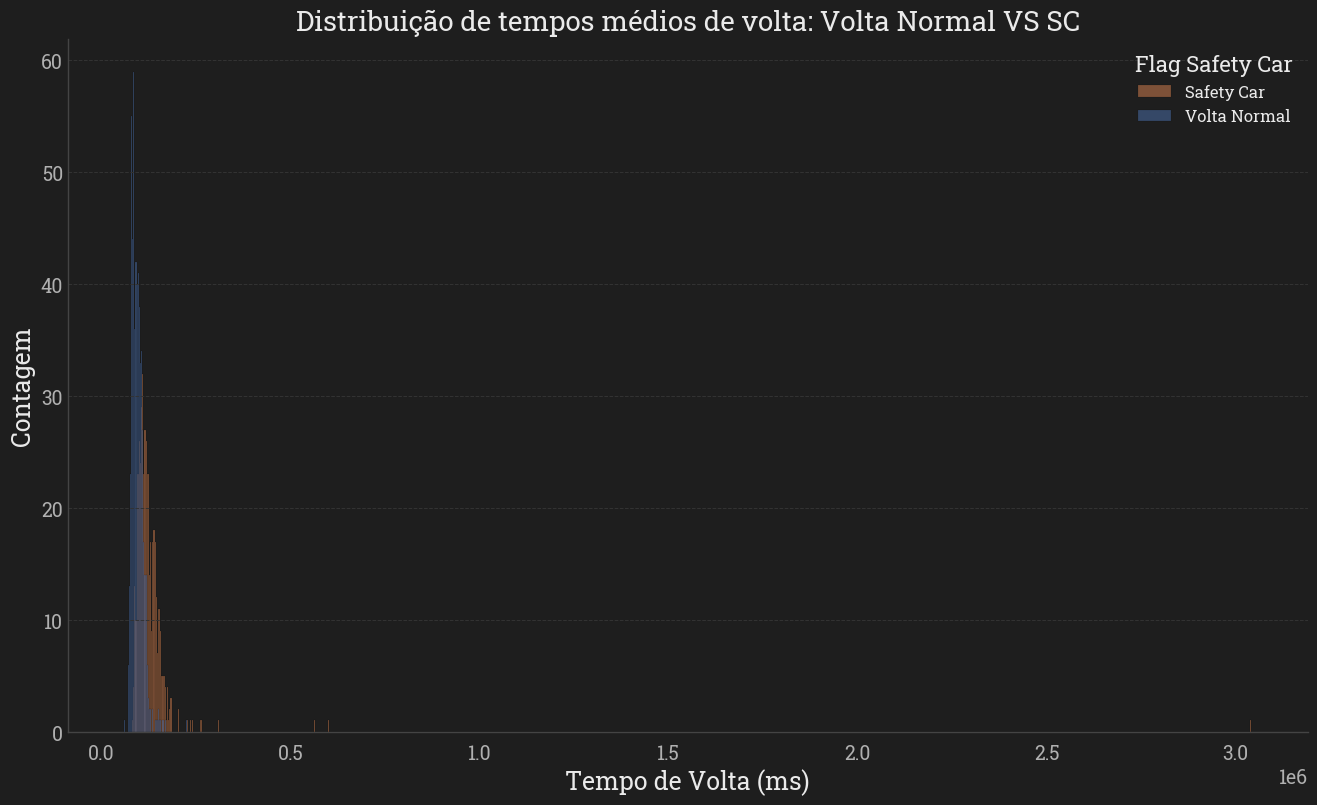

In [29]:
fig, ax = plt.subplots(figsize=(16,9))

sns.histplot(
    data=df_check_sc,
    x='lap_time_ms',
    hue='is_safety_car_lap',
    bins=1000,
    ax=ax
)

ax.set_title('Distribuição de tempos médios de volta: Volta Normal VS SC')
ax.set_xlabel('Tempo de Volta (ms)')
ax.set_ylabel('Contagem')
ax.legend(title='Flag Safety Car', labels=['Safety Car', 'Volta Normal'])

É difícil fazer uma validação plena da informação acima, mas, vendo o gráfico, conseguimos observar que as voltas classificadas como lentas (Safety Car) estão mais esparsas e mais lentas que as voltas normais, que são maiores em quantidade e mais concentradas, o que vai em linha com o esperado, portanto, considero que a flag está fazendo sentido no momento.

### Removendo voltas a serem desconsideradas na análise:

Na minha visão, para análises de tempo de volta, tenho que tirar:
- Voltas de SC, que foi as que indicamos acima;
- Primeiras voltas, sendo que não são representativas do ritmo de corrida ao longo das demais voltas;
- Voltas em que o piloto parou no pit stop ou saiu do pit stop, e isso, conseguimos ter a indicação a partir do dataset de pit stop, sendo que previamente já incluimos uma flag pra identificar esses casos;
- Removo eventos em que o piloto não terminou (geralmente a última volta possui valores bem elevados nesses casos).

In [30]:
df_lap_times_valid = filtrar_voltas_para_analise(df=df_lap_times)

### Criando uma métrica de consistência

Agora que tenho o meu dataset "limpo", vou tentar calcular a consistência do piloto por meio do desvio padrão (é uma métrica de variação) do tempo de volta de cada piloto em cada etapa. A ideia aqui é a seguinte:

- Analisar a distribuição do desvio padrão -> Quanto mais agrupada a distribuição em menores valores, significa que o piloto é mais consistente entre as diferentes corridas.
- Analisar a média do desvio padrão -> Quanto menor o o valor, significa que o piloto possui maior consistência entre as diferentes corridas.

A questão (depois de já ter tentado fazer essa análise algumas vezes) é que algumas corridas tem um desvio padrão de tempo de volta muito alto por natureza, e isso acaba atrapalhando bem a análise em certas comparações (corridas em que há mudança de clima possuem um alto desvio padrão natural embutido), então, o que terei que fazer é uma espécie de **"normalização relativa"** dos desvios padrões da seguinte forma:

- Calcularei os desvios padrões de cada piloto em cada evento, e farei a média geral desses valores também, irei então, calcular a diferença entre o desvio padrão do piloto e a média dos desvios padrões entre os pilotos, assim, eu vou beneficiar os pilotos que possuirem maior consistência (menor variação do tempo de volta) contra a variação "inerente" (representada pela média dos desvios padrões).

Vamos lá e vou tentar deixar claro conforme eu for chegando em conclusões:

In [31]:

# Vou agrupar o dataset, calculando tempo de volta médio e desvio padrão para cada piloto, em cada corrida
df_lap_times_std = (
    df_lap_times_valid.groupby(['race_name', 'year', 'driver_full_name'])['lap_time_ms']
    .agg(['std', 'mean'])
    .rename(columns={'std': 'lap_time_std', 'mean': 'lap_time_mean'})
    .reset_index()
)

# Aí aqui eu calculo o desvio padrão médio de todos os pilotos pra cada corrida
df_lap_times_std['lap_time_std_mean'] = df_lap_times_std.groupby(['race_name', 'year'])['lap_time_std'].transform('mean')

# Crio minha métrica de consistência, fazendo a diferença entre o desvio padrão do piloto contra o desvio padrão geral
df_lap_times_std['lap_time_std_driver_vs_mean'] = df_lap_times_std['lap_time_std'] - df_lap_times_std['lap_time_std_mean']

# Se o valor resultante é negativo, significa que o desvio padrão do piloto é menor que o médio, ou seja, foi mais consistente
df_lap_times_std

race_name  year driver_full_name  lap_time_std  \
0     70th Anniversary Grand Prix  2020  Alexander Albon   1549.280959   
1     70th Anniversary Grand Prix  2020     Carlos Sainz   1092.583107   
2     70th Anniversary Grand Prix  2020  Charles Leclerc   1102.407961   
3     70th Anniversary Grand Prix  2020     Daniil Kvyat   1271.997637   
4     70th Anniversary Grand Prix  2020     Esteban Ocon   1102.583734   
...                           ...   ...              ...           ...   
5352     United States Grand Prix  2024   Max Verstappen    724.766712   
5353     United States Grand Prix  2024  Nico Hülkenberg   1248.924967   
5354     United States Grand Prix  2024    Oscar Piastri   1125.157024   
5355     United States Grand Prix  2024     Pierre Gasly   1007.196723   
5356     United States Grand Prix  2024     Sergio Pérez   1118.916827   

      lap_time_mean  lap_time_std_mean  lap_time_std_driver_vs_mean  
0      91788.659574        1120.971797                   428.309162  
1      92355.744681        1120.971797                   -28.388690  
2      91942.979592        1120.971797                   -18.563837  
3      92375.425532        1120.971797                   151.025840  
4      92689.326531        1120.971797                   -18.388063  
...             ...                ...                          ...  
5352   99301.780000        1115.039457                  -390.272744  
5353  100093.760000        1115.039457                   133.885510  
5354   99355.720000        1115.039457                    10.117567  
5355  100499.840000        1115.039457                  -107.842734  
5356  100076.460000        1115.039457                     3.877370  

[5357 rows x 7 columns]

Antes de qualquer coisa, vamos dar uma olhada na consistência do Verstappen pra eu explicar o que estou tentando analisar:

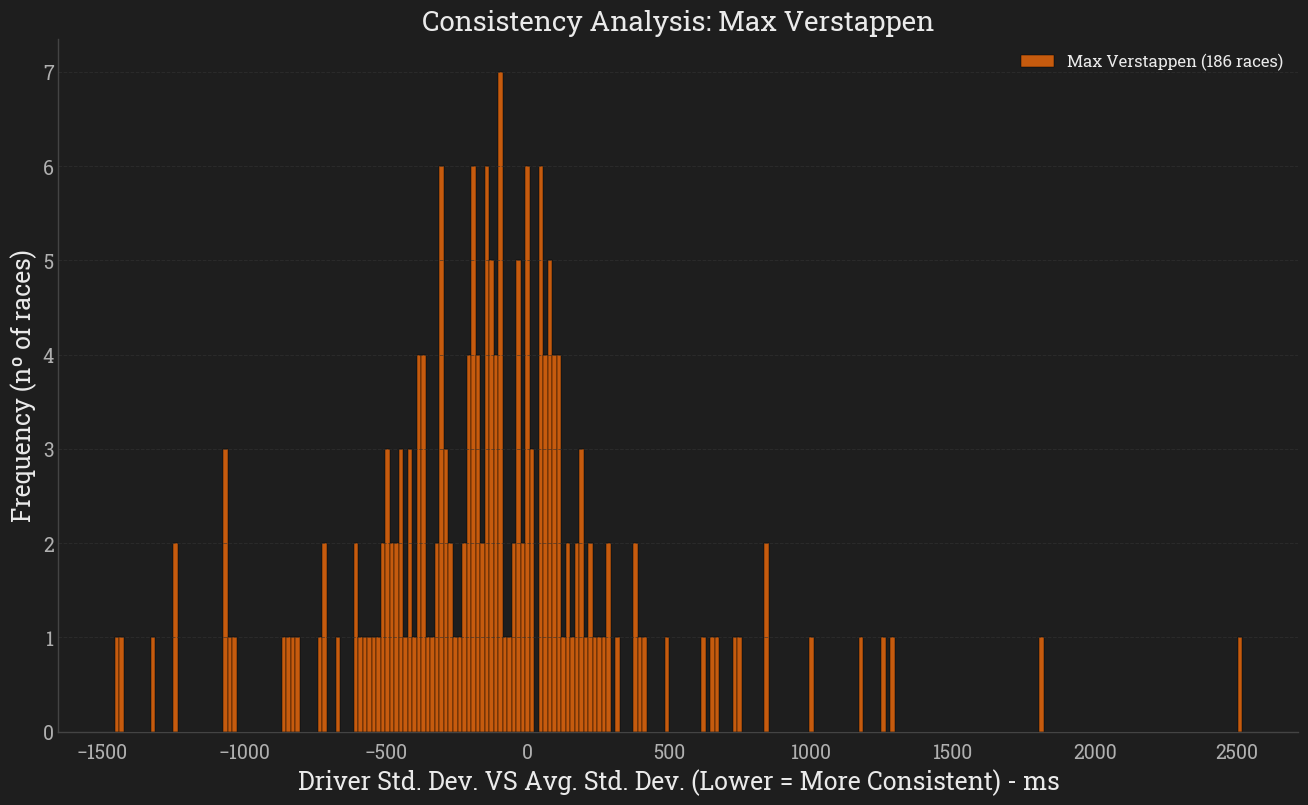

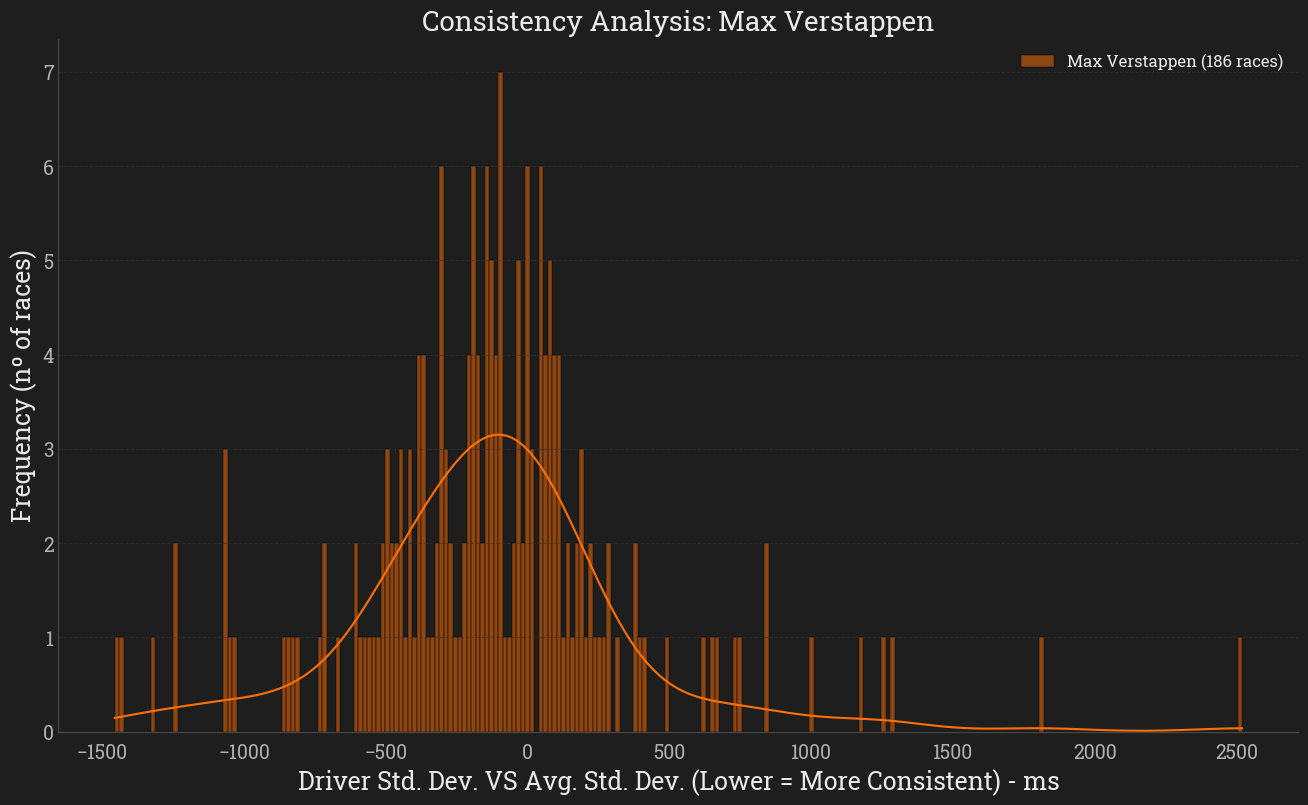

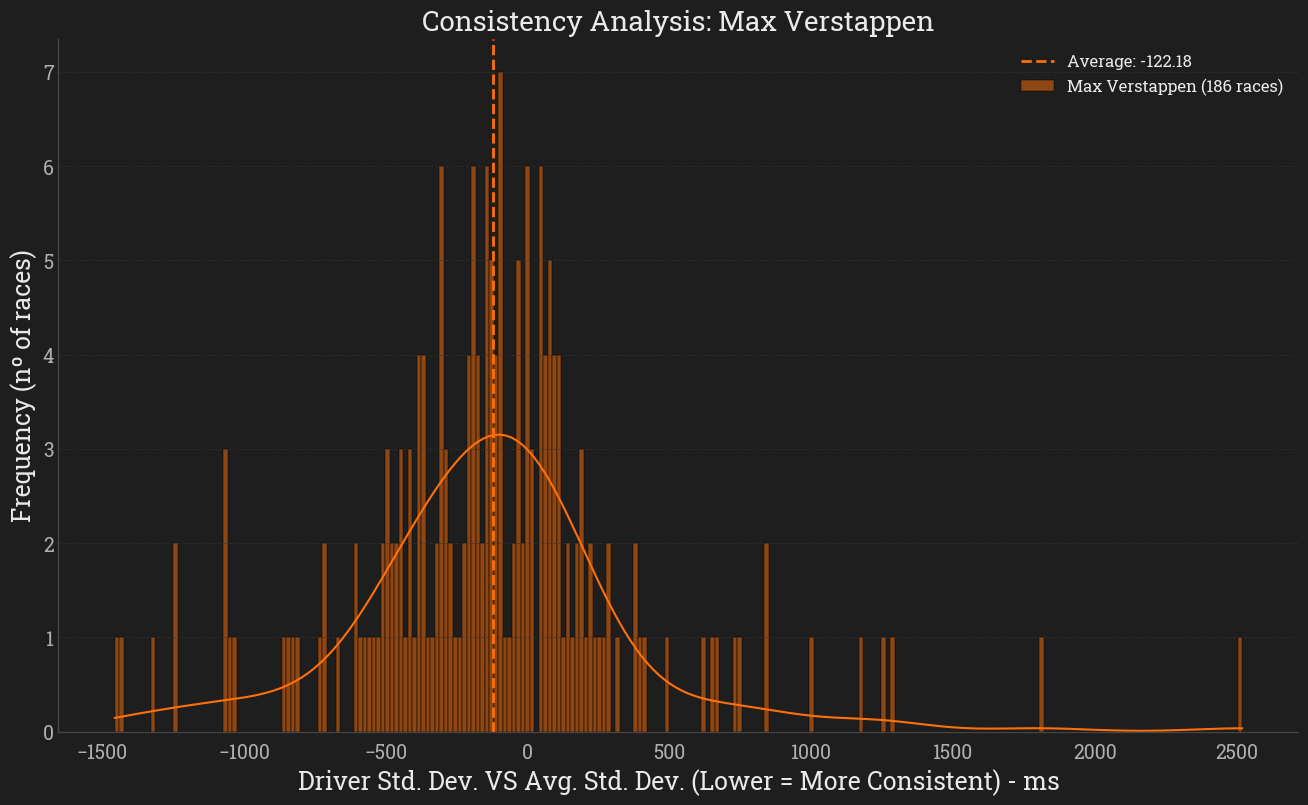

In [32]:
df_plot = df_lap_times_std[df_lap_times_std['driver_full_name'].isin(['Max Verstappen'])]
cor_base = "#FF7009"
media_base = df_plot[df_plot['driver_full_name'] == 'Max Verstappen']['lap_time_std_driver_vs_mean'].mean()
n_corridas_base = len(df_plot[df_plot['driver_full_name'] == 'Max Verstappen'])

titulo = "Consistency Analysis: Max Verstappen"
xlabel = "Driver Std. Dev. VS Avg. Std. Dev. (Lower = More Consistent) - ms"
ylabel = "Frequency (nº of races)"
base_filename = "grafs/consistency_analysis_max_verstappen_safe"


# --- Gráfico 1: Histograma Apenas (Step 1) ---
fig, ax = plt.subplots(figsize=(16,9))

sns.histplot(data=df_plot, x='lap_time_std_driver_vs_mean', bins=250, 
             kde=False, # Sem KDE
             ax=ax, color=cor_base,
             label=f'Max Verstappen ({n_corridas_base} races)') # Adiciona o label

ax.set_title(titulo)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend()

fig.savefig(f"{base_filename}_step1.png", bbox_inches='tight', pad_inches=0.1)
plt.show()


# --- Gráfico 2: Histograma + KDE (Step 2) ---
fig, ax = plt.subplots(figsize=(16,9))

sns.histplot(data=df_plot, x='lap_time_std_driver_vs_mean', bins=250, 
             kde=True, # Adiciona o KDE
             ax=ax, color=cor_base,
             label=f'Max Verstappen ({n_corridas_base} races)')

ax.set_title(titulo)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend()

fig.savefig(f"{base_filename}_step2.png", bbox_inches='tight', pad_inches=0.1)
plt.show()


# --- Gráfico 3: Completo (Step 3) ---
fig, ax = plt.subplots(figsize=(16,9))

sns.histplot(data=df_plot, x='lap_time_std_driver_vs_mean', bins=250, 
             kde=True, 
             ax=ax, color=cor_base,
             label=f'Max Verstappen ({n_corridas_base} races)')

# Adiciona a linha vertical da Average
ax.axvline(media_base, color=cor_base, linestyle='--', linewidth=2, 
           label=f'Average: {media_base:.2f}')

ax.set_title(titulo)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend() # O ax.legend() agora pega os dois labels automaticamente

fig.savefig(f"{base_filename}_step3.png", bbox_inches='tight', pad_inches=0.1)
plt.show()

#### Vou explicar o que eu estou trazendo aqui acima:

Neste gráfico, visualizamos a distribuição do 'lap_time_std_driver_vs_mean' para Max Verstappen. Essa métrica representa a diferença entre o desvio padrão de Max Verstappen e o desvio padrão médio de todos os pilotos em determinado evento (Consistência Individual VS Consistência Geral).

A linha vertical tracejada indica a média dos valores de 'lap_time_std_driver_vs_mean' de Verstappen. Uma média menor que 0, que é o caso de Verstappen, significa que ele tende a ser mais consistente que a média dos pilotos, porque a média do desvio padrão dele é menor do que a média do desvio padrão geral.

Ou seja, amostras à esquerda dessa linha representam corridas em que o piloto foi mais consistente que a média, e os valores à direita indicam corridas em que a consistência foi abaixo da média (desvio padrão maior que a média). O ideal é observar uma concentração maior de corridas à esquerda, sinalizando que, na maior parte do tempo, o piloto manteve um desempenho consistente, em que seus tempos de volta variaram menos que a média. 

**Importante**: os dados que estou olhando no momento **não** refletem a RAPIDEZ do piloto, mas sim são um reflexo de CONSISTÊNCIA. Ou seja, valores a esquerda não significam voltas mais rápidas, mas sim que os tempos de volta oscilaram menos do que de outros pilotos. Vou olhar performance, tempos de volta de uma outra forma logo depois...

### Comparando com outros pilotos

Agora que expliquei o que estou tentando fazer aqui, eu posso fazer comparação entre a distribuição que vimos acima de Verstappen, com uma média menor do que 0 e com uma distribuição aparentemente concentrada em torno do 0, com demais pilotos, vendo como as coisas se comparam.

O que queremos ver aqui decorre do que expliquei acima:

- Menor média = maior consistência
- Distribuição concentrada = pouca variação do tempo de volta e pequena quantidade de erros
- Amostras presentes mais à esquerda = consistência maior que a média
- Amostras à direita = pior consistência do que a média e possível presença de erros
- Cauda alongada à direita = possíveis amostras nas quais o piloto cometeu algum erro e perdeu posições

etc...

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_lewis_hamilton_safe.png


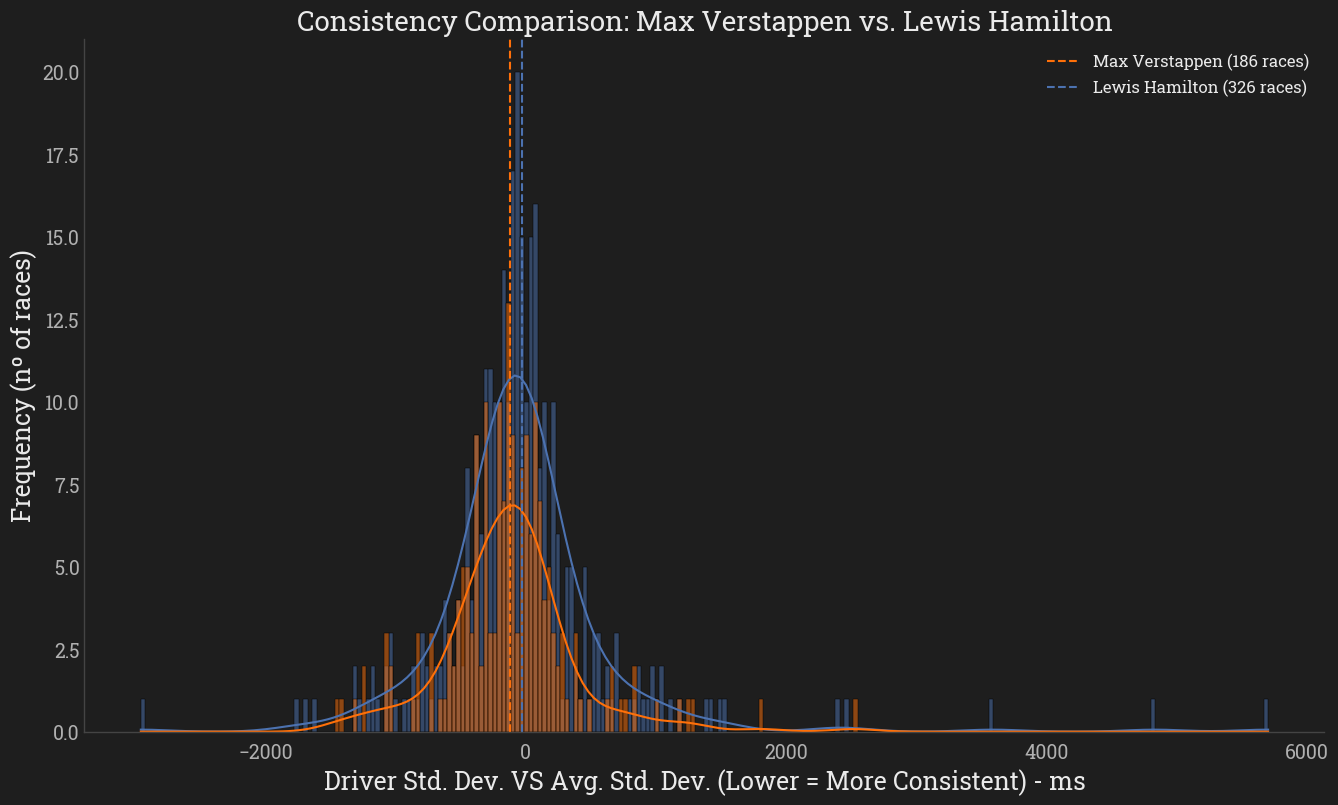

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_sebastian_vettel_safe.png


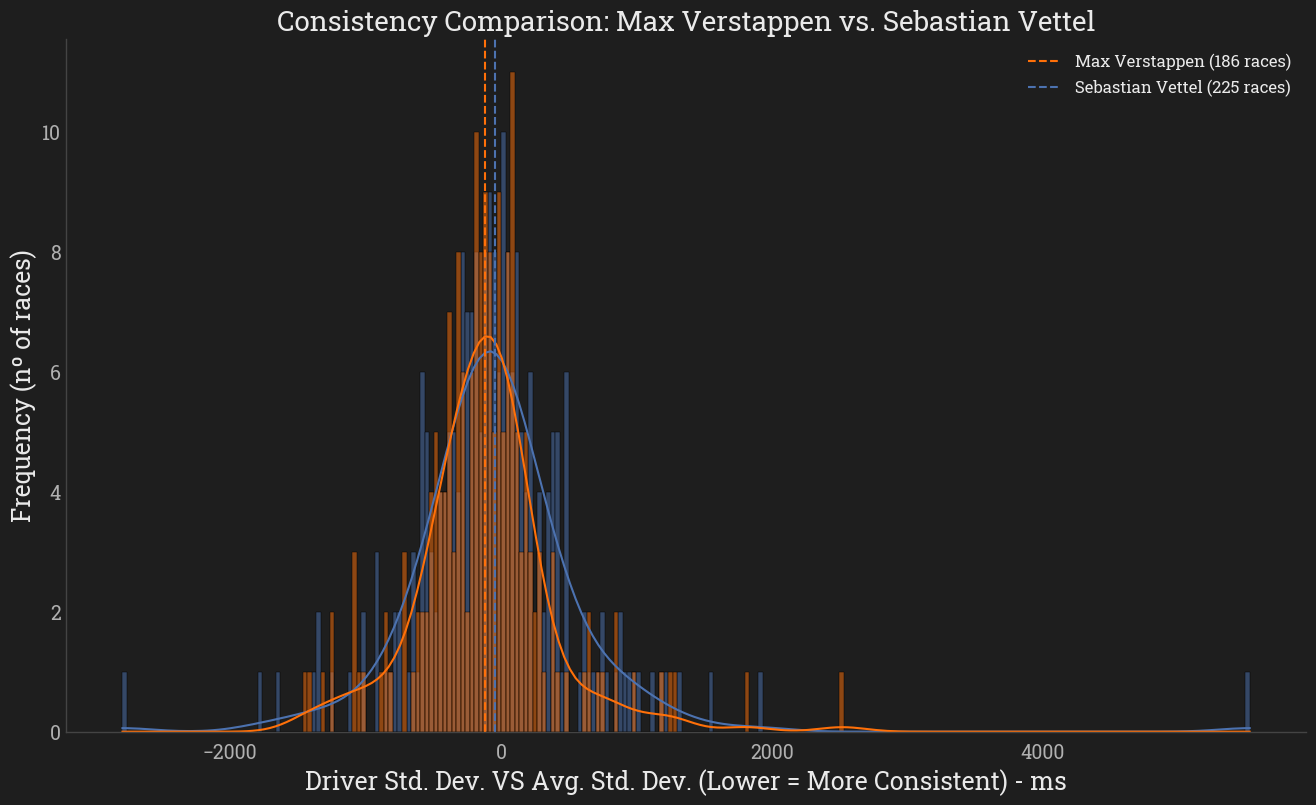

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_fernando_alonso_safe.png


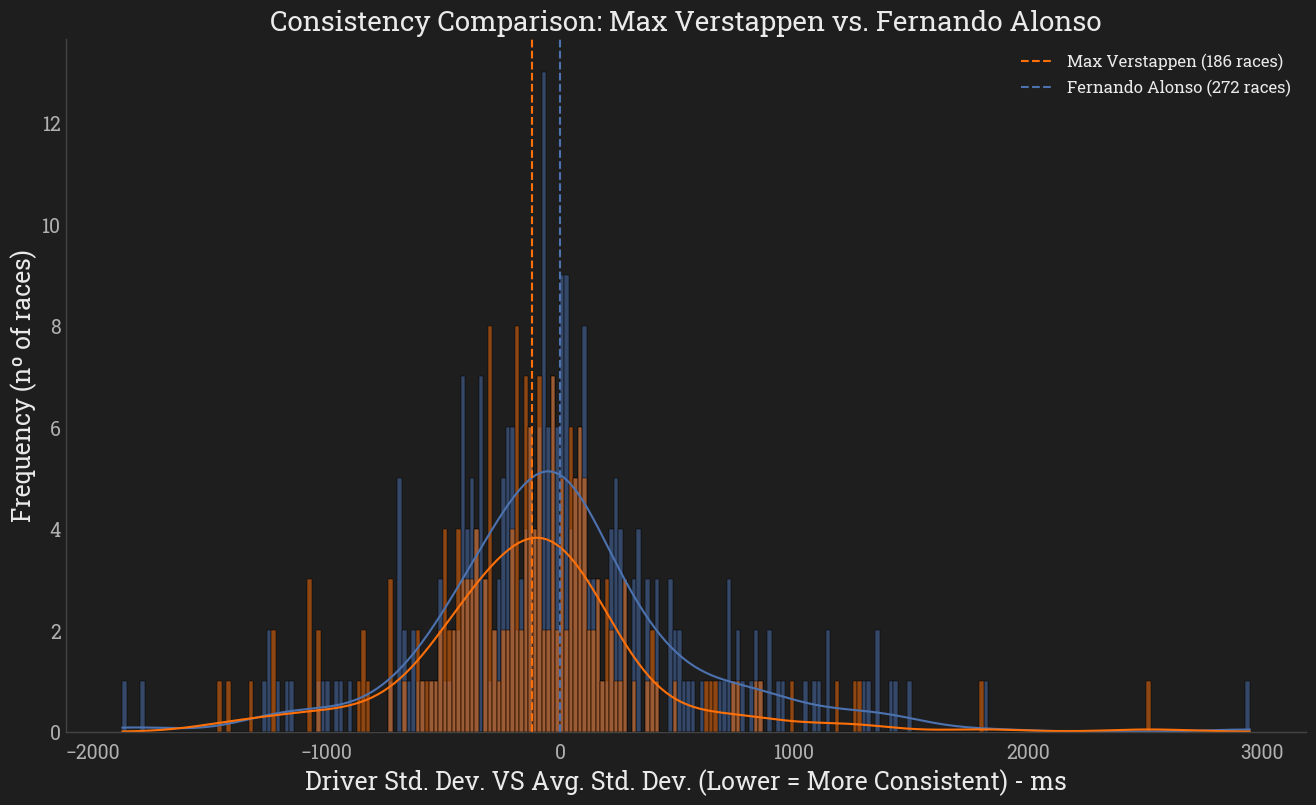

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_nico_rosberg_safe.png


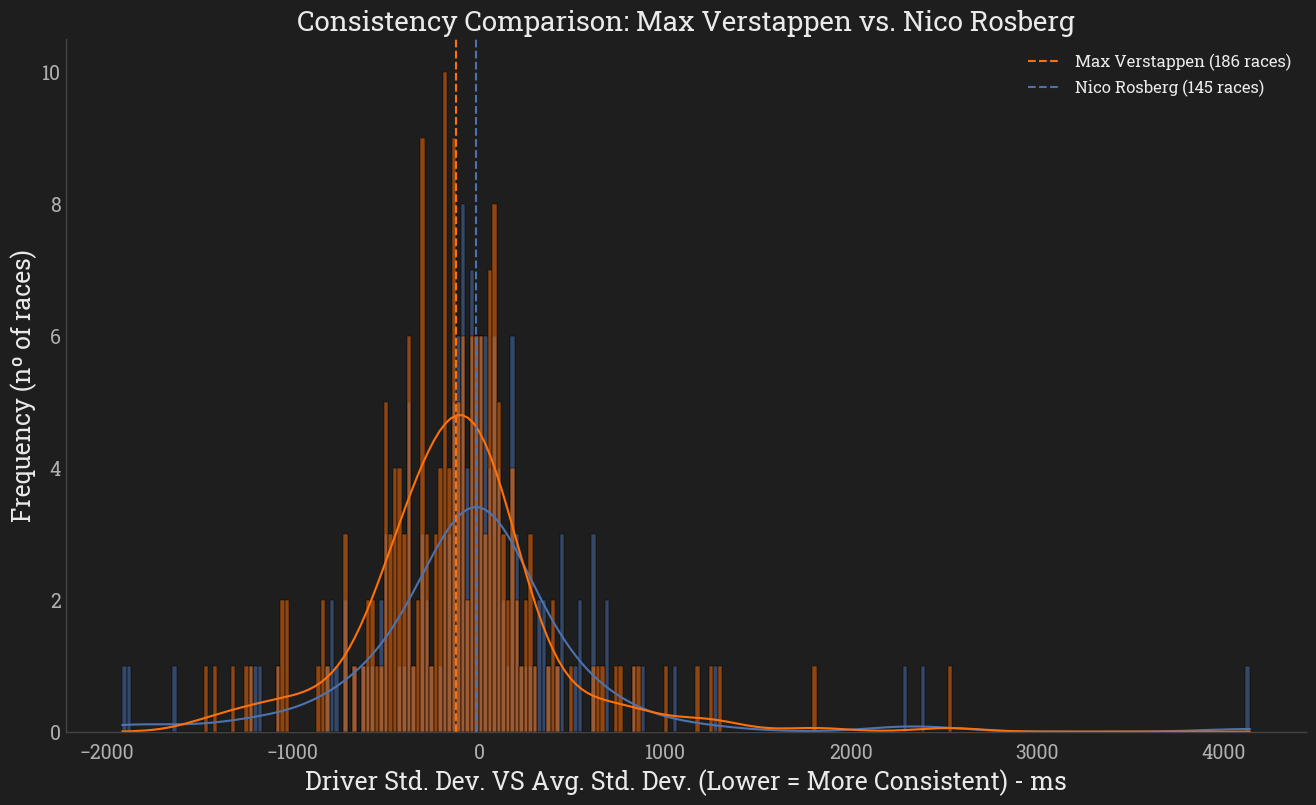

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_kimi_räikkönen_safe.png


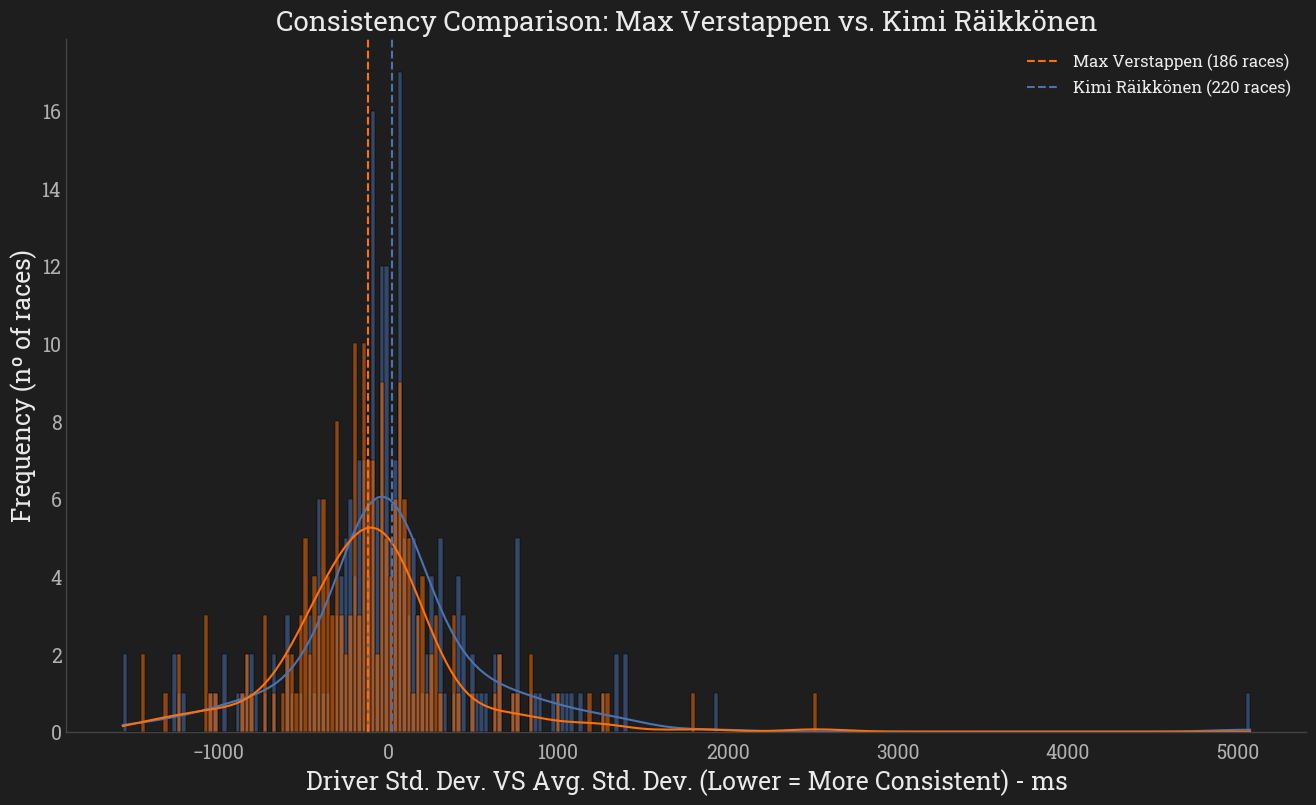

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_sergio_pérez_safe.png


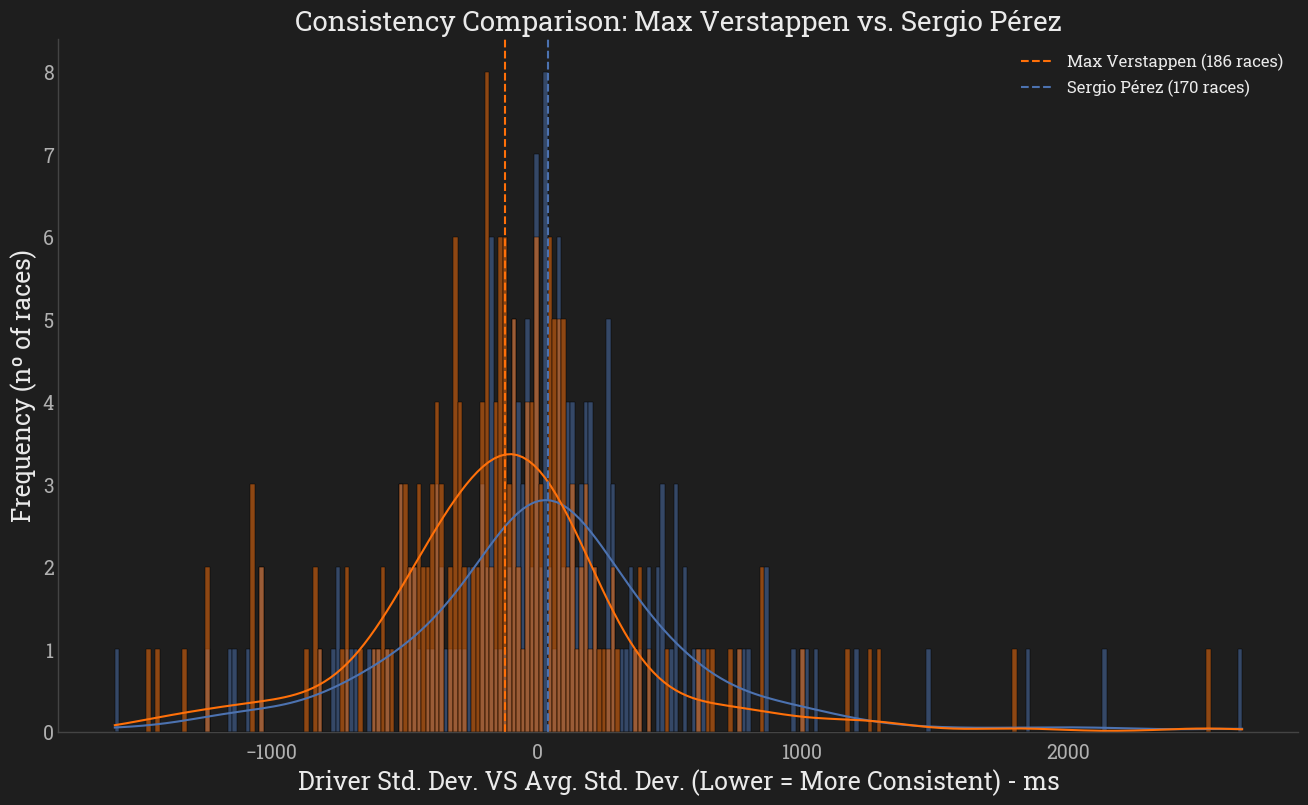

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_daniel_ricciardo_safe.png


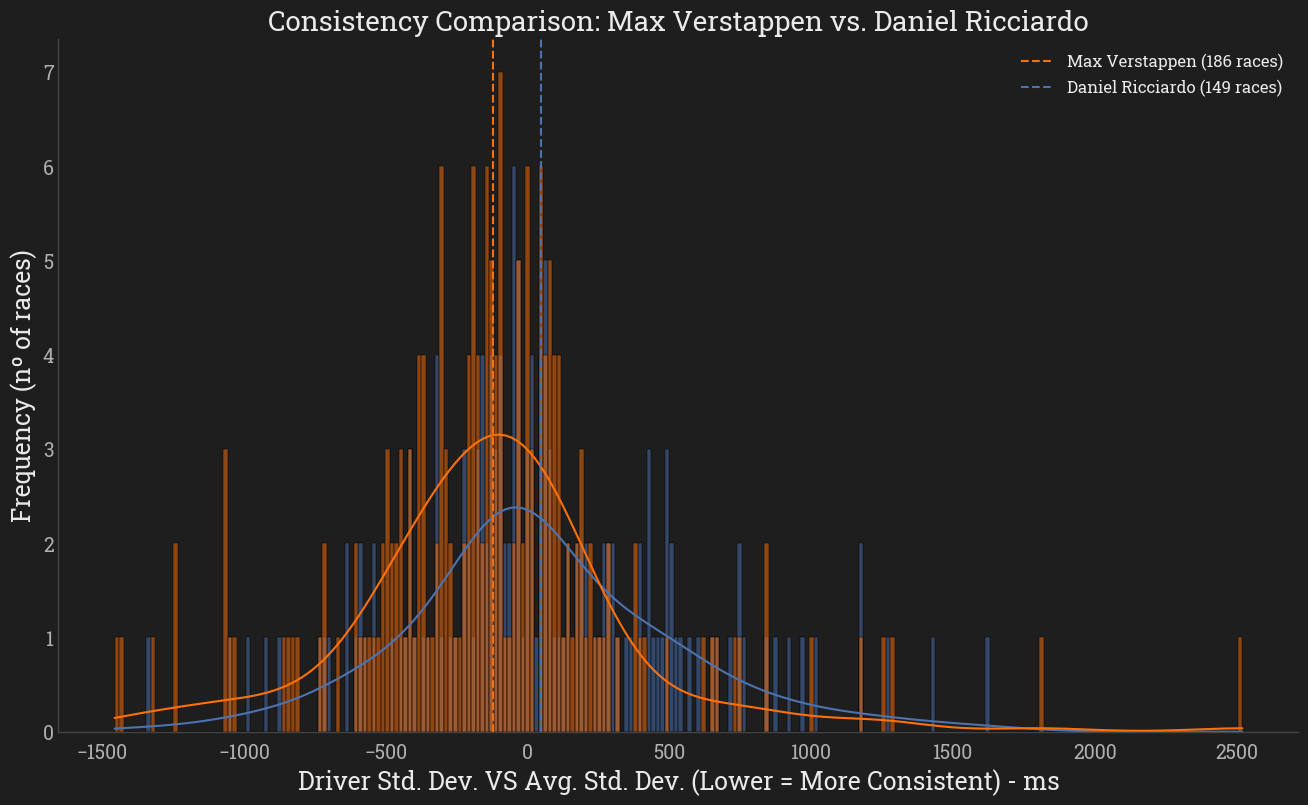

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_alexander_albon_safe.png


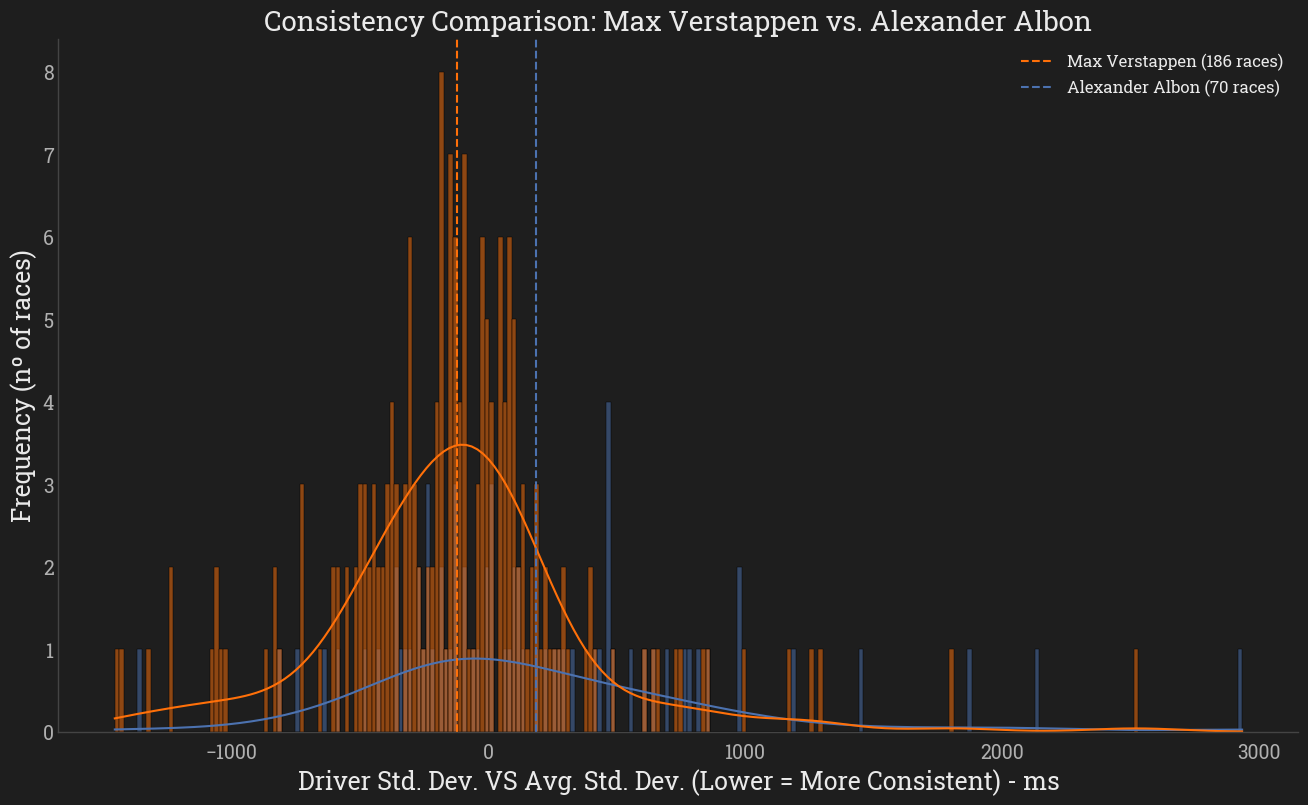

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_pierre_gasly_safe.png


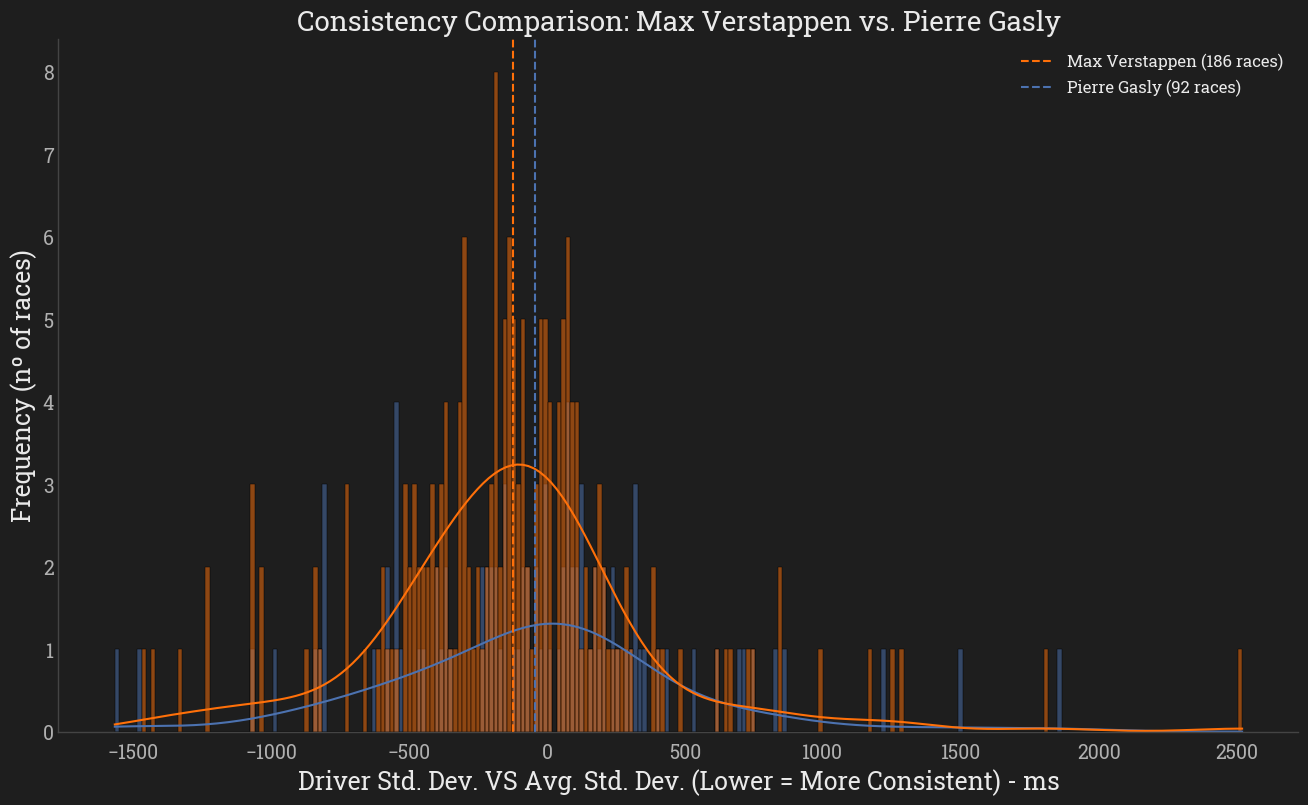

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_carlos_sainz_safe.png


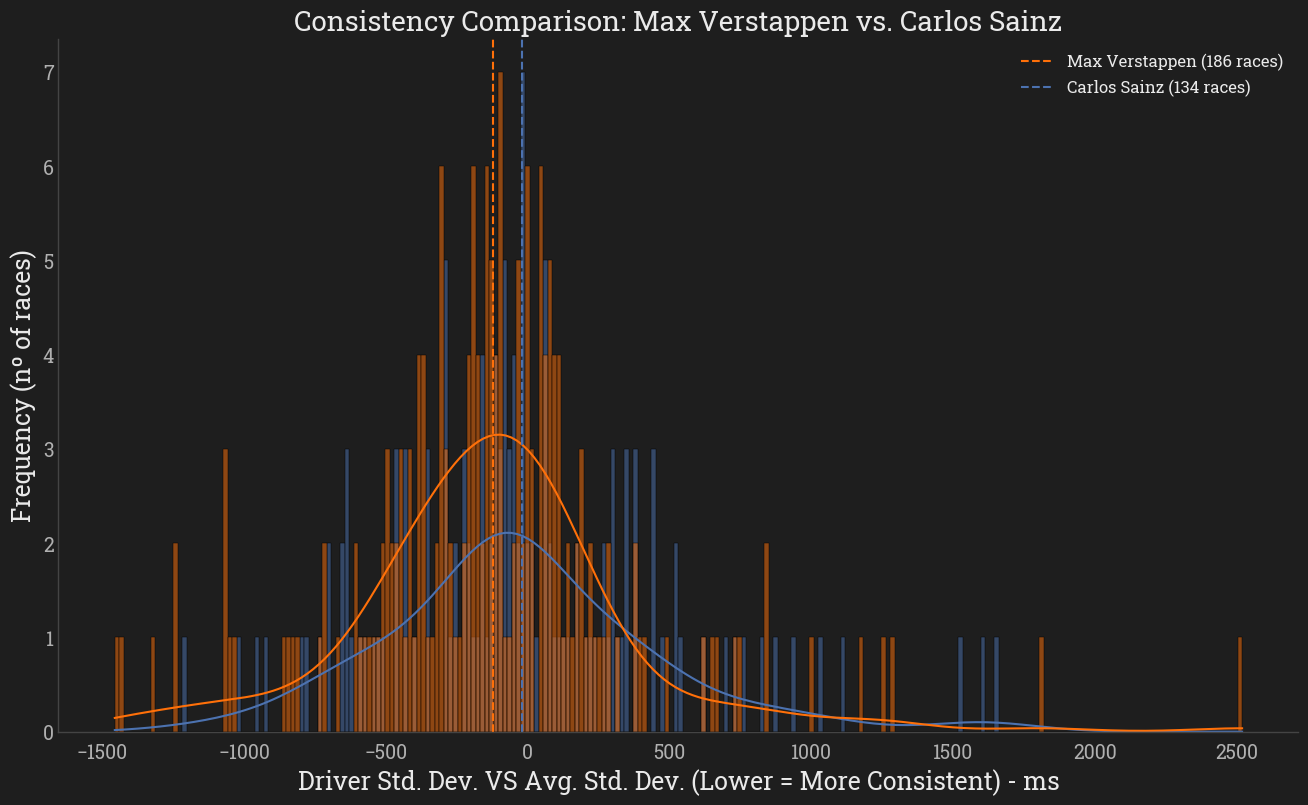

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_yuki_tsunoda_safe.png


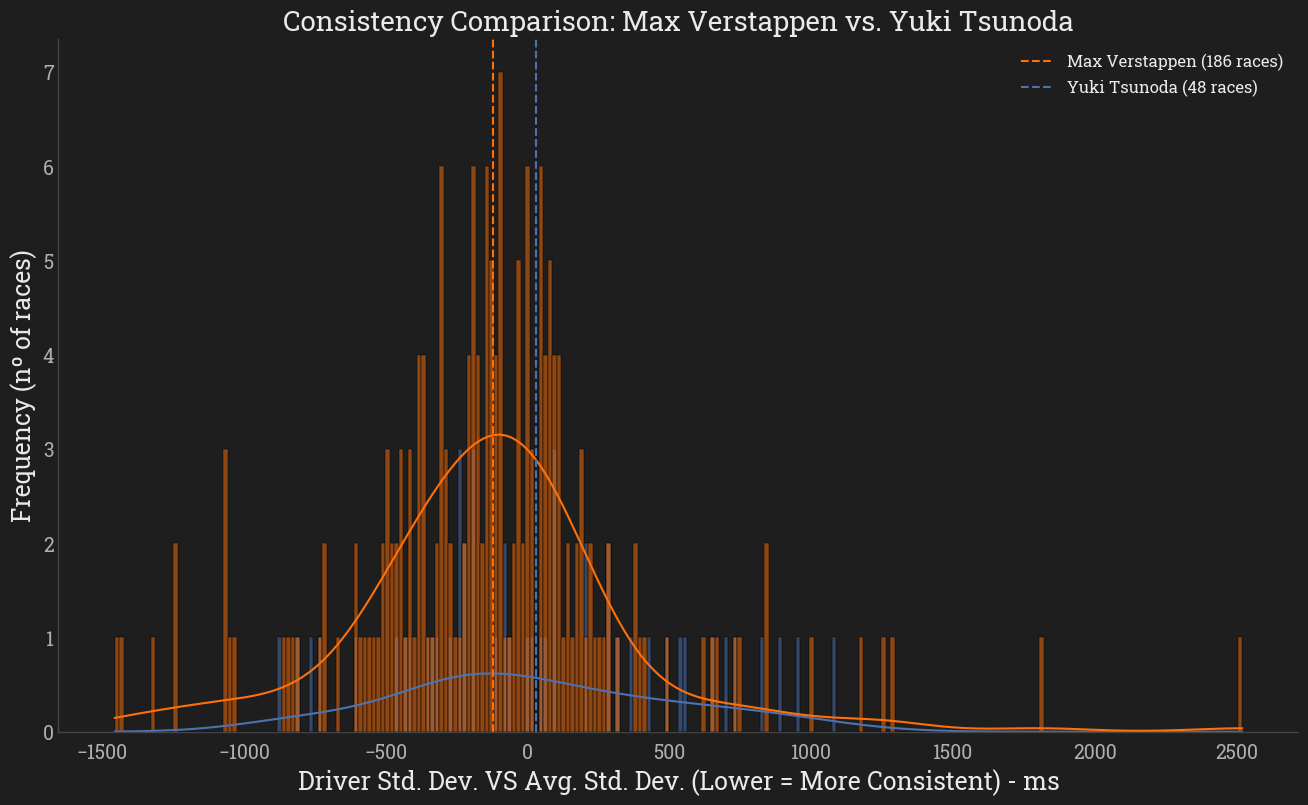

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_charles_leclerc_safe.png


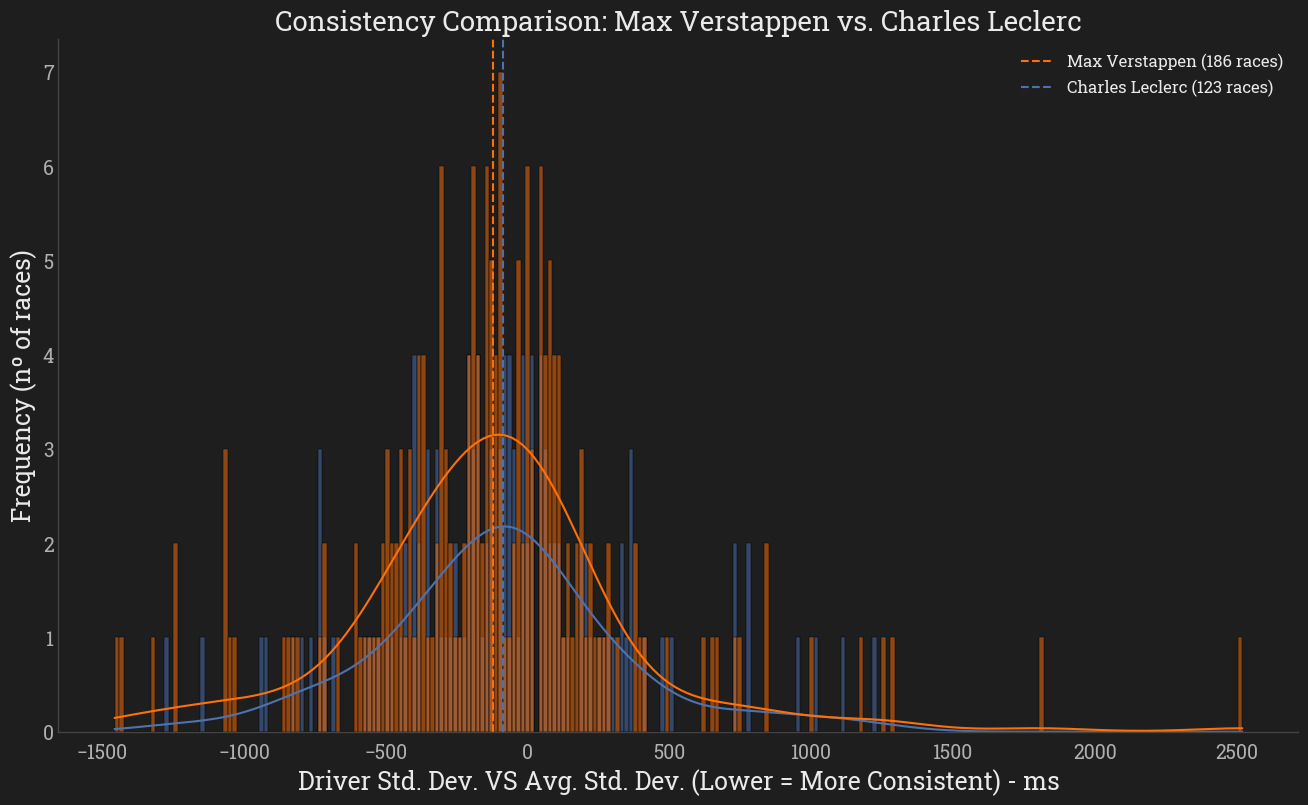

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_lando_norris_safe.png


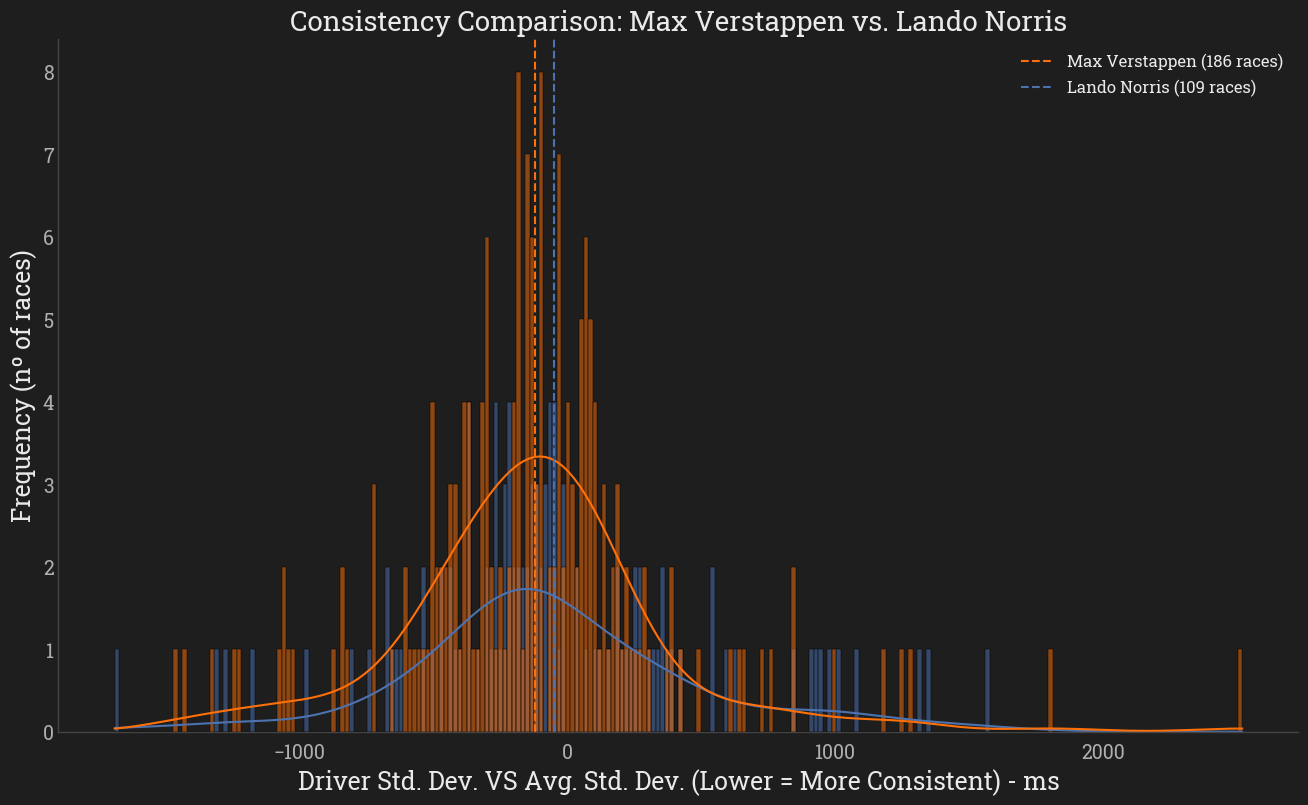

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_george_russell_safe.png


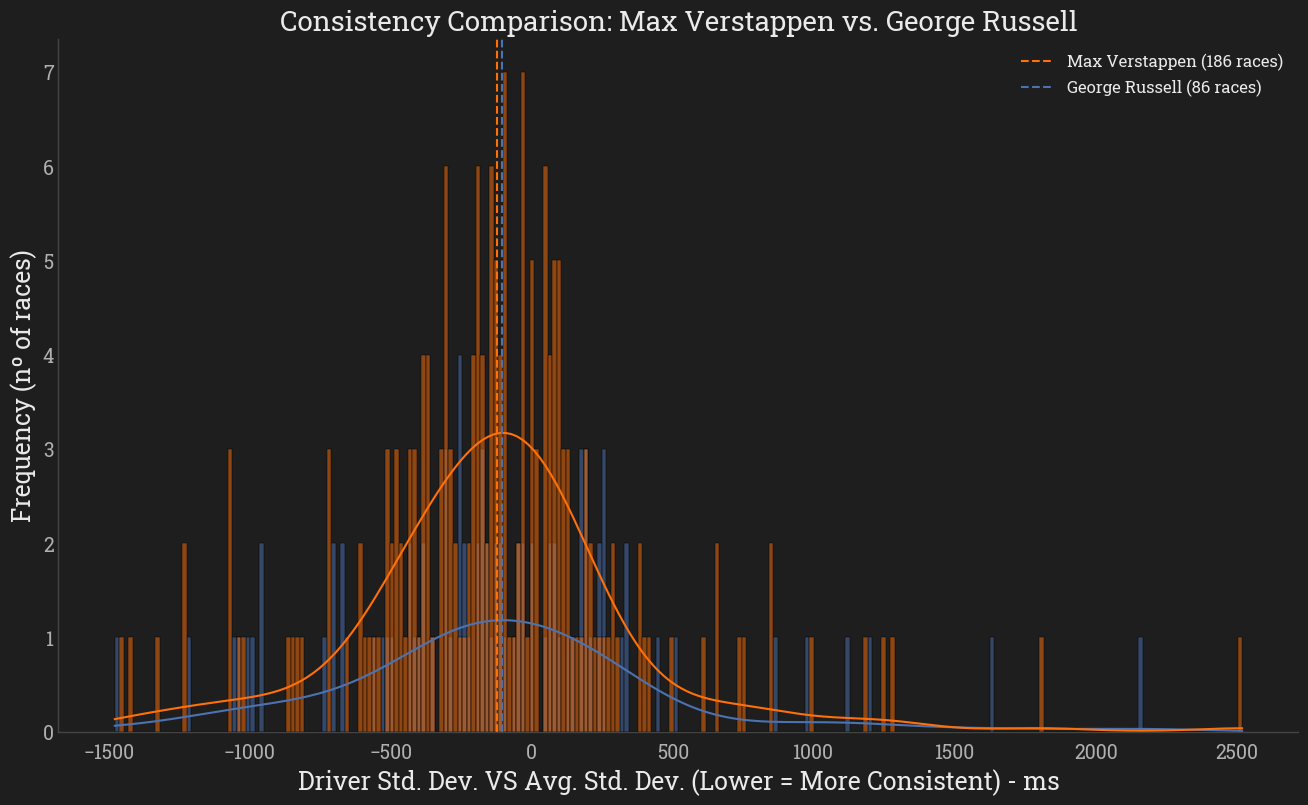

Gráfico salvo em: b:\projetos\f1_analytics\grafs\compara_consistencia\histograma_consistencia__max_verstappen_vs_oscar_piastri_safe.png


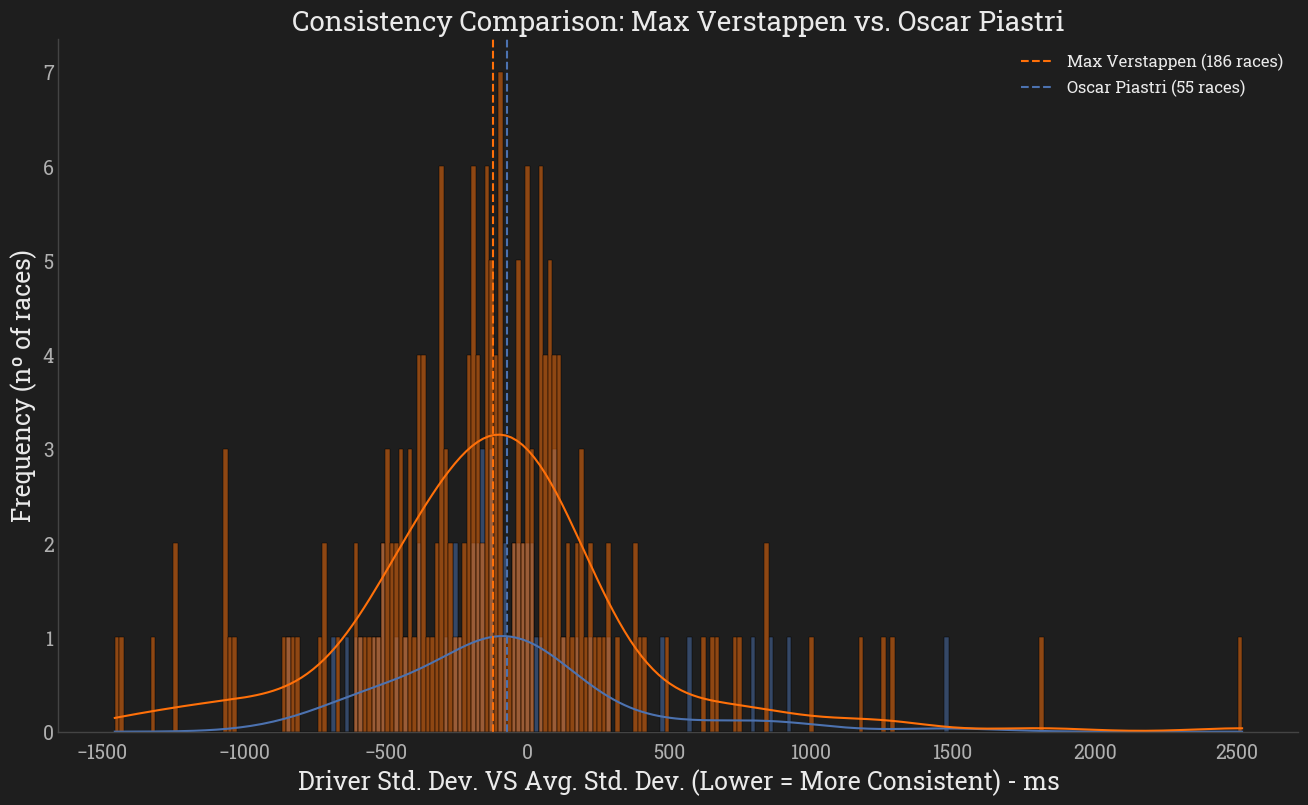

In [33]:
lista_pilotos_a_comparar = [
    # Current-ish era great drivers
    'Lewis Hamilton',
    'Sebastian Vettel',
    'Fernando Alonso',
    'Nico Rosberg',
    'Kimi Räikkönen',
    
    # Teammates
    'Sergio Pérez',
    'Daniel Ricciardo',
    'Alexander Albon',
    'Pierre Gasly',
    'Carlos Sainz',
    'Yuki Tsunoda',
    
    # Newer Generation
    'Charles Leclerc',
    'Lando Norris',
    'George Russell',
    'Oscar Piastri',
]

comparar_consistencia_pilotos_hist(
    df_consistencia=df_lap_times_std,
    pilotos_a_comparar=lista_pilotos_a_comparar,
    metrica='lap_time_std_driver_vs_mean',
    bins=250,
    save_fig=True,
    save_path='grafs/compara_consistencia'
)


Bom, eu acredito que o critério e os filtros utilizados fizeram sentido, porque os resultados nas comparações acima foram "consistentes" (risos):

- O Verstappen parece possuir uma consistência fora do normal, olhando cada gráfico acima, a média de seu desvio padrão relativo é menor do que todos os outros pilotos que estamos trazendo na comparação;
- Um piloto que chega bem perto (tendo uma quantidade muito alta de corridas também, o que é mais um reforço em termos de consistência) é ninguém mais, ninguém menos que Lewis Hamilton (que surpresa)...
- Interessante ver George Russel com altíssima consistência também;

Para tentar simplificar essa visão de comparação de médias, trazendo diretamente essa métrica num gráfico, facilitando a visualização ao retirar a distribuição completa:



In [34]:
df_lap_times_std_agrup = df_lap_times_std[
    # Quero só trazer uma era mais "moderna", por exemplo, não vejo sentido em comparar com Senna, por n motivos
    (df_lap_times_std['year']>2010) &\
    (df_lap_times_std['driver_full_name'].isin(lista_pilotos_a_comparar + ['Max Verstappen', 'Lance Stroll', 'Yuki Tsunoda']))
    ].groupby( 
    by=[
        'driver_full_name',
    ]
).agg(
    {
        'lap_time_std_driver_vs_mean':'mean'
    }
).reset_index()

C:\Users\jvsen\AppData\Local\Temp\ipykernel_31252\56871128.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='lap_time_std_driver_vs_mean', y='driver_full_name', data=df_lap_times_std_agrup, palette=palette, ax=ax)


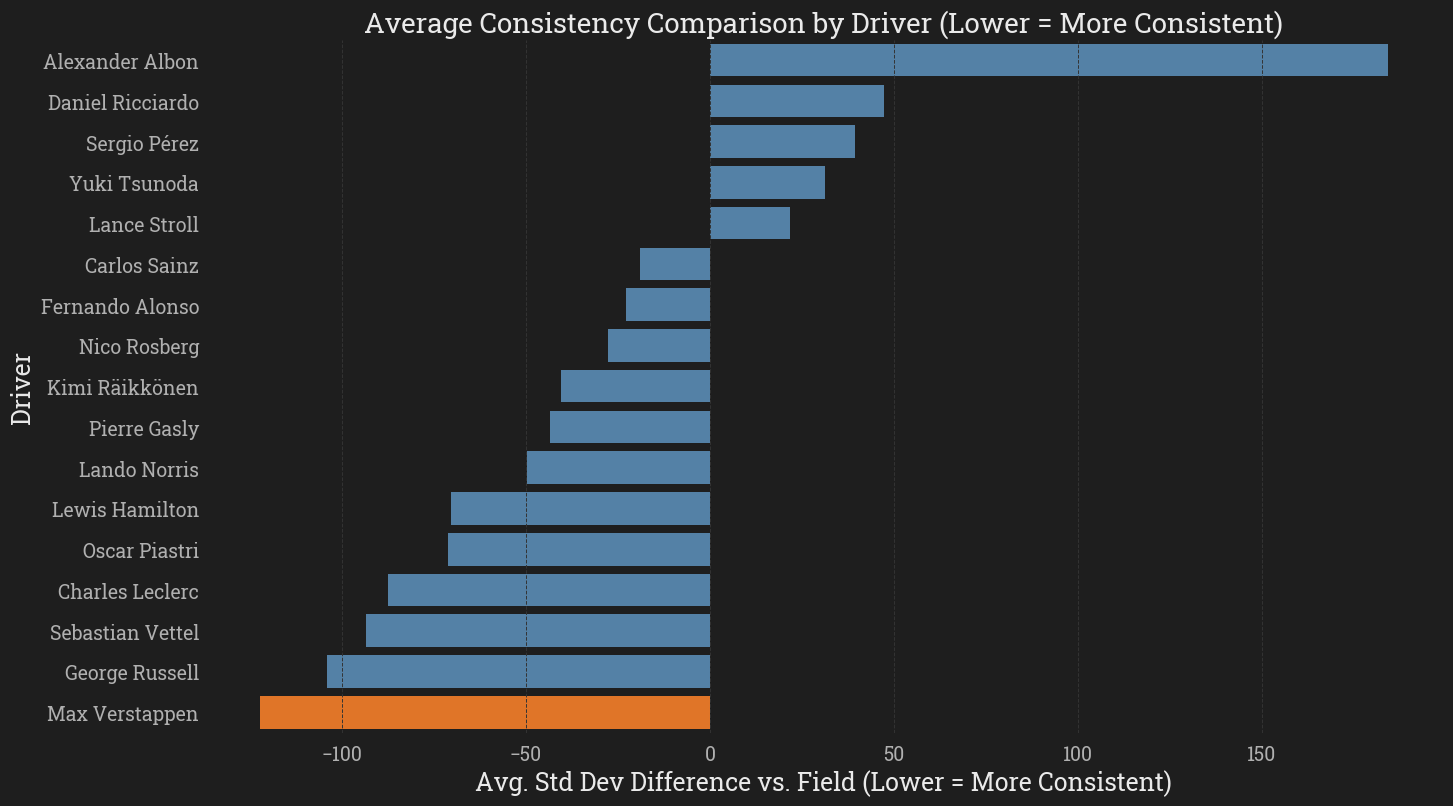

In [35]:
# Define a cor laranja para o Verstappen
cor_verstappen = "#FF7009"

# Cria a paleta de cores.  Outros pilotos serão azuis.
palette = {piloto: cor_verstappen if piloto == 'Max Verstappen' else 'steelblue' for piloto in df_lap_times_std_agrup['driver_full_name']}

# Ordena o DataFrame para que o piloto mais consistente apareça no topo
df_lap_times_std_agrup = df_lap_times_std_agrup.sort_values('lap_time_std_driver_vs_mean', ascending=False)

# Cria o gráfico
fig, ax = plt.subplots(figsize=(16, 9))
sns.barplot(x='lap_time_std_driver_vs_mean', y='driver_full_name', data=df_lap_times_std_agrup, palette=palette, ax=ax)

# Adiciona rótulos e título
ax.set_xlabel('Avg. Std Dev Difference vs. Field (Lower = More Consistent)')
ax.set_ylabel('Driver')
ax.set_title('Average Consistency Comparison by Driver (Lower = More Consistent)')

# Adiciona grid para facilitar a leitura
ax.grid(axis='x', linestyle='--')

# Remove as bordas do gráfico
sns.despine(left=True, bottom=True)

fig.savefig('grafs/comparacao_consistencia_media.png', bbox_inches='tight', dpi=400)

# Mostra o gráfico
plt.show()

Max Verstappen se apresenta como o piloto mais consistente da análise:

- Seguido de George Russel, o que é bem interessante;
- Vemos outros grandes nomes da F1, muitos que já foram campeões, todos se apresentando como mais consistentes do que a média.
- Depois, podemos ver alguns outros nomes que se apresentam menos consistentes do que a média. 

*Obs: Coitado do Alexander Albon, no caso dele, eu diria que as equipes das quais fez parte possuem forte influência nisso, eu o considero um bom piloto*

## Comparação com Companheiro de Equipe (Head 2 Head):

Como mencionei no começo do documento, pensei em duas formas de analisar a capacidade individual do piloto, tentando isolar a influência de sua equipe.

A primeira foi a análise de consistência que apresentei acima, tomando como métrica de "qualidade" para o piloto, a sua consistência de tempo de volta.

A segunda forma vai ser a que eu vou tentar trazer agora, comparando a performance:

### Vou separar a análise em 3 partes:

- Resultados e pontuação de campeonato;
- Resultados de qualificação e tempos de voltas;
- Resultados de corridas e tempo das melhores voltas;

Vou detalhando abaixo conforme for avançando com a análise...

### Head 2 Head no Campeonato:

Como as quantidades de corridas etc vão variando ao longo dos anos, se torna um tanto difícil de eu comparar pontuações historicamente entre diferentes pilotos pois o campeonato foi evoluindo em termos de estrutura ao longo dos anos. Portanto, pra não mergulhar em uma seara muito específica, essa análise de campeonato vai ser um pouco mais breve, porque eu acho que as descobertas aqui são mais suscetíveis a discussões que podem levar a uma imensidão de considerações e desconsiderações a serem feitas.

In [36]:
df_championship = f1_db.run_query_file("data/db_queries/drivers_standings.sql").drop_duplicates()
df_championship

round_id  year             race_name  driver_id      driver_ref  \
0        1143.0  2025  Singapore Grand Prix        857         piastri   
1        1143.0  2025  Singapore Grand Prix        845          norris   
2        1143.0  2025  Singapore Grand Prix        831  max_verstappen   
3        1143.0  2025  Singapore Grand Prix        847         russell   
4        1143.0  2025  Singapore Grand Prix        843         leclerc   
...         ...   ...                   ...        ...             ...   
35079       1.0  1950    British Grand Prix          1          farina   
35080       1.0  1950    British Grand Prix          2         fagioli   
35081       1.0  1950    British Grand Prix          3     reg_parnell   
35082       1.0  1950    British Grand Prix          4       cabantous   
35083       1.0  1950    British Grand Prix          5          rosier   

       driver_number driver_code driver_forename driver_surname  \
0               81.0         PIA           Oscar        Piastri   
1                4.0         NOR           Lando         Norris   
2               33.0         VER             Max     Verstappen   
3               63.0         RUS          George        Russell   
4               16.0         LEC         Charles        Leclerc   
...              ...         ...             ...            ...   
35079            NaN        None            Nino         Farina   
35080            NaN        None           Luigi        Fagioli   
35081            NaN        None             Reg        Parnell   
35082            NaN        None            Yves      Cabantous   
35083            NaN        None           Louis         Rosier   

      driver_full_name  points  position  wins  
0        Oscar Piastri   336.0       1.0     7  
1         Lando Norris   314.0       2.0     5  
2       Max Verstappen   273.0       3.0     4  
3       George Russell   237.0       4.0     2  
4      Charles Leclerc   173.0       5.0     0  
...                ...     ...       ...   ...  
35079      Nino Farina     9.0       1.0     1  
35080    Luigi Fagioli     6.0       2.0     0  
35081      Reg Parnell     4.0       3.0     0  
35082   Yves Cabantous     3.0       4.0     0  
35083     Louis Rosier     2.0       5.0     0  

[35084 rows x 13 columns]

In [37]:
# Nesse dataset, provavelmente vou acabar usando apenas a última etapa do campeonato, pra ver a posição no final
# Então, o que eu posso fazer é criar uma flag pra identificar isso

df_championship['last_round_id'] = df_championship.groupby(['year'])['round_id'].transform('max')

df_championship['last_round_of_year_flag'] = df_championship['round_id'] == df_championship['last_round_id']

df_championship = df_championship.drop(columns=['last_round_id'])

In [38]:
# Podemos olhar aqui rapidamente, o histórico de Verstappen ao final dos campeonatos:

df_championship_ver = df_championship[(df_championship['last_round_of_year_flag']) & (df_championship['driver_ref']=='max_verstappen')]

# Vou adicionar a equipe dele, só pra contribuir pra análise:
df_championship_ver = pd.merge(
    left=df_championship_ver,
    right=df_races[['round_id', 'driver_ref', 'constructor_name']],
    on=['driver_ref', 'round_id']
)

df_championship_ver

round_id  year             race_name  driver_id      driver_ref  \
0     1143.0  2025  Singapore Grand Prix        831  max_verstappen   
1     1125.0  2024  Abu Dhabi Grand Prix        831  max_verstappen   
2     1101.0  2023  Abu Dhabi Grand Prix        831  max_verstappen   
3     1079.0  2022  Abu Dhabi Grand Prix        831  max_verstappen   
4     1057.0  2021  Abu Dhabi Grand Prix        831  max_verstappen   
5     1035.0  2020  Abu Dhabi Grand Prix        831  max_verstappen   
6     1018.0  2019  Abu Dhabi Grand Prix        831  max_verstappen   
7      997.0  2018  Abu Dhabi Grand Prix        831  max_verstappen   
8      976.0  2017  Abu Dhabi Grand Prix        831  max_verstappen   
9      956.0  2016  Abu Dhabi Grand Prix        831  max_verstappen   
10     935.0  2015  Abu Dhabi Grand Prix        831  max_verstappen   

    driver_number driver_code driver_forename driver_surname driver_full_name  \
0            33.0         VER             Max     Verstappen   Max Verstappen   
1            33.0         VER             Max     Verstappen   Max Verstappen   
2            33.0         VER             Max     Verstappen   Max Verstappen   
3            33.0         VER             Max     Verstappen   Max Verstappen   
4            33.0         VER             Max     Verstappen   Max Verstappen   
5            33.0         VER             Max     Verstappen   Max Verstappen   
6            33.0         VER             Max     Verstappen   Max Verstappen   
7            33.0         VER             Max     Verstappen   Max Verstappen   
8            33.0         VER             Max     Verstappen   Max Verstappen   
9            33.0         VER             Max     Verstappen   Max Verstappen   
10           33.0         VER             Max     Verstappen   Max Verstappen   

    points  position  wins  last_round_of_year_flag constructor_name  
0    273.0       3.0     4                     True         Red Bull  
1    437.0       1.0     9                     True         Red Bull  
2    575.0       1.0    19                     True         Red Bull  
3    454.0       1.0    15                     True         Red Bull  
4    395.5       1.0    10                     True         Red Bull  
5    214.0       3.0     2                     True         Red Bull  
6    278.0       3.0     3                     True         Red Bull  
7    249.0       4.0     2                     True         Red Bull  
8    168.0       6.0     2                     True         Red Bull  
9    204.0       5.0     1                     True         Red Bull  
10    49.0      12.0     0                     True       Toro Rosso

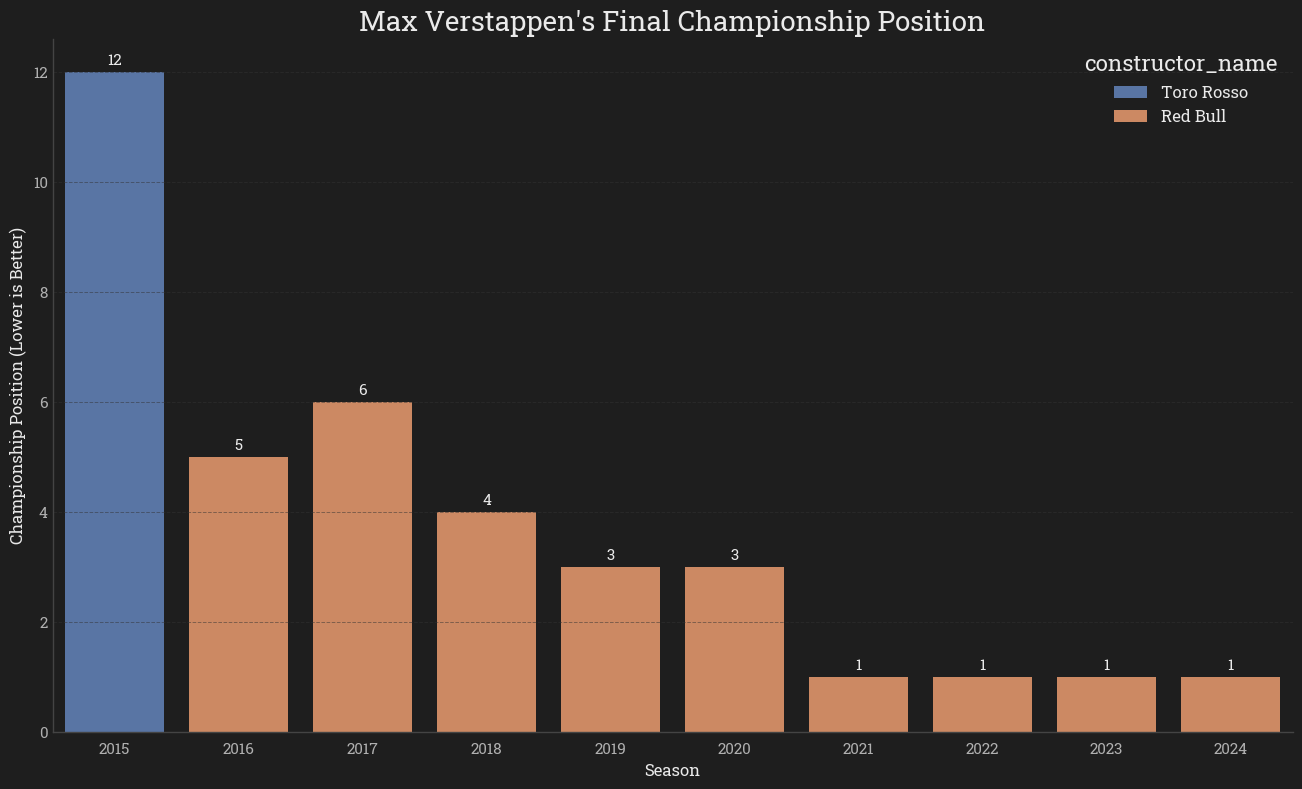

In [39]:
fig, ax = plt.subplots(figsize=(16, 9))

# Grade de fundo (leve, só no eixo Y)
ax.grid(axis='y', linestyle='--', alpha=0.5, zorder=0)

sns.barplot(
    data=df_championship_ver[df_championship_ver['year']!=2025],
    x='year',
    y='position',
    ax=ax,
    hue='constructor_name'
)

# Adicionar os valores (posições) em cima das barras
for p in ax.patches[0:-2]: # Tive que fazer esse indexing pq tem um 0 aleatório que fica aparecendo no gráfico (?)
    ax.annotate(
        f'{p.get_height():.0f}',        # O valor (posição, ex: "1")
        (p.get_x() + p.get_width() / 2., p.get_height()), # Posição (x, y)
        ha='center', va='center',       # Centralizado na barra
        xytext=(0, 8),                  # Offset de 8 pontos para cima
        textcoords='offset points',
        fontsize=11,
    )

ax.set_title(
    "Max Verstappen's Final Championship Position",
)

# Labels mais claros
ax.set_xlabel("Season", fontsize=12)
ax.set_ylabel("Championship Position (Lower is Better)", fontsize=12)

fig.savefig('grafs/verstappen_champ_position_yearly.png', bbox_inches='tight')

# Ajuste de ticks
ax.tick_params(axis='x', labelsize=11)
ax.tick_params(axis='y', labelsize=11)


Acima, podemos ver o histórico de desempenho do Verstappen ao final de cada temporada.

In [40]:
df_championship_vs = add_colunas_companheiro_equipe(
    df_dados=df_championship[df_championship['last_round_of_year_flag']],
    metricas=['position', 'wins', 'points'],
    df_lookup=df_races
)

In [41]:
# Podemos agora tratar um pouco esse dataset pra ter insights:

df_championship_vs_filtrado = df_championship_vs#[df_championship_vs['driver_full_name']].isin(['Max Verstappen'] + lista_pilotos_a_comparar)]

df_championship_vs_agrup = df_championship_vs_filtrado.groupby(
    by=['driver_ref', 'driver_full_name']
).agg(
    {
        'position_diff_tmate':'mean',
        'wins_diff_tmate':'mean',
        'points_diff_tmate':'mean'
    }
).reset_index()

# A coluna de position_diff é negativa quando o piloto fica a frente, só pro gráfico ficar mais intuitivo depois, eu vou inverter o sinal
df_championship_vs_agrup['position_diff_tmate'] = df_championship_vs_agrup['position_diff_tmate']*(-1)

Gráfico salvo em: b:\projetos\f1_analytics\grafs\championship_h2h_avg_positions_ahead_of_teammate_season_end_safe.png


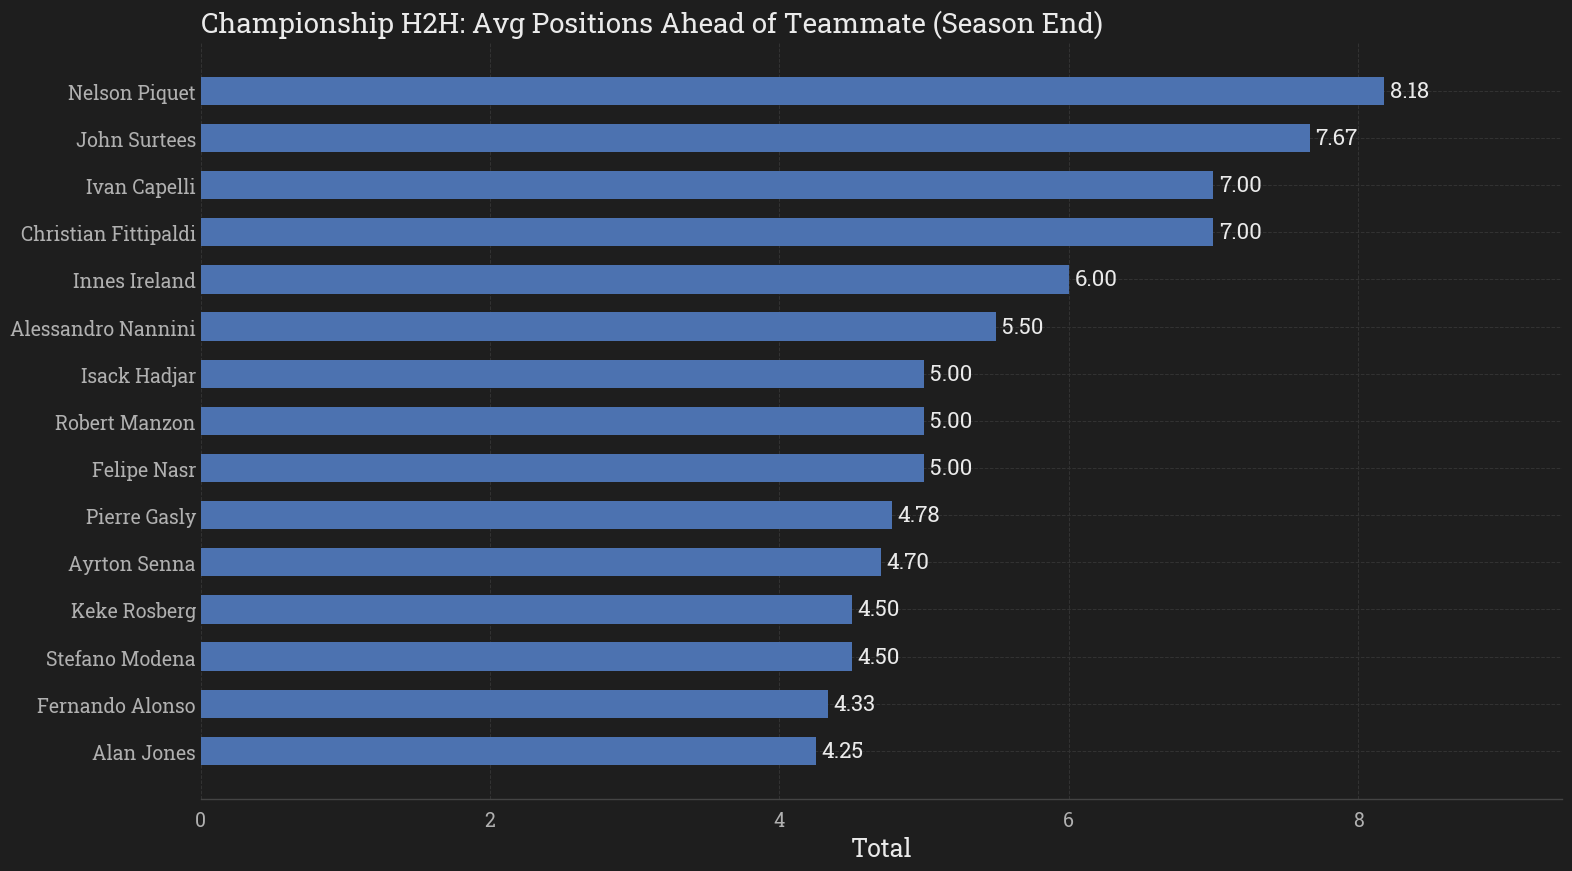

Gráfico salvo em: b:\projetos\f1_analytics\grafs\championship_h2h_avg_wins_ahead_of_teammate_season_end_safe.png


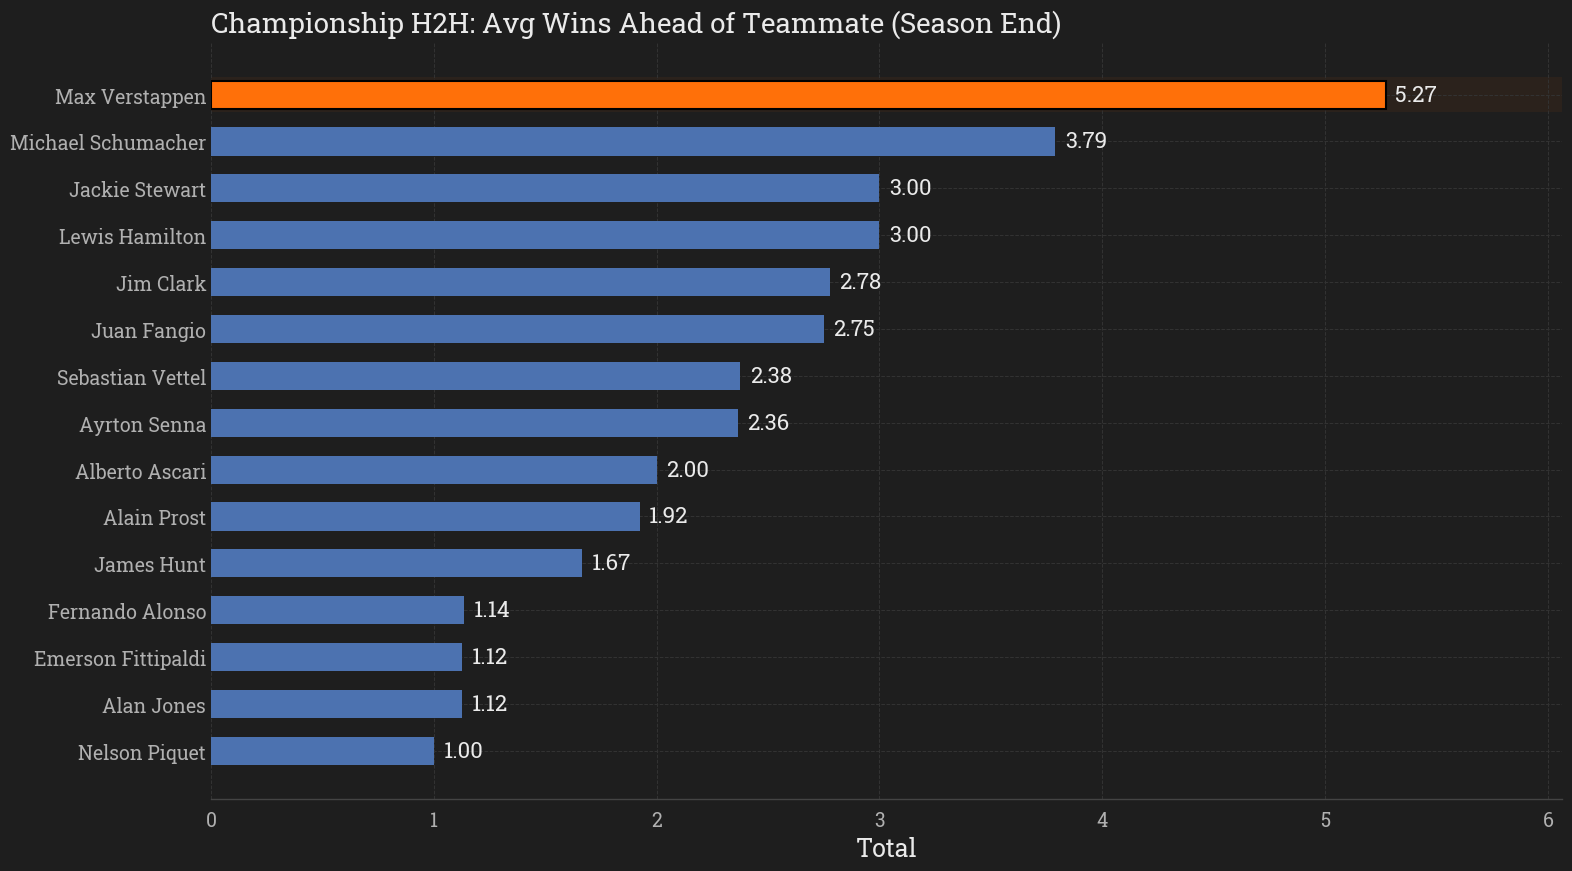

Gráfico salvo em: b:\projetos\f1_analytics\grafs\championship_h2h_avg_points_gap_to_teammate_season_end_safe.png


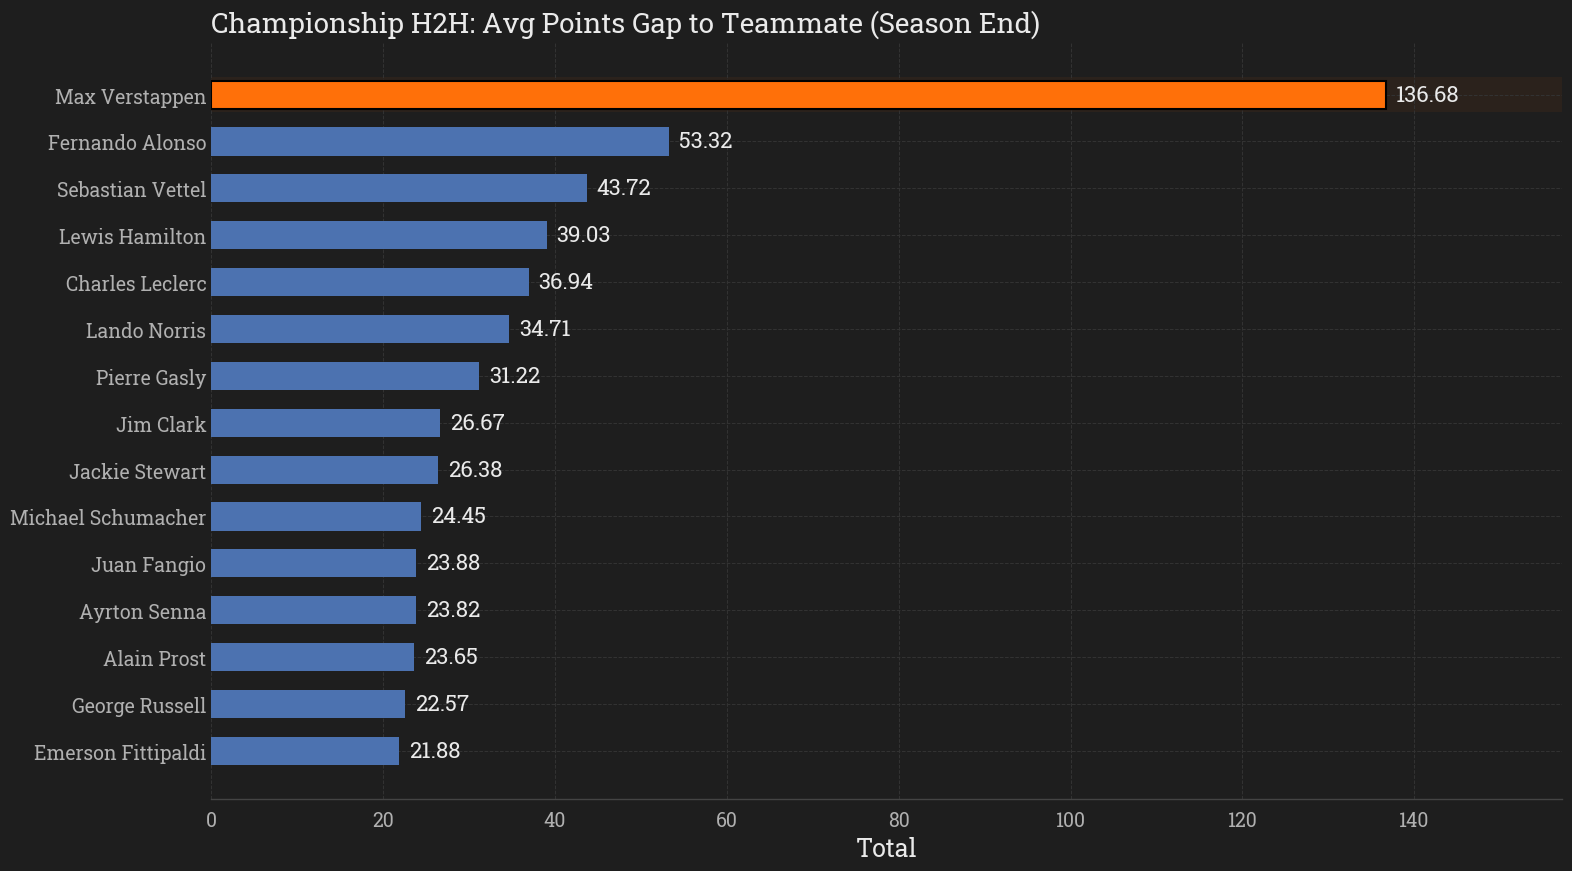

In [42]:
dict_cols_plot = {
    'position_diff_tmate': 'Avg Positions Ahead of Teammate',
    'wins_diff_tmate': 'Avg Wins Ahead of Teammate',
    'points_diff_tmate': 'Avg Points Gap to Teammate'
}

for col_valor, metric_name in dict_cols_plot.items():

    titulo = f'Championship H2H: {metric_name} (Season End)'

    graf_top_pilotos(
        df=df_championship_vs_agrup,
        col_valor=col_valor,
        titulo=titulo,
        top_n=15,
        valor_format_str="{:,.2f}",
        figsize=(16,9),
        save_fig=True,
    )

    

Acima nós podemos ver, respectivamente:

- **Média de quantas posições o piloto estava a frente de seu companheiro de equipe**, ou seja, podemos interpretar, que em média, o Gasly fica quase 5 posições acima de seu companheiro de equipe ao final do campeonato (piloto underrated?)
    - Nesse gráfico, podemos ver que o Verstappen aparece em terceiro lugar, e isso por si só é muito bom. Mas tem uma consideração aqui, eu diria que o 3.45 do VER é "diferente" que o 4.33 do ALO por mais do que pareça óbvio o que estou dizendo, e digo isso porque o Verstappen vem dominando campeonatos historicamente, sendo que, depois de seu primeiro campeonato na F1, que terminou em 12o, terminou no top 5 com a exceção de um 6 lugar em sua 3a temporada, sendo que ele ficou entre os 3 primeiros em quase todos os campeonatos. Já o Alonso, até por ter disputado muito mais campeonatos e participar de equipes que não estão sempre à frente, existe muito mais trocas de posição e "sensibilidade" aos pontos do que nas primeiras posições (Verstappen está no *hardcap* - não tem como subir mais do que o primeiro lugar -  enquanto Alonso tem mais posições pra subir frente ao seu companheiro), mas isso, de forma alguma, deixa de mostrar o quão grande piloto o Alonso é, eu só acho que essa análise é um tanto enviesada por ele ter pilotado em equipes que ficam mais atrás no campeonato do que Verstappen (vou deixar de lado que o companheiro de equipe nos últimos anos de Alonso tenha sido o Stroll). Uma linha de raciocínio, na minha visão, também contribui pro valor elevado do Gasly, de novo, de forma que isso não invalida que ele é um bom piloto.

- **Média de vitórias a mais que o companheiro de equipe ao final do campeonato**, ou seja, interpretamos que o Verstappen ganha, em média, 5.3 corridas a mais que o seu companheiro de equipe ao final do campeonato.
    - Isso é muito interessante, e acho que é uma das características mais marcantes dos campeonatos do Verstappen historicamente, ele costuma despontar muito de seu companheiro de equipe, e isso é traduzido aqui, ele é, em média, o piloto que tem a maior quantidade de vitórias a mais que seu companheiro de equipe quando o ano termina.

- **Média de Pontos acima do companheiro de equipe ao final do campeonato**, ou seja, interpretamos, que, em média, Verstappen termina o campeonato 136 pontos acima de seu companheiro de equipe, o que é meio bizarro, e foi muito elevado nos últimos anos com o Perez que não estava conseguindo performar, mas também por outros pilotos em que isso aconteceu (sim, existe um padrão aqui e meu objetivo não vai ser tentar analisar isso especificamente, podemos passar muitas horas discutindo pq os companheiros de equipe do Verstappen não performam bem, mas eu já mencionei no início que tenho a premissa que os carros entre companheiros de equipe tem o mesmo potencial de performance, pra não correr o risco de entrar em uma tangente absurda).


O que consigo extrair da análise acima, é que, resumidamente, o Verstappen costuma se "descolar" mais de seu companheiro de equipe ao longo do campeonato do que outros pilotos, levando a tese de que é um piloto que consegue extrair mais do carro do que outros pilotos conseguiriam.

## H2H na Qualificação

Mencionei acima que uma outra forma de abordarmos a comparação com o companheiro de equipe seria através do resultado de qualificação, então vamos lá e, como sempre, vou explicando ao longo da análise:

#### Percentual de "vitórias" em qualificação

Uma primeira, e simples abordagem, é ver o percentual de vitórias contra o companheiro de equipe em qualificação. A ideia é que quanto maior o percentual de vitória, "melhor" é o piloto, dado que ele performou melhor contra alguém que estava com o mesmo "equipamento" que ele.

Obs.: eu uso o termo "vitória" de forma mais genérica aqui, a ideia é ver quem qualificou na frente, é isso que eu to considerando como "vitória", não de fato ter ganhado a corrida ou qualificado na pole.  

In [43]:
df_quali = f1_db.run_query_file("data/db_queries/qualify_report.sql")
df_quali = add_lap_time_ms_column(df_quali, lap_time_col='best_lap_time')

In [44]:
# Pra não correr o risco de analisar pilotos que possam ter participado de pouquíssimas corridas, vou removê-los da análise:

# Adiciono uma coluna contando de quantos eventos o piloto participou
df_quali['event_count'] = df_quali.groupby(['driver_ref', 'session_type'])['race_name'].transform('count')
# ^^ Aqui eu posso fazer o groupby dessa forma pq todo piloto necessariamente passou pelo Q1, então contar pelo session_type aqui funciona

# Filtro só quem participou de mais do que 20 eventos, isolando pilotos das antigas que participaram de poucas etapas

df_quali = df_quali[df_quali['event_count']>20]

In [45]:
# Quero filtrar apenas a última sessão em que cada piloto chegou (tem gente que só vai pro Q1 etc)
# Não vou analisar sessão por sessão, ou seja, não quero Q1 vs Q1 etc, quero só até onde cada piloto chegou e vou ver a performance na quali como um todo

df_quali_valid = get_final_quali_session(df_quali)

In [46]:
# Agora vou trazer as informações sobre o companheiro de equipe pra comparar as métricas:

df_quali_vs = add_colunas_companheiro_equipe(
    df_dados=df_quali_valid,
    metricas=['best_lap_time_ms', 'final_quali_position'],
    colunas_id_tmate=['driver_ref', 'driver_full_name', 'session_type'] # Vou trazer até qual sessão o companheiro chegou, vai ser útil pra depois, confia
)

In [47]:
# Vou colocar uma flag indicando se o piloto "ganhou" do tmate dele naquele evento de qualificação

df_quali_vs['fl_win_quali_vs_tmate'] = df_quali_vs['final_quali_position'] < df_quali_vs['final_quali_position_tmate']

In [48]:
# Agora posso agrupar o dataset pra contar quantidade de "vitórias" em quali para cada piloto

df_quali_vs_agrup = df_quali_vs.groupby(
    [
        'driver_ref',
        'driver_full_name',
        'fl_win_quali_vs_tmate'
    ]
).agg(
    {'round_id':'count'}
).reset_index(
).rename(
    columns={
        'round_id':'qt_rounds'
    }
)

# Adiciono uma coluna calculando o percentual:
# Primeiro calculo a quantidade total:
df_quali_vs_agrup['total_rounds_for_driver'] = df_quali_vs_agrup.groupby(['driver_ref'])['qt_rounds'].transform('sum')

# Calculo o percentual dividindo uma coisa pela outra:
df_quali_vs_agrup['result_percentage'] = df_quali_vs_agrup['qt_rounds'] / df_quali_vs_agrup['total_rounds_for_driver']

# vou filtrar usando a flag, pra ter o percentual apenas referente a quando o piloto ficou na frente de seu companheiro de equipe:
df_quali_vs_agrup_wins = df_quali_vs_agrup[df_quali_vs_agrup['fl_win_quali_vs_tmate']]


In [49]:
import matplotlib
print(matplotlib.get_cachedir())

C:\Users\jvsen\.matplotlib


Gráfico salvo em: b:\projetos\f1_analytics\grafs\top_15_qualifying_headtohead_win_rate_safe.png


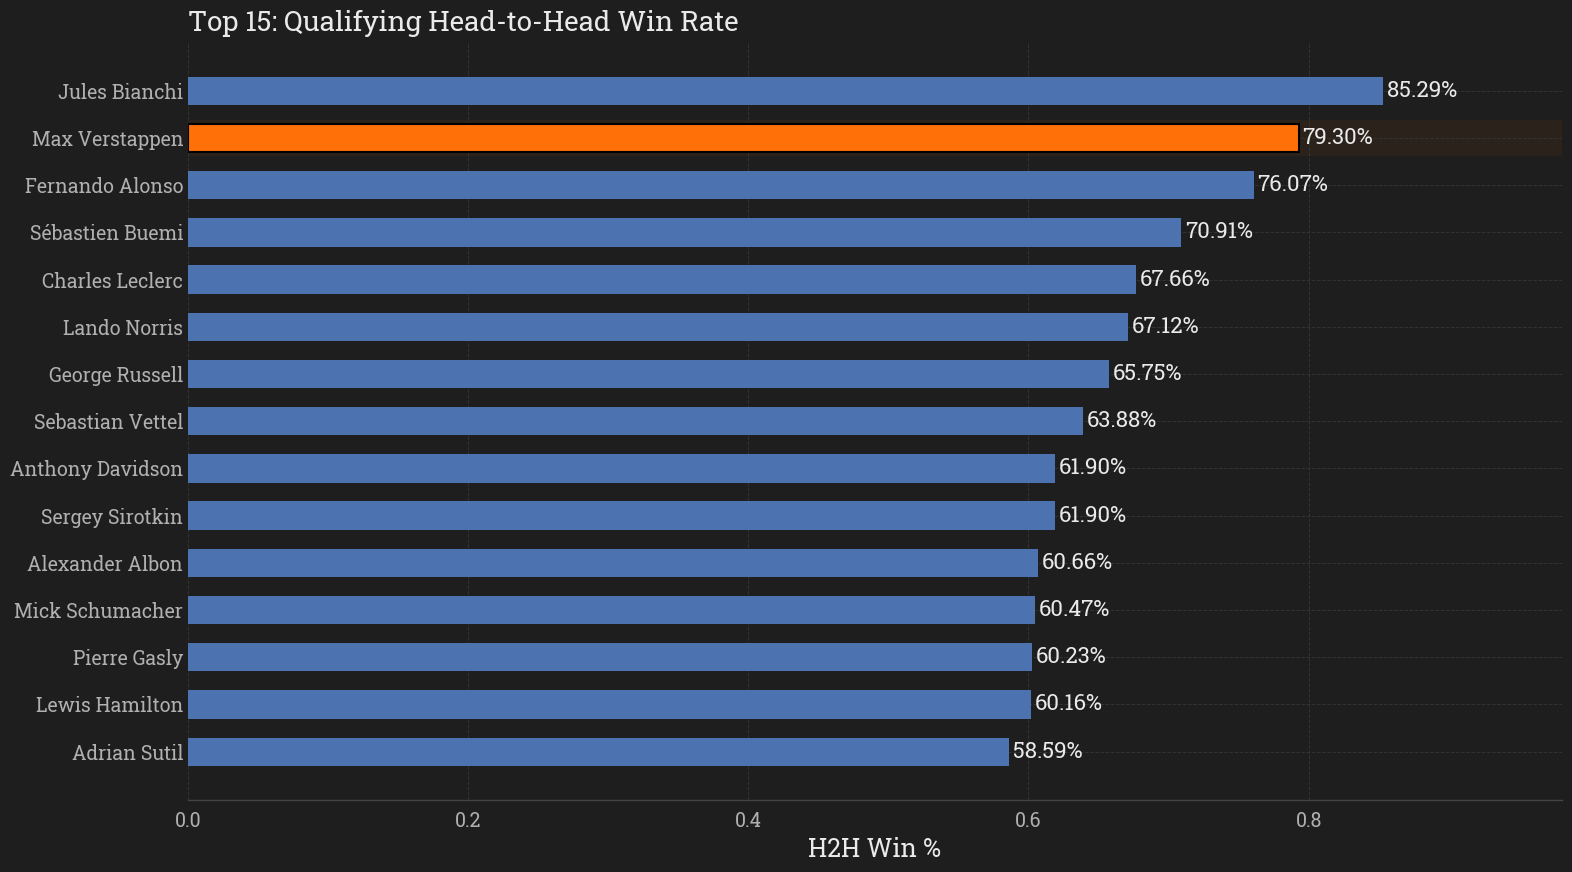

In [50]:
graf_top_pilotos(
    df=df_quali_vs_agrup_wins,
    top_n=15,
    col_valor='result_percentage',
    valor_format_str='{:.2%}',
    titulo='Top 15: Qualifying Head-to-Head Win Rate',
    xlabel='H2H Win %',
    save_fig=True
)

Acima, temos os top 15 pilotos com o maior percentual de superação frente ao companheiro de equipe em qualificação. Entenda da seguinte forma: Jules Bianchi qualificou na frente de seu companheiro de equipe em 85,29% das vezes ao longo de sua carreira.

Novamente, vemos o Verstappen aparecendo logo depois de Jules Bianchi, e uma observação sobre isso à quem não sabe:
- Jules Bianchi foi um piloto promissor que teve sua carreira interrompida por um trágico acidente no GP de Suzuka de 2014. Ele começou sua carreira na F1 em 2013 e no seu segundo ano da F1 sofreu esse acidente. Sua morte foi a primeira fatalidade decorrente de um acidente na F1 desde Ayrton Senna em 1994 e levou a diversas mudanças nas medidas de segurança nos eventos da F1.
- **Sobre sua breve carreira**: Ele particiou de 34 GPs da F1, todos pela Marussia e correu contra apenas 1 companheiro de equipe, que superou em quase todos eventos de qualificação que participaram. Infelizmente, considero que ele não teve oportunidade de apresentar todo seu potencial na F1. O número apresentado no gráfico acima é uma prova de que era um piloto de qualidade. Mas, o fato é, por ter tido sua carreira tragicamente interrompida, consequentemente não podendo ter alcançado números de GP como de Hamilton, Alonso, Verstappen etc e ter tido apenas um companheiro de equipe durante sua carreira na F1. Veja esse percentual como um número que atesta a sua qualidade como piloto, mas não como uma métrica diretamente comparável ao de outros pilotos que trago no gráfico acima.
- **Novamente Verstappen aparece com números completamente dominadores**: Dentre todos os pilotos da era moderna, e que participaram de uma grande quantidade de GPs, o Verstappen aparece simplesmente superando todos eles. Seguido de Alonso, que tem um percentual muito surpreendente também.

Gráfico salvo em: b:\projetos\f1_analytics\grafs\top_15_qualifying_headtohead_win_rate_w_drivers_filter_safe.png


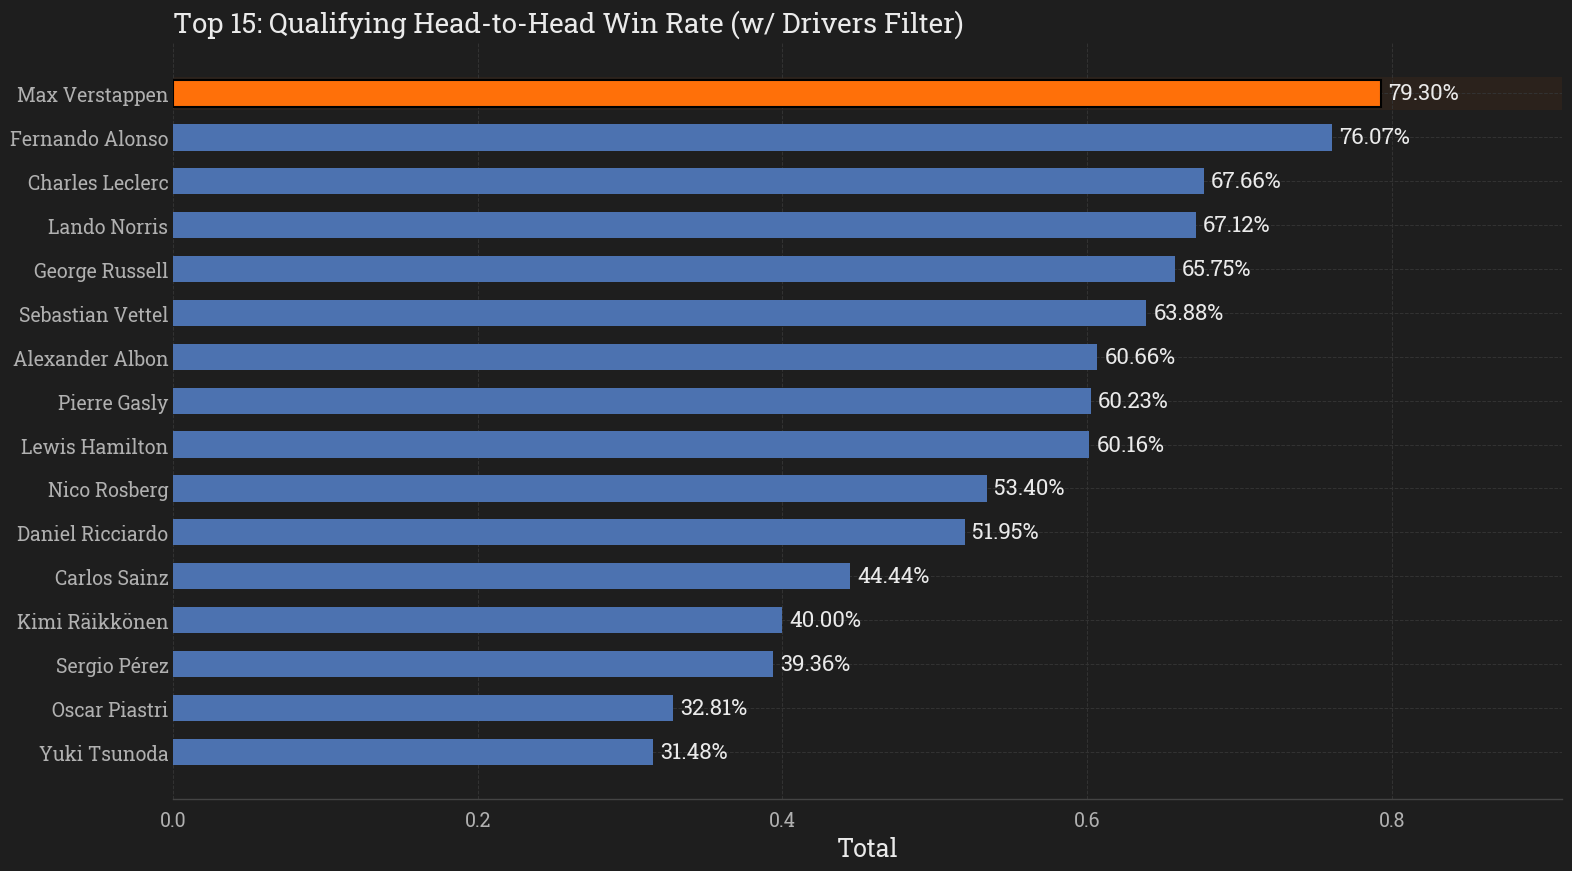

In [51]:
# Se pegarmos só os pilotos mais "Comparáveis":

graf_top_pilotos(
    df=df_quali_vs_agrup_wins[df_quali_vs_agrup_wins['driver_full_name'].isin(lista_pilotos_a_comparar + ['Max Verstappen'])],
    top_n=30,
    col_valor='result_percentage',
    valor_format_str='{:.2%}',
    titulo='Top 15: Qualifying Head-to-Head Win Rate (w/ Drivers Filter)',
    save_fig=True
)

Ao utilizarmos a lista que eu tinha criado acima, usando grandes nomes de uma era mais moderna da F1, vemos que o Verstappen simplesmente supera todos eles.

E vale mencionar também o quão grande piloto o Alonso é, está na F1 há um século já, participou de diversas equipes, teve diversos companheiros de equipe e tem uma taxa de superação absurdamente alta (o fato de o companheiro atual ser o Stroll pode ter ajudado um pouco...)

Podemos também ver como Verstappen foi contra cada companheiro de equipe que teve, será que algum foi capaz de superá-lo?

In [52]:
# Agora posso agrupar o dataset pra contar quantidade de "vitórias" em quali para cada piloto

df_quali_vs_agrup_tmate = df_quali_vs.groupby(
    [
        'driver_ref',
        'driver_full_name',
        'driver_full_name_tmate',
        'fl_win_quali_vs_tmate'
    ]
).agg(
    {'round_id':'count'}
).reset_index(
).rename(
    columns={
        'round_id':'qt_rounds'
    }
)

# Adiciono uma coluna calculando o percentual:
# Primeiro calculo a quantidade total que ele teve com aquele compnaheiro de equipe:
df_quali_vs_agrup_tmate['total_rounds_for_driver_w_tmate'] = df_quali_vs_agrup_tmate.groupby(['driver_ref', 'driver_full_name_tmate'])['qt_rounds'].transform('sum')

# Calculo o percentual dividindo uma coisa pela outra:
df_quali_vs_agrup_tmate['result_percentage'] = df_quali_vs_agrup_tmate['qt_rounds'] / df_quali_vs_agrup_tmate['total_rounds_for_driver_w_tmate']

# vou filtrar usando a flag, pra ter o percentual apenas referente a quando o piloto ficou na frente de seu companheiro de equipe:
df_quali_vs_agrup_tmate_wins = df_quali_vs_agrup_tmate[df_quali_vs_agrup_tmate['fl_win_quali_vs_tmate']]

In [53]:
df_quali_vs_agrup_tmate_wins

driver_ref   driver_full_name driver_full_name_tmate  \
1       albers  Christijan Albers           Adrian Sutil   
3        albon    Alexander Albon           Carlos Sainz   
5        albon    Alexander Albon           Daniil Kvyat   
7        albon    Alexander Albon       Franco Colapinto   
9        albon    Alexander Albon         Logan Sargeant   
..         ...                ...                    ...   
503   wehrlein    Pascal Wehrlein           Esteban Ocon   
505   wehrlein    Pascal Wehrlein        Marcus Ericsson   
508   yamamoto     Sakon Yamamoto            Bruno Senna   
510   yamamoto     Sakon Yamamoto            Takuma Sato   
512       zhou        Guanyu Zhou        Valtteri Bottas   

     fl_win_quali_vs_tmate  qt_rounds  total_rounds_for_driver_w_tmate  \
1                     True          2                                9   
3                     True          9                               18   
5                     True          6                               11   
7                     True          6                                9   
9                     True         33                               36   
..                     ...        ...                              ...   
503                   True          6                                8   
505                   True         11                               18   
508                   True          1                                6   
510                   True          2                                7   
512                   True         16                               68   

     result_percentage  
1             0.222222  
3             0.500000  
5             0.545455  
7             0.666667  
9             0.916667  
..                 ...  
503           0.750000  
505           0.611111  
508           0.166667  
510           0.285714  
512           0.235294  

[256 rows x 7 columns]

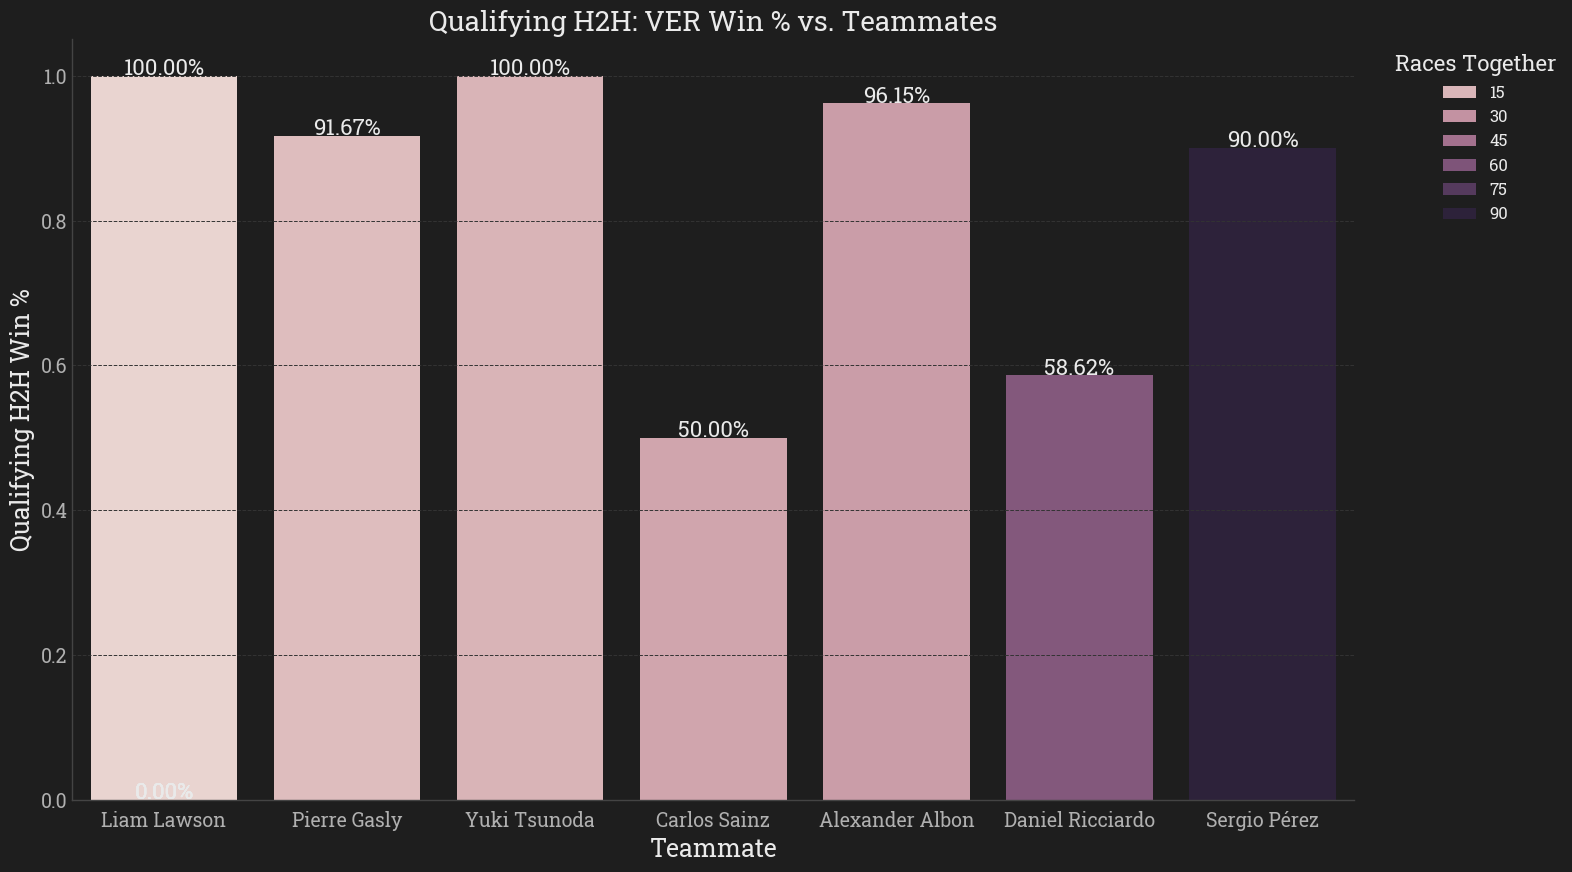

In [54]:
fig, ax = plt.subplots(figsize=(16,9))

sns.barplot(
    data=df_quali_vs_agrup_tmate_wins[df_quali_vs_agrup_tmate_wins['driver_full_name']=='Max Verstappen'].sort_values('total_rounds_for_driver_w_tmate'),
    x='driver_full_name_tmate',
    y='result_percentage',
    hue='total_rounds_for_driver_w_tmate',
    ax=ax
)

# Anotações (Mantendo o formato .1f para valores 0-100)
for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.2%}',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 5),
        textcoords='offset points',
        # fontsize removido para obedecer ao tema
    )

# --- TRADUÇÕES ---
ax.set_xlabel("Teammate")
ax.set_ylabel("Qualifying H2H Win %")
ax.set_title("Qualifying H2H: VER Win % vs. Teammates")

# Legenda
legend = ax.get_legend()
if legend:
    legend.set_title("Races Together")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1))

plt.tight_layout()

# Salva com fundo transparente para o vídeo
fig.savefig(
    'grafs/h2h_quali_percentual_superacao_verstappen_vs_tmates.png', 
    bbox_inches='tight',
    transparent=True
)

plt.show()

Acima, podemos ver que Verstappen superou todos os companheiros de equipe com exceção de Carlos Sainz, contra quem empatou em performance de qualificação!

Isso foi na Toro Rosso, na temporada de estreia de ambos os pilotos!

Obs.: Existem diversas fontes que apontam que Verstappen superou Sainz em qualificação durante seu tempo juntos na Toro Rosso, por um evento de qualificação que seria o da Russia em 2015, mas a questão é que Sainz não participou dessa quali, por ter sofrido um acidente no TL3, que fez com que seu carro ficasse destruído e que Sainz precisasse de assistência média. Em relação a isso, sei que tem quem vai falar que isso é culpa de Sainz, já que se ele não tivesse batido, teria participado da quali. Porém, eu só to colocando aqui eventos em que ambos os pilotos participaram, e, sendo assim, ambos bateram um ao outro exatamente 11 vezes.

### Mas, e se tentarmos quantificar o quanto um piloto está superando o outro?

Meu próximo ângulo dessa análise será de ver em quanto cada piloto supera o seu companheiro de equipe em qualificação:

In [55]:
# Após observar o dataset, notei que se um pilot tem alguma volta muito lenta, isso pode acabar atrapalhando a análise que vou fazer abaixo
# Sendo assim, vou tirar aberrações que seriam coisas "fora do normal" nessa comparação de tempos

# Sempre que a diferença for maior do que 2 segundos, eu vou remover a volta da comparação
# Acredito que 2 segundos é um gap temporal grande o suficiente para que só ocorra se um dos pilotos tiver algum problema
df_quali_vs = df_quali_vs[df_quali_vs['best_lap_time_ms_diff_tmate']>-2000]
df_quali_vs = df_quali_vs[df_quali_vs['best_lap_time_ms_diff_tmate']<2000]

# Uma outra coisa que pode acontecer são "situações adversas" durante a quali (principalmente chuva), que faz com que a pista fique mais lenta ao longo da quali
# Isso faz com que se eu considerar tempos de Qs diferentes, a comparação fica estranha (Acredite, eu tentei)
# Isso faz sentido também ao se considerar como a pista "evolui" entre as sessões, contribuindo pra eu comparar apenas sessões iguais
df_quali_vs = df_quali_vs[df_quali_vs['session_type']== df_quali_vs['session_type_tmate']]

In [56]:
df_quali_vs_time = df_quali_vs.groupby(
    [
        'driver_ref',
        'driver_full_name'
    ]
).agg(
    {
        'best_lap_time_ms_diff_tmate' : 'mean'
    }
).reset_index()

# Vou inverter o sinal, pra ficar mais fácil de visualizar, dado que aqui, valores negativos são melhores
df_quali_vs_time['best_lap_time_ms_diff_tmate'] = df_quali_vs_time['best_lap_time_ms_diff_tmate']*-1

Gráfico salvo em: b:\projetos\f1_analytics\grafs\qualifying_h2h_avg_gap_to_teammate_ms__same_sessions_only_safe.png


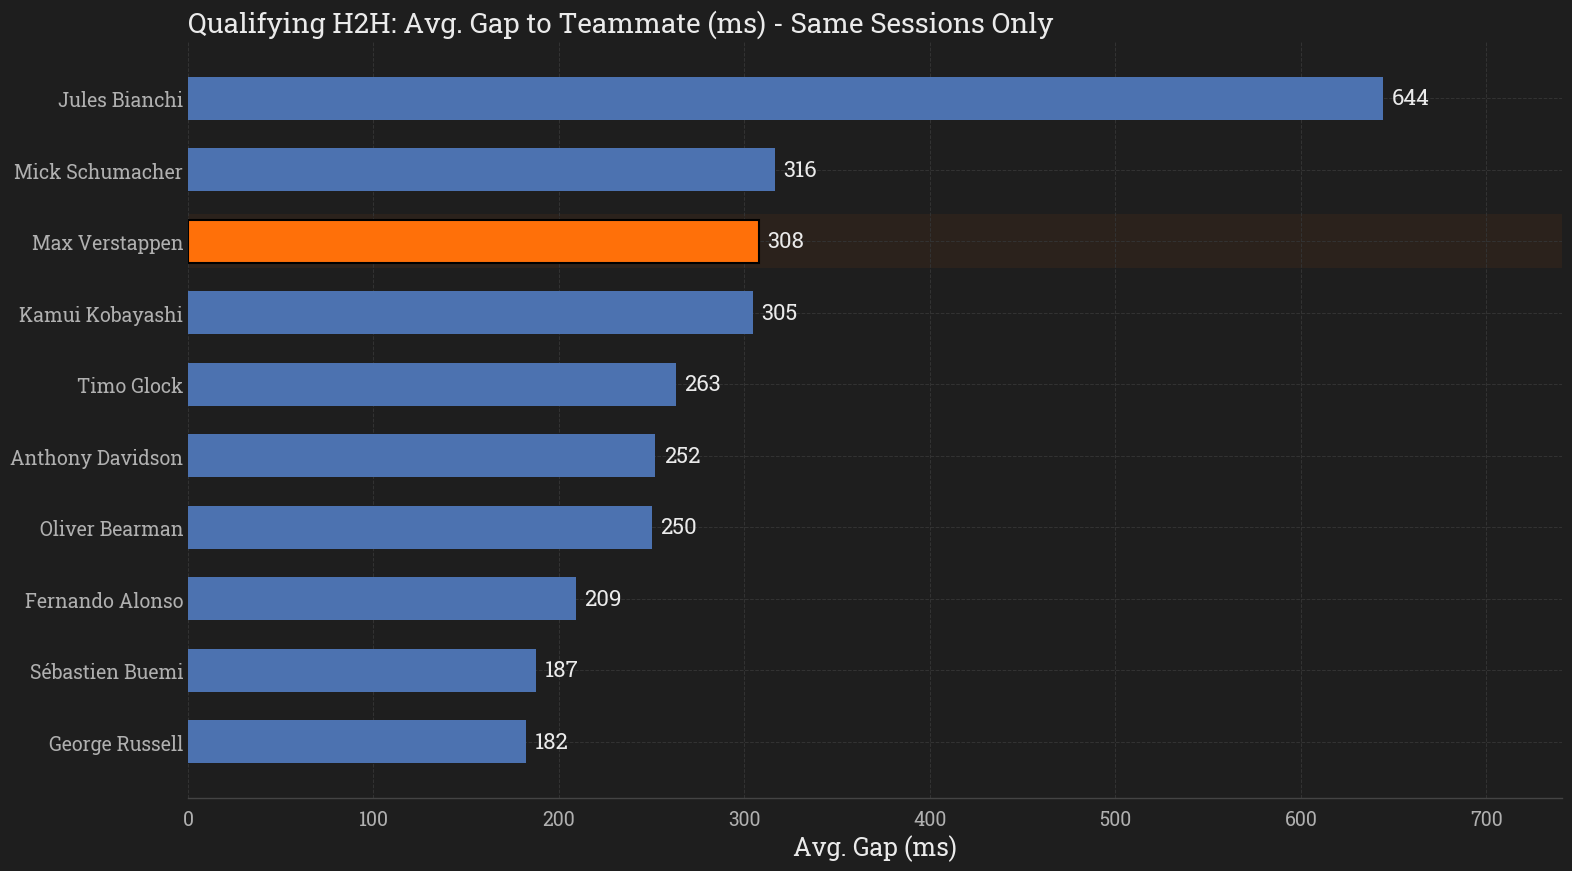

In [57]:
graf_top_pilotos(
    df=df_quali_vs_time,
    top_n=10,
    col_valor='best_lap_time_ms_diff_tmate',
    # Título traduzido e conciso
    titulo='Qualifying H2H: Avg. Gap to Teammate (ms) - Same Sessions Only',
    # Adicionei o xlabel para garantir que o eixo também fique em inglês
    xlabel='Avg. Gap (ms)',
    save_fig=True
)

O gráfico acima é interessante, eu vejo nomes bem inesperados que aparecessem nessas análises e entendo isso da seguinte forma:
- Nomes como Jules Bianchi e Mick Schumacher tiveram temporadas muito dominantes contra seu companheiro de equipe em algum momento da carreira e não tiveram muitas outras performances além dessas, ou seja, tiveram temporadas específicas com companheiros que eram claramente mais "fracos", mas por si só não tiveram performances dominantes na F1;
- A maioria dos nomes são de pilotos que participaram de equipes do *mid field* pra trás, onde geralmente vemos maiores oscilações em termos de performance, e onde muitos pilotos que estão iniciando sua carreira estão fazendo parte;
- Também, nessas equipes, é mais comum que piltos terminem a qualificação em sessões diferentes (apenas 1 deles vai pro Q2 etc) e isso diminui o tamanho da amostra pra quando formos calcular a média, fazendo com que uma ou outra performance que seja mais dominante, apesar de não consistente, puxar a média pra cima.

Por esses e outros motivos, novamente, não acho que faça tanto sentido compararmos nomes como Mick Schumacher com Verstappen, Alonso, Russel etc porque tiveram trajetórias de carreira bem diferentes e que tiveram que performar contra diversos companheiros de equipe que realizaram conquistas na F1 por si só. Sendo assim, vou fazer o mesmo filtro que fiz antes em análises anteriores, selecionando só nomes específicos aqui pra análise.

E, novamente, com esses fatores que disse acima, eu não quis dizer que eu considero esses pilotos "piores" e portanto estaria simplesmente removendo da análise por vontade própria pra criar alguma narrativa específica, mas eu acho que estamos falando de pilotos com trajtetórias de carreira na F1 muito diferentes e por conta disso acredito que a análise acabe perdendo um pouco de sentido.

Gráfico salvo em: b:\projetos\f1_analytics\grafs\qualifying_h2h_avg_gap_to_teammate_ms__same_sessions__driver_filter_safe.png


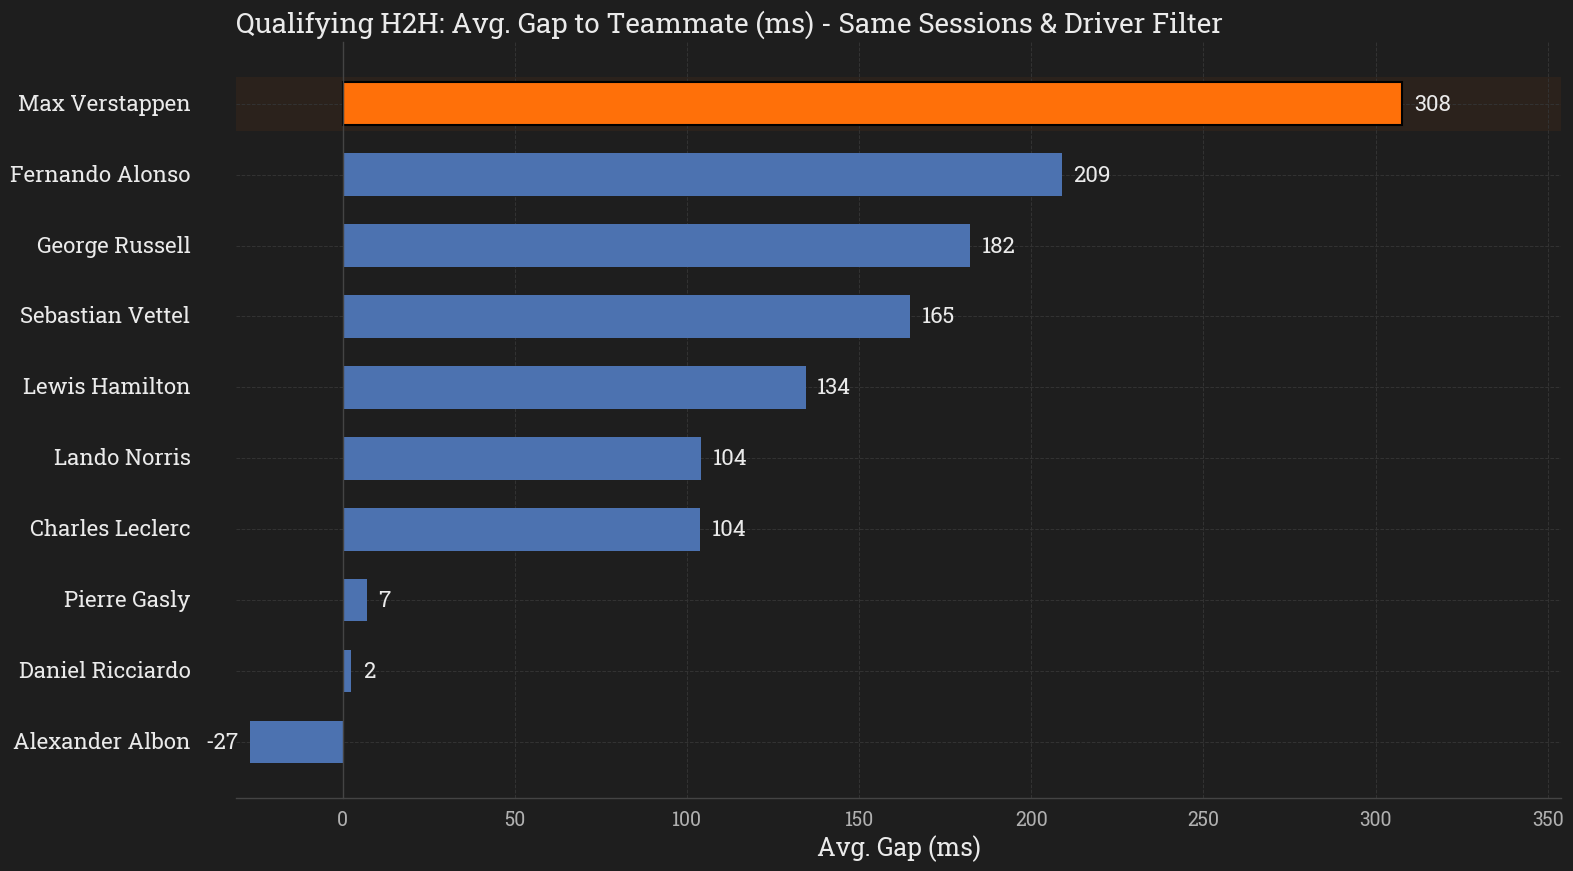

In [58]:
graf_top_pilotos(
    df=df_quali_vs_time[df_quali_vs_time['driver_full_name'].isin(lista_pilotos_a_comparar + ['Max Verstappen'])],
    top_n=10,
    col_valor='best_lap_time_ms_diff_tmate',
    # Título traduzido: Conciso e explica os filtros aplicados
    titulo='Qualifying H2H: Avg. Gap to Teammate (ms) - Same Sessions & Driver Filter',
    # Sugestão: Adicione o xlabel se quiser garantir que o eixo também fique em inglês
    xlabel='Avg. Gap (ms)',
    save_fig=True
)

Parece brincadeira, mas realmente parece que o Verstappen, novamente, possui maior média de superação de seu companheiro de equipe em qualificação (considerando apenas quando foram para a mesma sessão).

Podemos ver isso por companheiro de equipe do VER, tentando identificar até se teve algum que superou ele. Farei isso abaixo.

In [59]:
df_quali_vs_time_tmate = df_quali_vs.groupby(
    [
        'driver_ref',
        'driver_full_name',
        'driver_full_name_tmate'
    ]
).agg(
    {
        'best_lap_time_ms_diff_tmate' : 'mean',
        'round_id':'count' # Vou extrair também quantos eventos fizeram juntos
    }
).reset_index().rename(
    columns={
        'round_id':'round_count'
    }
)

# Vou inverter o sinal, pra ficar mais fácil de visualizar, dado que aqui, valores negativos são melhores
df_quali_vs_time_tmate['best_lap_time_ms_diff_tmate'] = df_quali_vs_time_tmate['best_lap_time_ms_diff_tmate']*-1

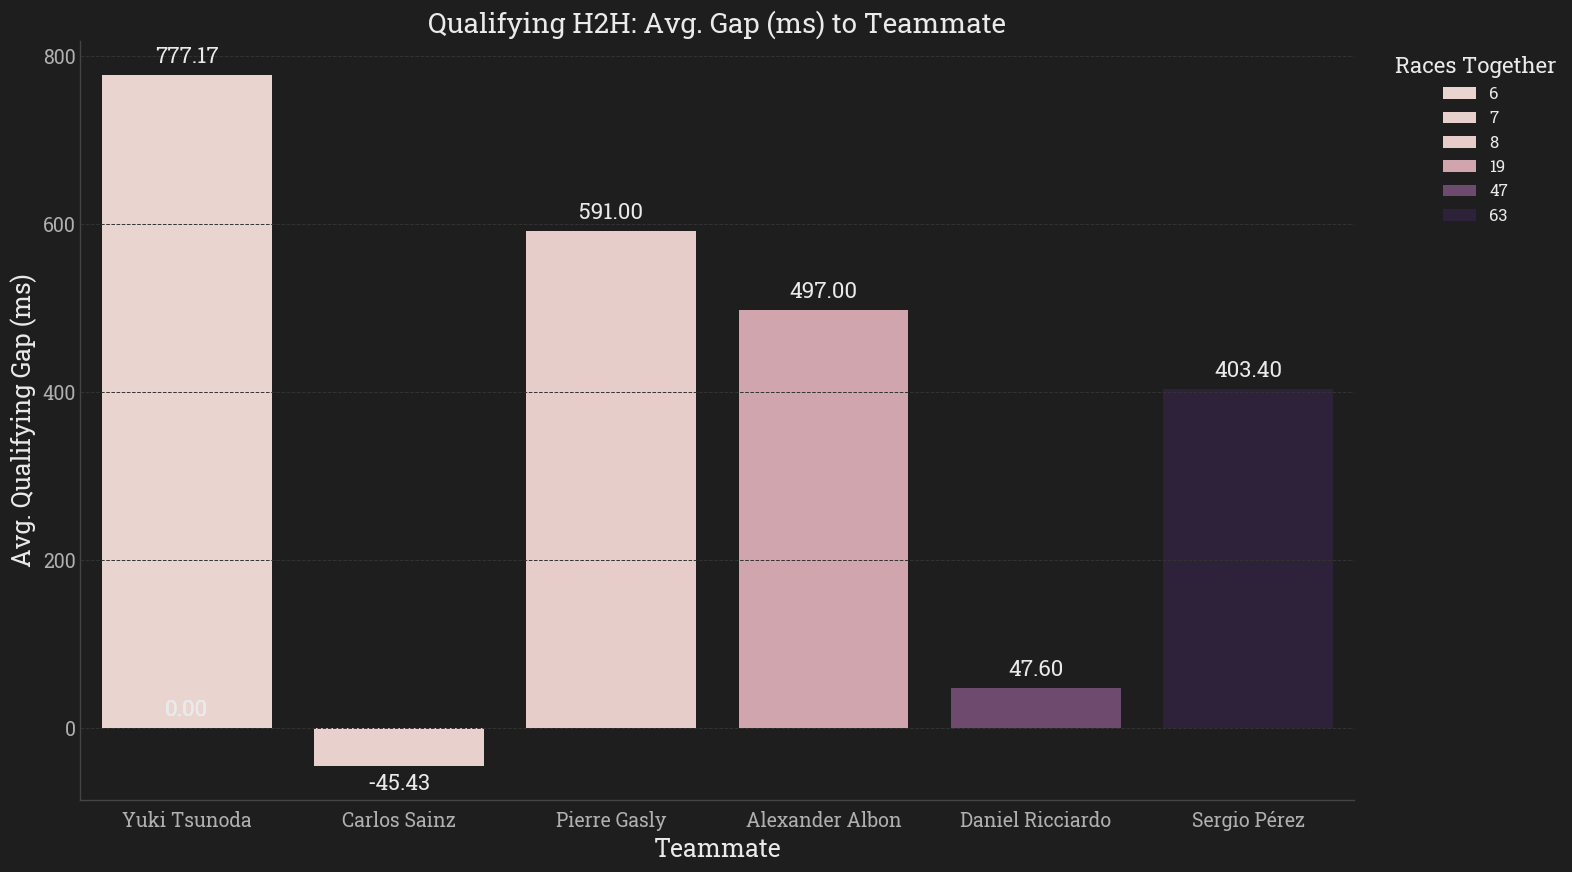

In [60]:
fig, ax = plt.subplots(figsize=(16,9))

sns.barplot(
    data=df_quali_vs_time_tmate[df_quali_vs_time_tmate['driver_full_name']=='Max Verstappen'].sort_values('round_count'),
    x='driver_full_name_tmate',
    y='best_lap_time_ms_diff_tmate',
    hue='round_count',
    ax=ax
)

# Anota todas as barras
for p in ax.patches:
    height = p.get_height()
    
    # Lógica para deslocar o label se o valor for negativo
    # 'va' (vertical alignment) define se o texto fica acima (bottom) ou abaixo (top) do ponto y
    # 'xytext' define o offset vertical em pontos
    if height >= 0:
        va = 'bottom' 
        y_offset = 5
    else:
        va = 'top'   
        y_offset = -5
        
    ax.annotate(
        f'{height:,.2f}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va=va, # Usa a lógica condicional
        xytext=(0, y_offset), # Usa o offset condicional
        textcoords='offset points'
    )

# --- TRADUÇÕES ---
ax.set_xlabel("Teammate")
ax.set_ylabel("Avg. Qualifying Gap (ms)")
ax.set_title("Qualifying H2H: Avg. Gap (ms) to Teammate")

# Adiciona título à legenda e move para fora
legend = ax.get_legend()
if legend:
    legend.set_title("Races Together")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1))

# Chama o tight_layout() ANTES de salvar
plt.tight_layout()

# Usa bbox_inches='tight' no savefig para incluir a legenda
fig.savefig(
    'grafs/h2h_quali_gap_medio_verstappen_vs_tmates.png',
    bbox_inches='tight',
    transparent=True 
)

plt.show()

Acima podemos ver um gráfico que mostra, por companheiro de equipe, qual foi o gap médio entre eles. Para Verstappen: superou todos os seus companheiros de equipe com a exceção de sua primeira temporada na F1, em que foi levemente superado por Sainz, apesar de terem empatado em termos de resultado na quali, quando ambos terminaram na mesma sessão (ambos foram pro Q3, por exemplo, que infelizmente não foram muitos casos com apenas 7), podemos ver que Sainz levou uma pequena vantagem frente ao Verstappen.

Fora o Sainz, VER superou todos os outros em termos de tempo (o Ricciardo por muito pouco), quando terminaram na mesma sessão. E por conta desse filtro também que o Lawson não aparece na lista, na sua breve participação na RBR, ele não chegou a conseguir terminar nenhuma quali no Q3, por isso, não aparece no gráfico.

### H2H em Corridas:

Agora, pra finalmente fechar a parte de análises, antes de partir pra conclusão, vou dar uma olhada no dataset de corridas. Mas acho que algumas conclusões que eu vou apresentar aqui vão ser meio óbvias dado o andamento da análise até o momento, então vou tentar passar mais rapidamente e ir para um ponto que pode ser mais interessante. Vou explicando abaixo conforme for andando com a análise.

#### Resultados de corridas:

In [61]:
# Vou trabalhar momentaneamente com o dataset de corridas:

df_races = add_lap_time_ms_column(df_races, 'fastest_lap_time')

df_races_vs = add_colunas_companheiro_equipe(
    df_dados=df_races,
    metricas=['fastest_lap_time_ms', 'finishing_position', 'race_status'],
    colunas_id_tmate=['driver_ref', 'driver_full_name']
)

# Vou filtrar eventos em que ambos os pilotos terminaram a corrida:
lista_status_a_considerar = [0,1] # Status que indicam que o piloto terminou a corrida (finished ou finished lap behind)
df_races_vs = df_races_vs[(df_races_vs['race_status'].isin(lista_status_a_considerar)) & (df_races_vs['race_status_tmate'].isin(lista_status_a_considerar))]


Assim como fizemos pra qualificação, acho que é interessante aqui fazer uma análise por percentual de vitória VS o companheiro de equipe nas corridas:

In [62]:
# Crio uma flag pra identificar se o piloto ganhou contra o companheiro de equipe:

df_races_vs['fl_win_race_vs_tmate'] = df_races_vs['finishing_position'] < df_races_vs['finishing_position_tmate']

# Vou agrupar o dataset por essa flag:

df_races_vs_agrup = df_races_vs.groupby(
    [
        'driver_ref',
        'driver_full_name',
        'fl_win_race_vs_tmate'
    ]
).agg(
    {
        'race_name':'count'
    }
).reset_index().rename(
    columns={
        'race_name':'qt_rounds'
    }
)

# Adiciono uma coluna calculando o percentual:
# Primeiro calculo a quantidade total que ele teve:
df_races_vs_agrup['total_rounds_for_driver'] = df_races_vs_agrup.groupby(['driver_ref'])['qt_rounds'].transform('sum')

# Calculo o percentual dividindo uma coisa pela outra:
df_races_vs_agrup['result_percentage'] = df_races_vs_agrup['qt_rounds'] / df_races_vs_agrup['total_rounds_for_driver']

# vou filtrar usando a flag, pra ter o percentual apenas referente a quando o piloto ficou na frente de seu companheiro de equipe:
df_races_vs_agrup = df_races_vs_agrup[df_races_vs_agrup['fl_win_race_vs_tmate']]

# Vou filtrasr só quem teve mais do que 20 corridas (pra não pegar pilotos que participaram de poucos eventos):
df_races_vs_agrup = df_races_vs_agrup[df_races_vs_agrup['total_rounds_for_driver']>20]

Gráfico salvo em: b:\projetos\f1_analytics\grafs\top_15_drivers_by_race_win__vs_teammate_safe.png


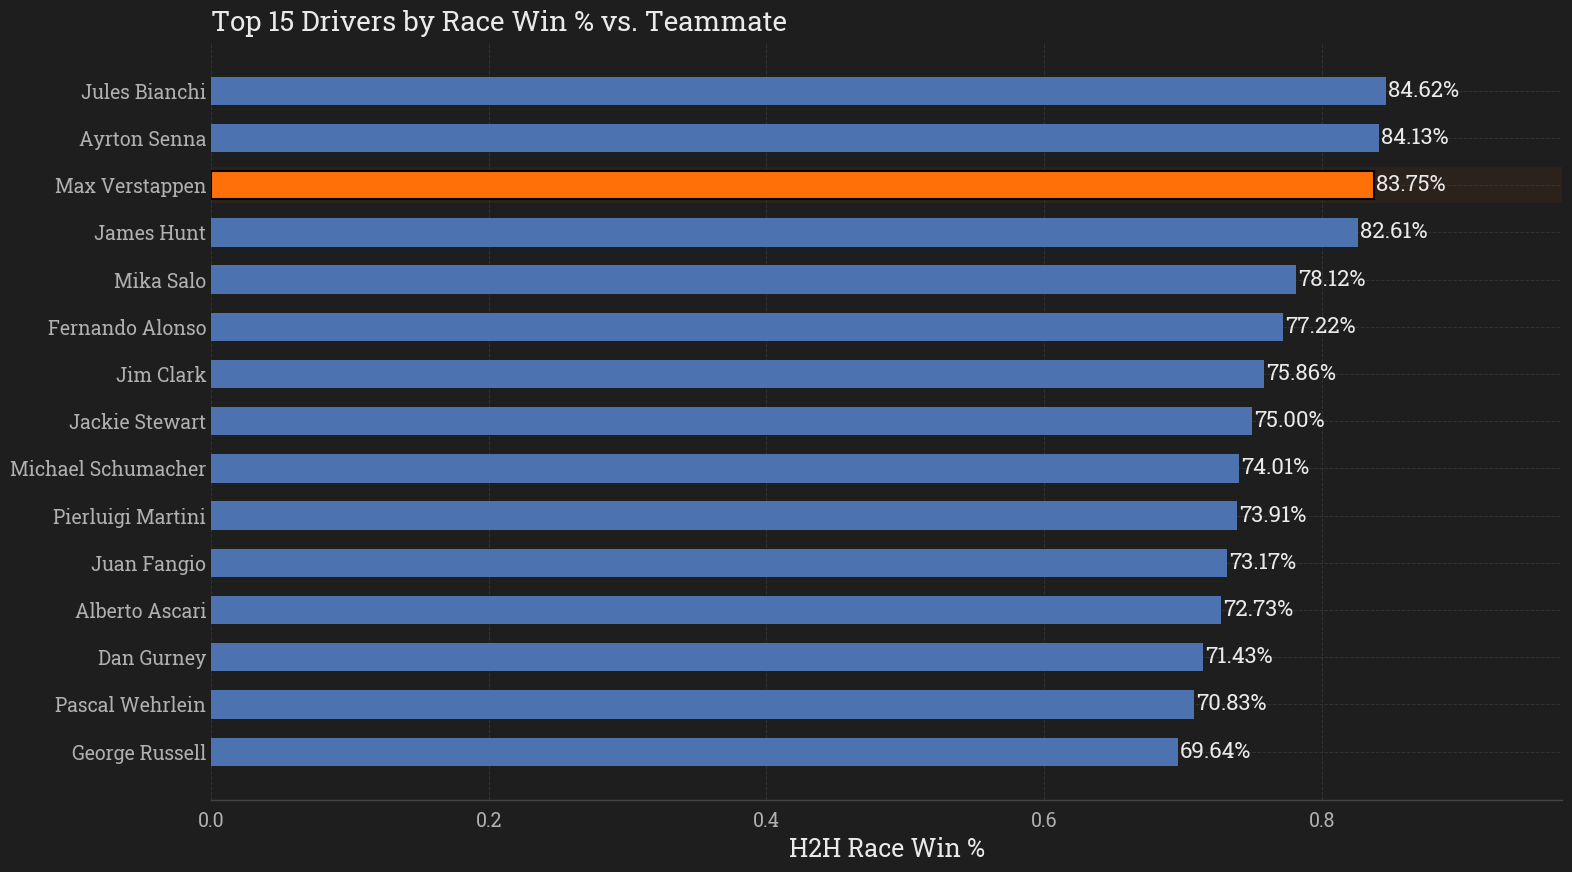

In [63]:
# Agora, partindo pra análise, filtro só o flag de vitória pra ter o percentual de vitória:
df_races_vs_agrup_wins = df_races_vs_agrup[df_races_vs_agrup['fl_win_race_vs_tmate']]

# E vamos dar uma olhada nos top pilotos com maior percentual de vitória contra o companheiro de equipe no dataset inteiro:
graf_top_pilotos(
    df=df_races_vs_agrup_wins,
    top_n=15,
    col_valor='result_percentage',
    valor_format_str='{:.2%}',
    # Título traduzido
    titulo='Top 15 Drivers by Race Win % vs. Teammate',
    # Label do eixo X traduzido
    xlabel='H2H Race Win %',
    save_fig=True
)

Surpresa surpresa, de novo temos o Verstappen aparecendo com um dos maiores percentuais da lista.

É interessante ver outros nomes aparecendo aqui também (Jules Bianchi, já explicado, aparece novamente), temos também o Senna, e alguns outros nomes menos esperados como Mika Salo. Para isso, reforço o filtro que estou utilizando que é de apenas corridas em que ambos os pilotos terminaram, o que muda consideravelmente o resultado da análise se considerarmos DNFs como derrota para alguns dos pilotos. O que era muito mais comum em eras anteriores da F1, ou seja, os dados mudam muito mais ao remover DNFs para dados mais antigos.

E, novamente, eu posso usar a lista que eu tinha construído antes, com nomes apenas da F1 mais moderna pra efeitos de comparação:

Gráfico salvo em: b:\projetos\f1_analytics\grafs\top_15_drivers_by_race_win__vs_teammate_w_drivers_filter_safe.png


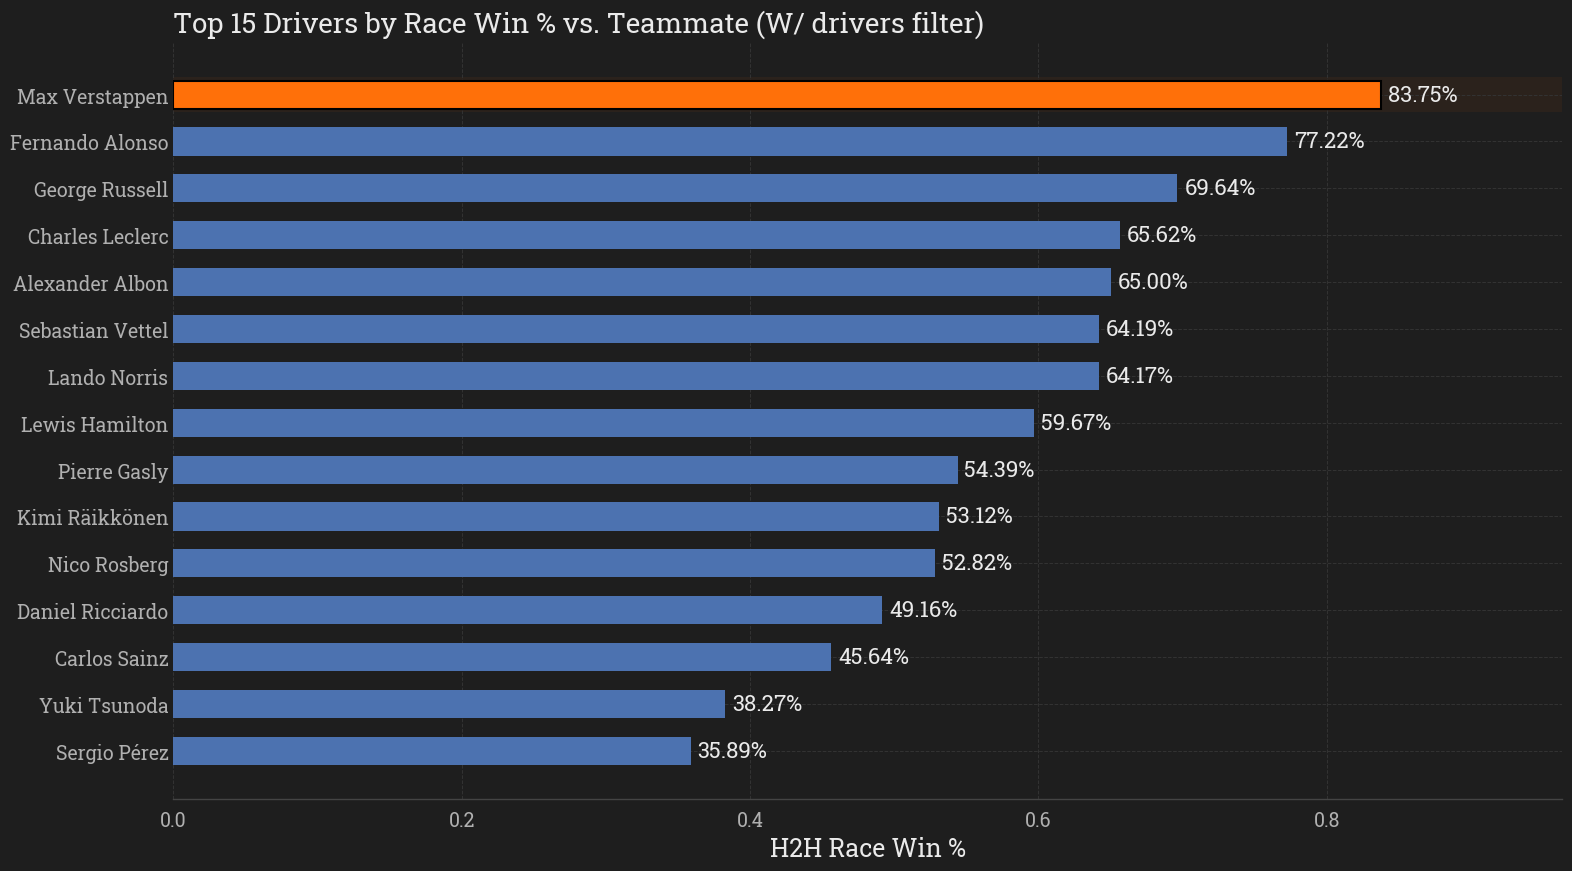

In [64]:
graf_top_pilotos(
    df_races_vs_agrup_wins[df_races_vs_agrup_wins['driver_full_name'].isin(lista_pilotos_a_comparar + ['Max Verstappen'])],
    top_n=15,
    col_valor='result_percentage',
    valor_format_str='{:.2%}',
    titulo='Top 15 Drivers by Race Win % vs. Teammate (W/ drivers filter)',
    xlabel='H2H Race Win %',
    save_fig=True
)


Dentre grandes nomes da era moderna da F1, Verstappen aparece com o maior percentual de superação do companheiro de equipe em termos de resultados de corridas.

Novamente, podemos ver Verstappen, por companheiro de equipe:

In [65]:
df_races_vs_agrup_tmate = df_races_vs.groupby(
    [
        'driver_ref',
        'driver_full_name',
        'driver_full_name_tmate',
        'fl_win_race_vs_tmate',
    ]
).agg(
    {
        'race_name':'count'
    }
).reset_index().rename(
    columns={
        'race_name':'qt_rounds'
    }
)

# Adiciono uma coluna calculando o percentual:
# Primeiro calculo a quantidade total que ele teve com cada companheiro de equipe:
df_races_vs_agrup_tmate['total_rounds_for_driver'] = df_races_vs_agrup_tmate.groupby(['driver_ref', 'driver_full_name_tmate'])['qt_rounds'].transform('sum')

# Calculo o percentual dividindo uma coisa pela outra:
df_races_vs_agrup_tmate['result_percentage'] = df_races_vs_agrup_tmate['qt_rounds'] / df_races_vs_agrup_tmate['total_rounds_for_driver']

# vou filtrar usando a flag, pra ter o percentual apenas referente a quando o piloto ficou na frente de seu companheiro de equipe:
df_races_vs_agrup_tmate = df_races_vs_agrup_tmate[df_races_vs_agrup_tmate['fl_win_race_vs_tmate']]

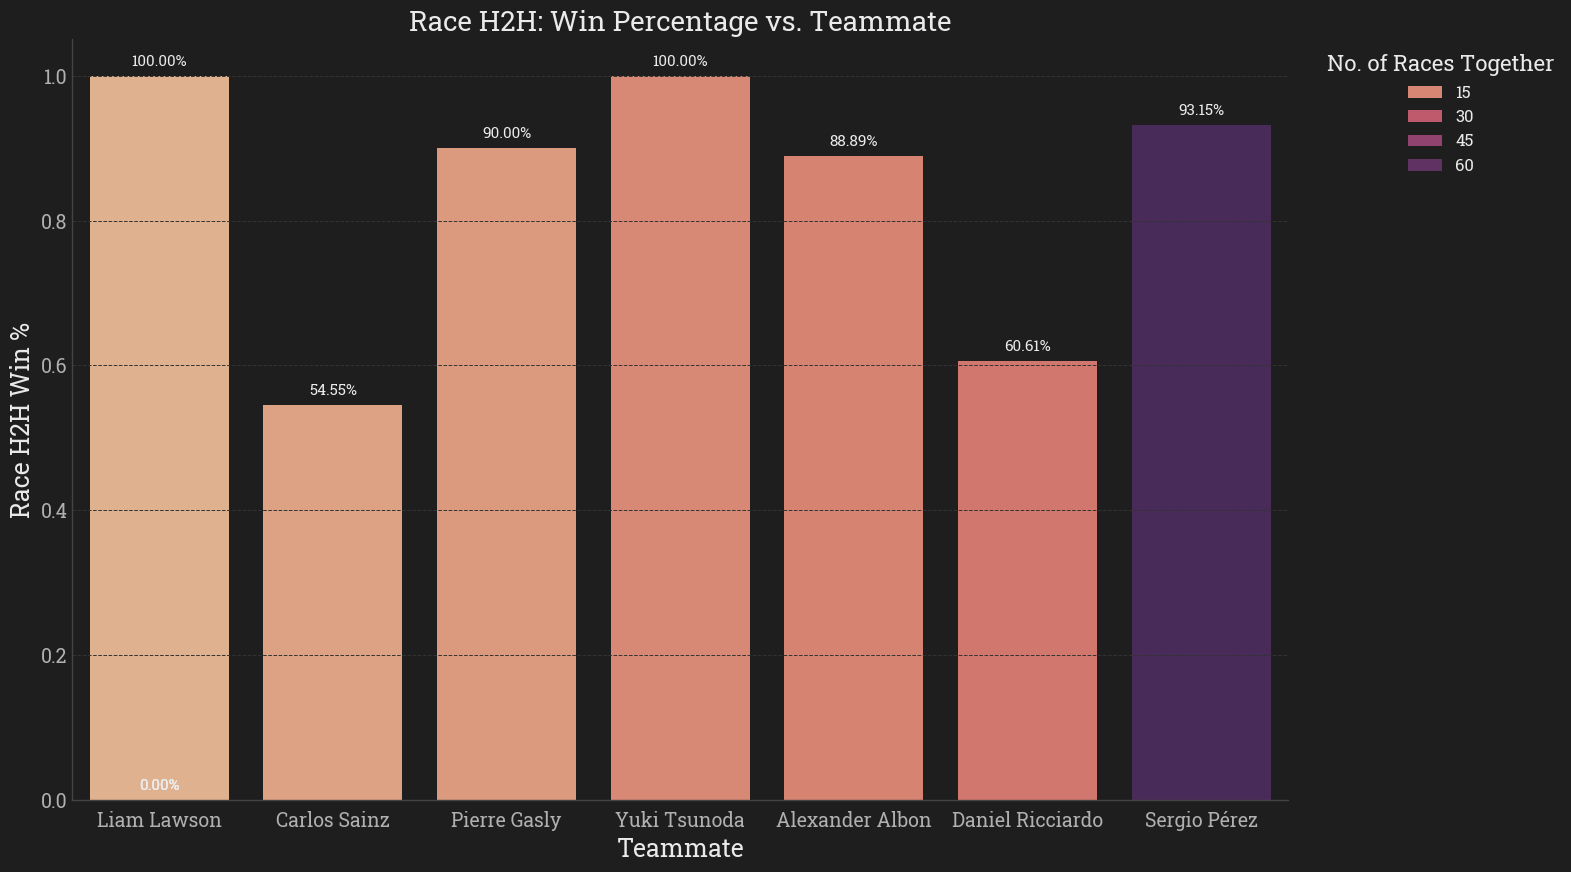

In [66]:
fig, ax = plt.subplots(figsize=(16,9))

sns.barplot(
    data=df_races_vs_agrup_tmate[df_races_vs_agrup_tmate['driver_full_name']=='Max Verstappen'].sort_values('qt_rounds'),
    x='driver_full_name_tmate',
    y='result_percentage',
    hue='qt_rounds',
    palette='flare',
    ax=ax
)

for p in ax.patches:
    # A lógica de deslocamento de label é aplicada aqui
    height = p.get_height()
    if height >= 0:
        va = 'bottom' 
        y_offset = 5
    else:
        va = 'top'   
        y_offset = -5
        
    ax.annotate(
        # Mantendo o formato de percentual
        f'{height:.2%}',
        (p.get_x() + p.get_width() / 2., height),
        ha='center',
        va=va,
        xytext=(0, y_offset),
        textcoords='offset points',
        fontsize=11
    )

# --- TRADUÇÕES ---

# Eixo X
ax.set_xlabel("Teammate")

# Eixo Y
ax.set_ylabel("Race H2H Win %")

# Título do Gráfico
ax.set_title('Race H2H: Win Percentage vs. Teammate')

# Adiciona título à legenda e move para fora
legend = ax.get_legend()
if legend:
    legend.set_title("No. of Races Together")
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1.02, 1))

# Chama o tight_layout() ANTES de salvar
plt.tight_layout()

# Salva com bbox_inches='tight' para incluir a legenda
fig.savefig(
    'grafs/h2h_corrida_percentual_superacao_ver_vs_tmates.png',
    bbox_inches='tight',
    transparent=True 
)

plt.show()

Podemos ver que em resultados de corrida, Verstappen superou todos os companheiros de equipe que teve até hoje, sendo que o que chegou mais perto, novamente em linha com o que vimos antes, foi Sainz, na primeira temporada de ambos na F1 na Toro Rosso. Ricciardo também chegou relativamente perto dos 50%, mas contra todo o restante, Verstappen conseguiu ser absolutamente dominante.

### Comparação de volta mais rápida

Bom, até o momento, nesta análise que ficou mais longa do que eu esperava, já analisamos números gerais, analisamos consistência de ritmo de volta, vimos performance de qualificação e diversas óticas de comparação de resultados em campeonato, corrida e quali também. Pra finalizar então, uma outra métrica que me vem na cabeça é verificar os melhores tempos de volta das corridas.

Como já fizemos uma análise de ritmo pela ótica de consistência, seria bom agora termos uma ótica de velocidade mesmo, e a ideia de fazer isso é por meio da volta mais rápida de cada corrida: **Se analisarmos a volta mais rápida de cada piloto por corrida, quem é que costuma ser o mais rápido frente ao companheiro de equipe?**

In [67]:
# Percebi que nas antigas, tem pilotos que possuem seu tempo de volta em branco, então vou tirar esses registros e depois fazer um filtro pra quem só tiver
# uma quantidade mínima razoável de provas registradas para que a análise seja relevante (não faz sentido eu apresentar resultados de um
# piloto que tenha menos do que 20 provas registradas)

df_races_vs_valid = df_races_vs[~df_races_vs['fastest_lap_time_ms'].isna()].copy()

# Trago a quantidade de corridas que o piloto fez:
df_races_vs_valid['count_valid_data_races'] = df_races_vs_valid.groupby(['driver_ref'])['race_name'].transform('count') 

# Filtro pilotos com um mínimo de 20 corridas:
df_races_vs_valid = df_races_vs_valid[df_races_vs_valid['count_valid_data_races']>20]

In [68]:
# Agrupo pra calcular a média de ms de quanto cada piloto supera seu companheiro de equipe:

df_vs_fast_lap = df_races_vs_valid.groupby(
    [
        'driver_ref',
        'driver_full_name',   
    ]
).agg(
    {
        'fastest_lap_time_ms_diff_tmate' : 'mean'
    }
).reset_index(
).sort_values(
    ['fastest_lap_time_ms_diff_tmate']
)

# Vou só inverter o valor pra ficar melhor de ver no gráfico:
df_vs_fast_lap['fastest_lap_time_ms_diff_tmate'] = df_vs_fast_lap['fastest_lap_time_ms_diff_tmate']*-1

Gráfico salvo em: b:\projetos\f1_analytics\grafs\fastest_lap_h2h_avg_gap_ms_vs_teammate_safe.png


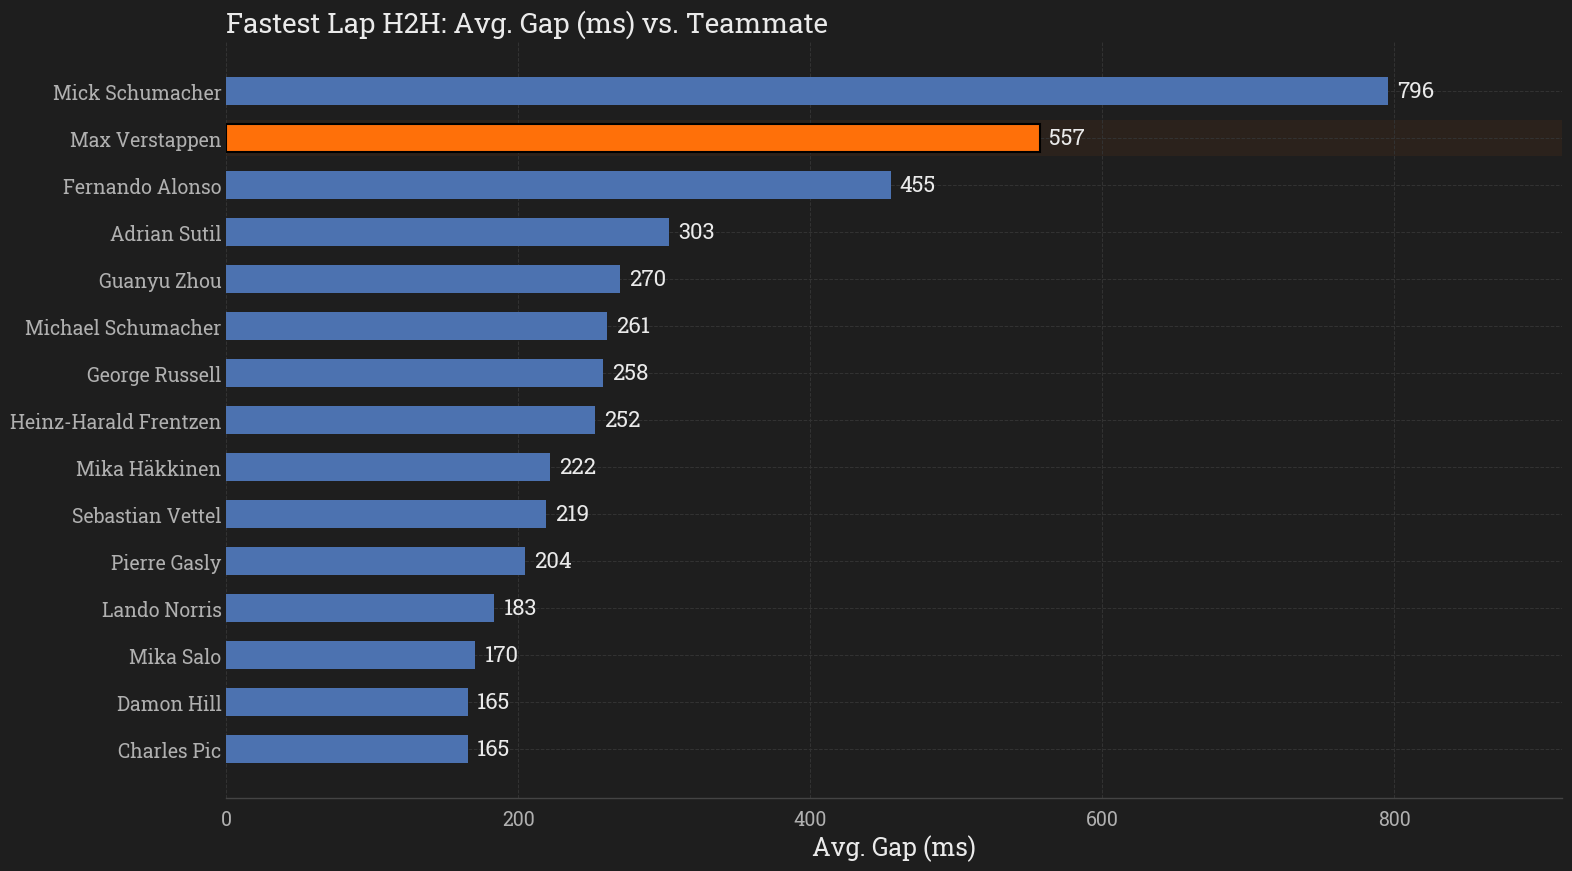

In [69]:
# Vou colocar num gráfico:
graf_top_pilotos(
    df=df_vs_fast_lap,
    top_n=15,
    col_valor='fastest_lap_time_ms_diff_tmate',
    titulo='Fastest Lap H2H: Avg. Gap (ms) vs. Teammate',
    xlabel='Avg. Gap (ms)',
    save_fig=True
)

Novamente, podemos ver resultados mais ou menos em linha com o que estávamos vendo nas análises anteriores e, para a surpresa de 0 pessoas nessa altura da análise, o Verstappen aparece entre os que mais superaram seu companheiro de equipe em termos de tempo na volta mais rápida.

Aqui, é interessante ter em mente que eu só to vendo o tempo da volta mais rápida, não to analisando ritmo volta a volta que nem fiz antes na análise de consistência.

Vemos nomes como Mick Schumacher (que superou de forma massacrante Nikita Mazepin em sua primeira temporada), Guanyu Zhou, que aparentemente ao analisarmos apenas a volta mais rápida, conseguiu ter uma média de tempo melhor de que seus companheiros de equipe, apesar de ter perdido o H2H de resultados contra Valteri Bottas. E, novamente, apenas pra seguir a linha do que trouxe na análise até agora, vou trazer o mesmo gráfico considerando apenas a lista de pilotos que bolei antes neste notebook:

Gráfico salvo em: b:\projetos\f1_analytics\grafs\fastest_lap_h2h_avg_gap_ms_vs_teammate_filtered_safe.png


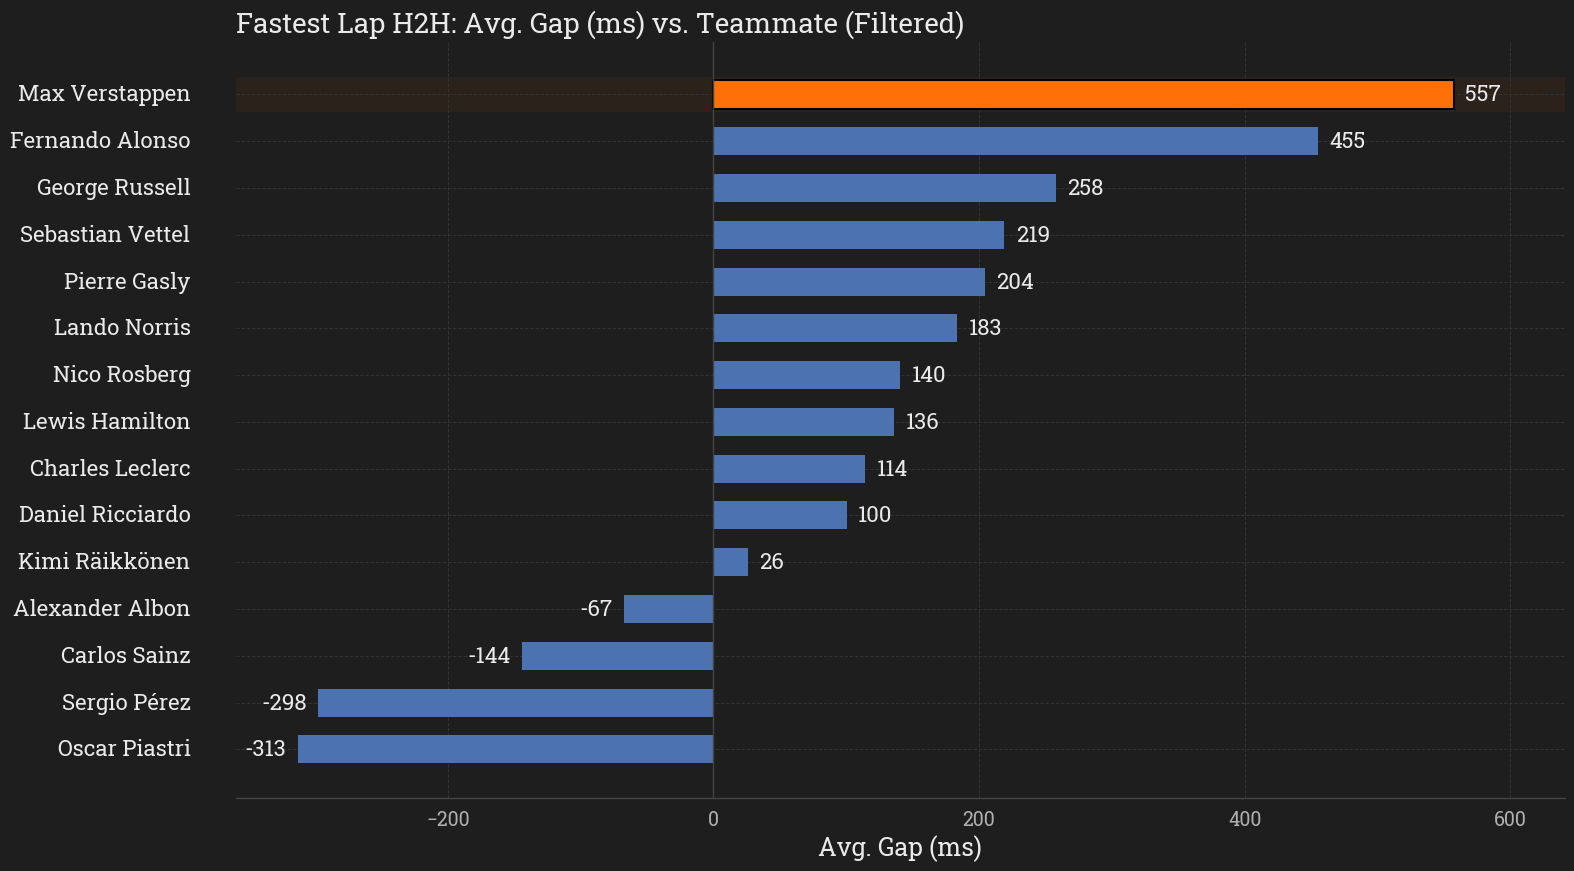

In [70]:
# Vou colocar num gráfico:
graf_top_pilotos(
    df=df_vs_fast_lap[df_vs_fast_lap['driver_full_name'].isin(lista_pilotos_a_comparar + ['Max Verstappen'])],
    top_n=15,
    col_valor='fastest_lap_time_ms_diff_tmate',
    # Título ajustado para indicar o filtro
    titulo='Fastest Lap H2H: Avg. Gap (ms) vs. Teammate (Filtered)',
    xlabel='Avg. Gap (ms)',
    save_fig=True
)

Como já era de se esperar a partir do gráfico anterior, a partir do filtro de pilotos, o Verstappen aparece no topo e, começamos a ver pilotos que possuem uma média negativa, que são justamente pilotos que foram companheiros de equipe dos que tiveram média positiva, o que é interessante e comprova a consistência da análise.

# Conclusão:

Esta análise não se propõe a declarar Max Verstappen o "melhor piloto de todos os tempos", uma comparação complexa entre diferentes eras. O objetivo foi quantificar seu desempenho de forma objetiva, e os dados confirmam: **Verstappen é, sem dúvida, um dos maiores talentos da história do automobilismo.** Ele apareceu no topo de todas as métricas que apresentei nesse notebook, todas visando analisar a "qualidade" de um piloto (em minha visão pessoal).

Os números gerais (Top 3 em vitórias, Top 5 em poles)  já o colocam no eterno hall da fama da F1, mas é mais interessante ainda quando tentamos isaolar a performance do carro. Para isso, a análise focou na consistência de ritmo e na batalha direta contra companheiros de equipe (H2H), e em ambas as frentes, Verstappen se mostrou estatisticamente dominante.

Na métrica de consistência (o desvio padrão relativo), Verstappen provou ser o piloto mais regular do grid moderno, superando nomes como Lewis Hamilton e George Russell (os que chegaram mais perto). Em qualificações, ele vence 79,3% de suas batalhas H2H (a maior taxa entre os rivais da lista) e possui o maior gap médio de velocidade (308ms) sobre seus companheiros. A história se repete nas corridas:  Verstappen venceu seu companheiro em 83,75% das vezes, um número de elite que rivaliza diretamente com o de Ayrton Senna (84,13%).

É válido, no entanto, abrir espaço para o questionamento de que Verstappen não enfrentou o mesmo nível de competição interna que pilotos como Lewis Hamilton. Os dados desta análise validam essa discussão: a única vez que Verstappen não dominou foi contra seu primeiro companheiro, Carlos Sainz. Na Toro Rosso, a batalha de qualificação entre os dois estreantes foi um empate técnico de 11-11 (50,00%). Mais revelador ainda, na média de tempo, Sainz foi 45ms mais rápido que Verstappen nas sessões em que competiram diretamente. Apesar de Verstappen ter batido ele no H2H de corridas, lembrando que era a primeira temporada da F1 pra ambos.

Excetuando essa equilibrada batalha de estreia, os dados mostram um domínio absoluto sobre todos os seus outros companheiros. Verstappen consistentemente "descolou" de seus pares, terminando o campeonato, em média, com 136 pontos e 5.27 vitórias  de vantagem. Em suma, os dados provam que Verstappen combina uma consistência metronômica com uma velocidade pura que o coloca no topo de quase todas as métricas de performance individual.